Notes:
- When calculating market share, do a version weighted by issue size, and if there are N multiple managers, assume each grabs a share of 1/N.
- Note that CSA is for statistical purposes and might be not accurate. E.g., "Rochester-Austin-Winona, MN" is a CSA, but they are quite apart.
    - CSA even misses some important areas. E.g., Toledo, Ohio
- Two pending questions:
    1. How to define a merger period? Go over each CSA, and check for instances of both sides having presence in past 3 years, and identify time windows where merging activities is most intensive.
    2. How to define geographic area? CSA is not ideal: not accurate enough.
- Do a hand-check of mergers and if/how they are recorded in the event dataset.
- Improvements (or robustness tests) for the merger:
    - Consider matching with states with similar restrictions on competitive sales and on dual advisor-underwriter?
- Heterogeneity:
    - Effects vary by if duality is allowed. If treated CSA bans dualship (so market power has little effect due to the dissipating effects of an advisor; advisor can, e.g., facilitate the look-out for alternative udnerwriters), effects should be much smaller.
 
Results:
- Somehow results disappear when using threshold computed with dollar-amount based market share or HHI.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import dask
import dask.dataframe as dd
import itertools
from itertools import chain
from math import sqrt, floor, ceil, isnan
import multiprocess
import importlib
from importlib import reload
from collections import Counter
from fuzzywuzzy import process, fuzz
import time
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
warnings.filterwarnings("error")

pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 400

try:
    del(FUN_proc_name)
except:
    pass
import FUN_proc_name
importlib.reload(FUN_proc_name)
from FUN_proc_name import FUN_proc_name

# A customized winsorisation function that handles None values correctly
# The percentiles are taken and winsorisation are done on non-None values only
def winsor2(series,cutoffs):

    import numpy as np
    import scipy as sp
    
    IsNone = np.isnan(series).copy()
    IsNotNone = np.logical_not(IsNone).copy()
    series_NotNonePart = sp.stats.mstats.winsorize(series[IsNotNone],limits=(cutoffs[0],cutoffs[1]))
    series_new = series.copy()
    series_new[IsNone] = np.nan
    series_new[IsNotNone] = series_NotNonePart

    return series_new


# 1. Import data

#### **Merge GPF and CBSA**

In [2]:
# Note that this cell is redundant. Somehow dask does not work when I use "%run" in the same notebook
# Content in these two cells must be consistent with the two scripts

# %run -i SCRIPT_us_states.py
# %run -i SCRIPT_import_GPF_CBSAData.py

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}


###############
# Import CBSA #
###############

# "CSA" is for metropolitan and "CBSA" includes also those micropolitan
CBSAData = pd.read_excel("../RawData/MSA/CBSA.xlsx",skiprows=[0,1])
CBSAData = CBSAData[~pd.isnull(CBSAData['County/County Equivalent'])]

# Add state abbreviations
us_state_to_abbrev = pd.DataFrame.from_dict(us_state_to_abbrev,orient='index').reset_index()
us_state_to_abbrev.columns = ['State Name','State']
CBSAData = CBSAData.rename(columns={'County/County Equivalent':'County'})
CBSAData = CBSAData.merge(us_state_to_abbrev,on='State Name',how='outer',indicator=True)
CBSAData = CBSAData[CBSAData['_merge']=='both'].drop(columns=['_merge'])
# Merge is perfect
CBSAData['County'] = CBSAData['County'].str.upper()
CBSAData['County'] = CBSAData['County'].str.replace(' COUNTY','')
CBSAData['County'] = CBSAData['County'].str.replace(' AND ',' & ')
CBSAData['County'] = CBSAData['County'].str.replace('.','',regex=False)
CBSAData['CSA Code'] = CBSAData['CSA Code'].astype(float)
CBSAData['CBSA Code'] = CBSAData['CBSA Code'].astype(float)


##############
# Import GPF #
##############

# Import GPF
GPF = pd.read_csv("../RawData/SDC/GPF.csv",low_memory=False)
if 'Unnamed: 0' in GPF.columns:
    GPF = GPF.drop(columns=['Unnamed: 0'])

# Generate cleaned names
raw_name_GPF_colnames = [column for column in GPF.columns if 'raw_name_GPF_' in column]
idx = 0
for column in raw_name_GPF_colnames:
    GPF['name_GPF_'+str(idx)] = GPF[column].apply(FUN_proc_name)
    idx = idx+1
name_GPF_colnames = ['name_GPF_'+str(idx) for idx in range(0,len(raw_name_GPF_colnames))]


# Hand corrections
# Change "CHEMICAL BANK" to "CHEMICAL BANK MICHIGAN" for deals in MI
GPF.loc[(GPF['lead_manager'].str.contains('Chemical Bank'))&(GPF['State']=='MI'),'lead_manager'] = 'CHEMICAL BANK MICHIGAN'
for column in raw_name_GPF_colnames:
    GPF.loc[(GPF['raw_name_GPF_0'].str.contains('Chemical Bank'))&(GPF['State']=='MI'),column] = 'CHEMICAL BANK MICHIGAN'

# Sometimes name of an entity that arise due to merger appear prior to merger
GPF.loc[(GPF['lead_manager']=='Dean Witter Reynolds Inc.')&(GPF['sale_year']<1978),'lead_manager'] = 'Dean Witter'
for column in raw_name_GPF_colnames:
    GPF.loc[(GPF['raw_name_GPF_0']=='Dean Witter Reynolds Inc.')&(GPF['sale_year']<1978),column] = 'Dean Witter'

GPF.loc[(GPF['lead_manager']=='Prescott, Ball & Turben, Inc.')&(GPF['sale_year']<1973),'lead_manager'] = 'Prescott, Merrill, Turben'
for column in raw_name_GPF_colnames:
    GPF.loc[(GPF['raw_name_GPF_0']=='Prescott, Ball & Turben, Inc.')&(GPF['sale_year']<1973),column] = 'Prescott, Merrill, Turben'

# Whether dual advisor/underwriter
GPF['raw_advisor_long'] = GPF['advisor_long']
GPF['raw_advisor_short'] = GPF['advisor_short']
GPF['advisor_long'] = GPF['advisor_long'].apply(FUN_proc_name)
GPF['advisor_short'] = GPF['advisor_short'].apply(FUN_proc_name)
GPF['if_dual_advisor'] = False
for col in name_GPF_colnames:
    GPF['if_dual_advisor'] = (GPF['if_dual_advisor'])|(GPF['advisor_long']==GPF[col])

# Winsorize data. Handle missing values cases carefully

upper_limit = np.percentile(GPF['gross_spread'][np.logical_not(np.isnan(GPF['gross_spread']))],99)
lower_limit = np.percentile(GPF['gross_spread'][np.logical_not(np.isnan(GPF['gross_spread']))],1)
GPF.loc[(GPF['gross_spread']>upper_limit)&(np.logical_not(np.isnan(GPF['gross_spread']))),'gross_spread'] = \
    upper_limit
GPF.loc[(GPF['gross_spread']<lower_limit)&(np.logical_not(np.isnan(GPF['gross_spread']))),'gross_spread'] = \
    lower_limit

upper_limit = np.percentile(GPF['avg_yield'][np.logical_not(np.isnan(GPF['avg_yield']))],99)
lower_limit = np.percentile(GPF['avg_yield'][np.logical_not(np.isnan(GPF['avg_yield']))],1)
GPF.loc[(GPF['avg_yield']>upper_limit)&(np.logical_not(np.isnan(GPF['avg_yield']))),'avg_yield'] = \
    upper_limit
GPF.loc[(GPF['avg_yield']<lower_limit)&(np.logical_not(np.isnan(GPF['avg_yield']))),'avg_yield'] = \
    lower_limit

upper_limit = np.percentile(GPF['avg_spread'][np.logical_not(np.isnan(GPF['avg_spread']))],99)
lower_limit = np.percentile(GPF['avg_spread'][np.logical_not(np.isnan(GPF['avg_spread']))],1)
GPF.loc[(GPF['avg_spread']>upper_limit)&(np.logical_not(np.isnan(GPF['avg_spread']))),'avg_spread'] = \
    upper_limit
GPF.loc[(GPF['avg_spread']<lower_limit)&(np.logical_not(np.isnan(GPF['avg_spread']))),'avg_spread'] = \
    lower_limit



#######################
# Merge GPF with CBSA #
#######################

# First try to merge with first item before '/'
GPF = GPF.reset_index(drop=True)
GPF = GPF[~pd.isnull(GPF['County'])]
for idx,row in GPF.iterrows():
    if '/' in row['County']:
        GPF.at[idx,'County'] = row['County'].split('/')[0]
GPF = GPF.merge(CBSAData[['CBSA Code','CSA Code','CBSA Title','CSA Title','County','State']],
    on=['County','State'],how='outer',indicator=True)

GPF = GPF[GPF['State']!='nan']
GPF = GPF[GPF['State']!='AS']
GPF = GPF[GPF['State']!='DC']
GPF = GPF[GPF['State']!='FF']
GPF = GPF[GPF['State']!='GU']
GPF = GPF[GPF['State']!='MR']
GPF = GPF[GPF['State']!='PR']
GPF = GPF[GPF['State']!='TT']
GPF = GPF[GPF['State']!='VI']

# Notes:
# Most cases it is because a county does not belong to any CBSA: Out of 3,000 counties in US, only 2,000 in CBSAData.
# Sometimes other "/" items lead to the right match in CBSAData.
# Some "County" fields are occupied by cities or school districts.
# Many cases issuer is "STATE AUTHORITY" or "COLLEGE OR UNIVERSITY".

# Handle cases where other "/" items might lead to the right match in CBSA
for idx,row in GPF.iterrows():
    if type(row['County_raw'])==str:
        if (row['_merge']=='left_only')&('/' in row['County_raw']):
            for item in row['County_raw'].split('/'):
                item = item.upper()
                CBSA_frag = CBSAData[(CBSAData['County']==item)&(CBSAData['State']==row['State'])].reset_index()
                if len(CBSA_frag)>0:
                    GPF.at[idx,'CBSA Code'] = CBSA_frag['CBSA Code'][0]
                    GPF.at[idx,'CSA Code'] = CBSA_frag['CSA Code'][0]
                    GPF.at[idx,'CBSA Title'] = CBSA_frag['CBSA Title'][0]
                    GPF.at[idx,'CSA Title'] = CBSA_frag['CSA Title'][0]
                    GPF.at[idx,'_merge'] = 'both'
                    # No need to continue once a match is found
                    break

#----------------#
# Credit ratings #
#----------------#

# Whether has rating
GPF['has_Moodys'] = \
    (GPF['Moodys_ILTR'].str.contains('A'))|(GPF['Moodys_ISTR'].str.contains('A'))|\
    (GPF['Moodys_ILTR'].str.contains('B'))|(GPF['Moodys_ISTR'].str.contains('B'))|\
    (GPF['Moodys_ILTR'].str.contains('C'))|(GPF['Moodys_ISTR'].str.contains('C'))
GPF['has_Fitch'] = \
    (GPF['Fitch_ILTR'].str.contains('A'))|(GPF['Fitch_ISTR'].str.contains('A'))|\
    (GPF['Fitch_ILTR'].str.contains('B'))|(GPF['Fitch_ISTR'].str.contains('B'))|\
    (GPF['Fitch_ILTR'].str.contains('C'))|(GPF['Fitch_ISTR'].str.contains('C'))|\
    (GPF['Fitch_ILTR'].str.contains('D'))|(GPF['Fitch_ISTR'].str.contains('D'))

# Ratings in numerical score. Take the best rating
GPF['rating_Moodys'] = None
for idx,row in GPF.iterrows():
    if str(row['Moodys_ILTR'])=='None' or str(row['Moodys_ISTR'])=='nan':
        continue
    if 'Aaa' in row['Moodys_ILTR'] or 'Aa1' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 0
    elif 'Aa1' in row['Moodys_ILTR'] or 'Aa1' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 1
    elif 'Aa2' in row['Moodys_ILTR'] or 'Aa2' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 2
    elif 'Aa3' in row['Moodys_ILTR'] or 'Aa3' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 3
    elif 'A1' in row['Moodys_ILTR'] or 'A1' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 4
    elif 'A2' in row['Moodys_ILTR'] or 'A2' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 5
    elif 'A3' in row['Moodys_ILTR'] or 'A3' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 6
    elif 'Baa1' in row['Moodys_ILTR'] or 'Baa1' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 7
    elif 'Baa2' in row['Moodys_ILTR'] or 'Baa2' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 8
    elif 'Baa3' in row['Moodys_ILTR'] or 'Baa3' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 9
    elif 'Ba1' in row['Moodys_ILTR'] or 'Ba1' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 10
    elif 'Ba2' in row['Moodys_ILTR'] or 'Ba2' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 11
    elif 'Ba3' in row['Moodys_ILTR'] or 'Ba3' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 12
    elif 'B1' in row['Moodys_ILTR'] or 'B1' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 13
    elif 'B2' in row['Moodys_ILTR'] or 'B2' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 14
    elif 'B3' in row['Moodys_ILTR'] or 'B3' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 15
    elif 'Caa1' in row['Moodys_ILTR'] or 'Caa1' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 16
    elif 'Caa2' in row['Moodys_ILTR'] or 'Caa2' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 17
    elif 'Caa3' in row['Moodys_ILTR'] or 'Caa3' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 18
    elif 'Ca' in row['Moodys_ILTR'] or 'Ca' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 19
    elif 'C' in row['Moodys_ILTR'] or 'C' in row['Moodys_ISTR']:
        GPF.at[idx,'rating_Moodys'] = 20

GPF['rating_Fitch'] = None
for idx,row in GPF.iterrows():
    if str(row['Fitch_ILTR'])=='None' or str(row['Fitch_ISTR'])=='nan':
        continue
    if 'AAA' in row['Fitch_ILTR'] or 'AAA' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 0
    elif 'AA+' in row['Fitch_ILTR'] or 'AA+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 1
    elif 'AA' in row['Fitch_ILTR'] or 'AA' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 2
    elif 'AA-' in row['Fitch_ILTR'] or 'AA-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 3
    elif 'A+' in row['Fitch_ILTR'] or 'A+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 4
    elif 'A' in row['Fitch_ILTR'] or 'A' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 5
    elif 'A-' in row['Fitch_ILTR'] or 'A-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 6
    elif 'BBB+' in row['Fitch_ILTR'] or 'BBB+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 7
    elif 'BBB' in row['Fitch_ILTR'] or 'BBB' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 8
    elif 'BBB-' in row['Fitch_ILTR'] or 'BBB-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 9
    elif 'BB+' in row['Fitch_ILTR'] or 'BB+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 10
    elif 'BB' in row['Fitch_ILTR'] or 'BB' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 11
    elif 'BB-' in row['Fitch_ILTR'] or 'BB-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 12
    elif 'B+' in row['Fitch_ILTR'] or 'B+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 13
    elif 'B' in row['Fitch_ILTR'] or 'B' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 14
    elif 'B-' in row['Fitch_ILTR'] or 'B-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 15
    elif 'CCC+' in row['Fitch_ILTR'] or 'CCC+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 16
    elif 'CCC' in row['Fitch_ILTR'] or 'CCC' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 17
    elif 'CCC-' in row['Fitch_ILTR'] or 'CCC-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 18
    elif 'CC+' in row['Fitch_ILTR'] or 'CC+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 19
    elif 'CC' in row['Fitch_ILTR'] or 'CC' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 20
    elif 'CC-' in row['Fitch_ILTR'] or 'CC-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 21
    elif 'C+' in row['Fitch_ILTR'] or 'C+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 22
    elif 'C' in row['Fitch_ILTR'] or 'C' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 22
    elif 'C-' in row['Fitch_ILTR'] or 'C-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 23
    elif 'D+' in row['Fitch_ILTR'] or 'D+' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 24
    elif 'D' in row['Fitch_ILTR'] or 'D' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 25
    elif 'D-' in row['Fitch_ILTR'] or 'D-' in row['Fitch_ISTR']:
        GPF.at[idx,'rating_Fitch'] = 16


In [3]:
# Import bond-level file provided by Mergent
Mergent_bondlevel = pd.read_parquet('../RawData/Mergent/Mergent_bondlevel.parque')

#### **Merge GPF with ultimate parent of underwriters**

In [4]:
# Put ultimate parent names into "GPF"
GPF = GPF.drop(columns=['_merge'],errors='ignore')
GPF_names = pd.read_parquet('../CleanData/SDC/GPF_names.parquet')
GPF_names = GPF_names[['name_GPF','parent_name','sale_year']]
GPF_names = GPF_names.drop_duplicates(['name_GPF','sale_year'])

# Add a column of cleaned underwriter names
column_ind = 0
raw_name_GPF_colnames = [column for column in GPF.columns if 'raw_name_GPF_' in column]
for column in raw_name_GPF_colnames:
    # Obtain the parent name
    # Note that this merge should be perfect. Check if it indeed is
    GPF = GPF.merge(GPF_names.rename(columns={'name_GPF':column[4:]}),on=[column[4:],'sale_year'],how='outer',indicator=True)
    GPF = GPF[(GPF['_merge']=='both')|(GPF['_merge']=='left_only')]
    GPF = GPF.drop(columns=['_merge'])
    GPF = GPF.rename(columns={'parent_name':'parent_name_'+str(column_ind)})
    column_ind = column_ind+1


#### **Calculate HHI**

HHI is calculated as concentration in terms of distribution across *parent* firms. I utilize two versions of HHI: (1) By number of deals. (2) By deal sizes.

In [5]:
%%time

# %%script false --no-raise-error

#################
# Calculate HHI #
#################

def proc_list(GPF):

    GPF = GPF.reset_index()
    GPF = GPF[~pd.isnull(GPF[Geo])]
    # Calculate concentration by CSA Code. Note that concentration is at the ultimate parent level
    GPF_gb = GPF.groupby([Geo,'sale_year'])
    market_share_all_markets = []
    for group in list(GPF_gb.groups.keys()):
        if str(group[0])=='nan' or np.isnan(group[1]) or str(group[1])=='nan':
            continue
        GPF_onegeoyear = GPF_gb.get_group(group)
        GPF_onegeoyear = GPF_onegeoyear[~pd.isnull(GPF_onegeoyear['amount'])]
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        parent_names = list(chain.from_iterable(list(np.array(GPF_onegeoyear[parent_name_colnames]))))
        parent_names = [item for item in parent_names if item!=None]
        parent_names = [item for item in parent_names if str(item)!='nan']
        parent_names = list(set(parent_names))
        bank_num_deals = {}
        # Initilize deal number for every bank to be 0
        # Note that there can be cases where there is no underwriter information for a CSA X Year, despite existing a deal
        if len(parent_names)==0:
            continue
        for item in parent_names:
            bank_num_deals[item] = [0,0]
    
        # Count deal number of each bank
        # Go over each deal
        for idx,row in GPF_onegeoyear.iterrows():
            # First, get weight for cases where there are multiple underwriters
            n_underwriter = 0
            for column in ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]:
                if row[column]!=None and str(row[column])!='nan':
                    n_underwriter = n_underwriter+1
            # Next, count number of underwriters
            for column in ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]:
                for parent_name in parent_names:
                    if row[column]==parent_name:
                        bank_num_deals[parent_name][0] = bank_num_deals[parent_name][0]+1/n_underwriter
                        bank_num_deals[parent_name][1] = bank_num_deals[parent_name][1]+row['amount']*1/n_underwriter
        
        # Record market share
        bank_num_deals = pd.DataFrame.from_dict(bank_num_deals,orient='index').reset_index().\
            rename(columns={'index':'parent_name',0:'N_deals',1:'Dollar_deals'})
        bank_num_deals['market_share_N'] = bank_num_deals['N_deals']/np.sum(bank_num_deals['N_deals'])
        bank_num_deals['market_share_Dollar'] = bank_num_deals['Dollar_deals']/np.sum(bank_num_deals['Dollar_deals'])
        bank_num_deals[Geo] = group[0]
        bank_num_deals['calendar_year'] = group[1]
        market_share_all_markets = market_share_all_markets+[bank_num_deals]
    
    # Collect results
    # Market share of each firm in each unit
    market_share_all_markets = pd.concat(market_share_all_markets)

    return market_share_all_markets


#------------#
# HHI by CSA #
#------------#

# Geographic unit
Geo = 'CSA Code'

GPF = GPF.set_index('sale_year')
output_columns = proc_list(GPF[1967:1968]).columns # Process one year to get columns
GPF_dd = dd.from_pandas(GPF, npartitions=20)
with dask.config.set(scheduler='processes',num_workers=20):
    market_share_all_markets = GPF_dd.map_partitions(proc_list, \
        meta=pd.DataFrame(columns=output_columns)).compute()
GPF = GPF.reset_index()

# Calculate hhi
market_share_all_markets_gb = market_share_all_markets.groupby(['CSA Code','calendar_year'])
HHI_by_N = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_N']
    hhi = np.sum(market_share**2)
    HHI_by_N = HHI_by_N+[{'CSA Code':group[0],'calendar_year':group[1],'hhi_by_N':hhi}]
HHI_by_N = pd.DataFrame(HHI_by_N)
HHI_by_Dollar = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_Dollar']
    hhi = np.sum(market_share**2)
    HHI_by_Dollar = HHI_by_Dollar+[{'CSA Code':group[0],'calendar_year':group[1],'hhi_by_Dollar':hhi}]
HHI_by_Dollar = pd.DataFrame(HHI_by_Dollar)

# HHI
HHI = HHI_by_N.merge(HHI_by_Dollar,on=['CSA Code','calendar_year'])
HHI_byCSA = pd.DataFrame(HHI)
NDealsTotal = pd.DataFrame(GPF.value_counts(['CSA Code','sale_year'])).reset_index()
NDealsTotal = NDealsTotal.rename(columns={'sale_year':'calendar_year',0:'N_Deals'})
HHI_byCSA = HHI_byCSA.merge(NDealsTotal,on=['CSA Code','calendar_year'])
# Market share
market_share_all_markets_byCSA = market_share_all_markets


#-------------#
# HHI by CBSA #
#-------------#

# Geographic unit
Geo = 'CBSA Code'

GPF = GPF.set_index('sale_year')
output_columns = proc_list(GPF[1967:1968]).columns # Process one year to get columns
GPF_dd = dd.from_pandas(GPF, npartitions=20)
with dask.config.set(scheduler='processes',num_workers=20):
    market_share_all_markets = GPF_dd.map_partitions(proc_list, \
        meta=pd.DataFrame(columns=output_columns)).compute()
GPF = GPF.reset_index()

# Calculate hhi
market_share_all_markets_gb = market_share_all_markets.groupby(['CBSA Code','calendar_year'])
HHI_by_N = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_N']
    hhi = np.sum(market_share**2)
    HHI_by_N = HHI_by_N+[{'CBSA Code':group[0],'calendar_year':group[1],'hhi_by_N':hhi}]
HHI_by_N = pd.DataFrame(HHI_by_N)
HHI_by_Dollar = []
for group in list(market_share_all_markets_gb.groups.keys()):
    market_share_all_markets_onegeoyear = market_share_all_markets_gb.get_group(group)
    market_share = market_share_all_markets_onegeoyear['market_share_Dollar']
    hhi = np.sum(market_share**2)
    HHI_by_Dollar = HHI_by_Dollar+[{'CBSA Code':group[0],'calendar_year':group[1],'hhi_by_Dollar':hhi}]
HHI_by_Dollar = pd.DataFrame(HHI_by_Dollar)

# HHI
HHI = HHI_by_N.merge(HHI_by_Dollar,on=['CBSA Code','calendar_year'])
HHI_byCBSA = pd.DataFrame(HHI)
NDealsTotal = pd.DataFrame(GPF.value_counts(['CBSA Code','sale_year'])).reset_index()
NDealsTotal = NDealsTotal.rename(columns={'sale_year':'calendar_year',0:'N_Deals'})
HHI_byCBSA = HHI_byCBSA.merge(NDealsTotal,on=['CBSA Code','calendar_year'])
# Market share
market_share_all_markets_byCBSA = market_share_all_markets

CPU times: user 26.4 s, sys: 2.9 s, total: 29.3 s
Wall time: 2min 38s


#### **Calculate issue frequency**

In [6]:
IssueFrequency = pd.DataFrame(GPF.value_counts(['Issuer'])).reset_index()
IssueFrequency = IssueFrequency.rename(columns={0:'issue_freq'})

#### **Export a version of GPF for OLS**

In [7]:
# Adjust inflation
FPCPITOTLZGUSA = pd.read_csv("../RawData/StLouisFed/FPCPITOTLZGUSA.csv")
FPCPITOTLZGUSA['year'] = FPCPITOTLZGUSA['DATE'].str[:4].astype(int)
FPCPITOTLZGUSA = FPCPITOTLZGUSA.sort_values('year',ascending=False).reset_index(drop=True)
scaler = 1
FPCPITOTLZGUSA['scaler'] = None
for idx,row in FPCPITOTLZGUSA.iterrows():
    if idx==0:
        FPCPITOTLZGUSA.at[idx,'scaler'] = 1
    else:
        scaler = scaler*(FPCPITOTLZGUSA.at[idx-1,'FPCPITOTLZGUSA']/100+1)
        FPCPITOTLZGUSA.at[idx,'scaler'] = scaler
FPCPITOTLZGUSA = FPCPITOTLZGUSA[['scaler','year']]
FPCPITOTLZGUSA = pd.concat([FPCPITOTLZGUSA,pd.DataFrame([{'scaler':1/(1+3.2/100),'year':2023}])])

In [8]:
GPF_OLS = GPF[['CSA Code','CBSA Code','sale_year','gross_spread','avg_yield','avg_spread','Issuer','issuer_type',
    'if_advisor','if_dual_advisor','Bid','taxable_code','security_type','amount','avg_maturity',
    'has_Moodys','has_Fitch','rating_Moodys','rating_Fitch','insured_amount',
    'use_of_proceeds_general','if_callable','CB_Eligible',
    'State','County']]
GPF_OLS = GPF_OLS.rename(columns={'sale_year':'calendar_year'})
GPF_OLS = GPF_OLS.merge(FPCPITOTLZGUSA,left_on='calendar_year',right_on='year')
GPF_OLS = GPF_OLS.merge(HHI_byCSA,on=['CSA Code','calendar_year'])
GPF_OLS.to_csv('../CleanData/MAEvent/GPF.csv')

#### **Plot HHI**

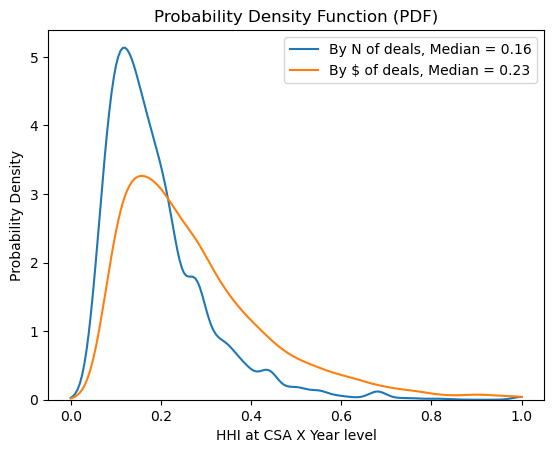

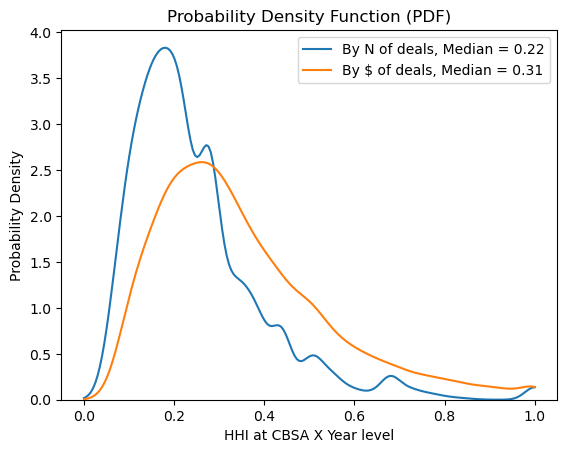

In [9]:
# By CSA

sns.kdeplot(HHI_byCSA[HHI_byCSA['N_Deals']>=5]['hhi_by_N'],clip=[0,1],
    label='By N of deals, Median = '+f"{(np.median(HHI_byCSA[HHI_byCSA['N_Deals']>=5]['hhi_by_N'])):.2f}")
sns.kdeplot(HHI_byCSA[HHI_byCSA['N_Deals']>=5]['hhi_by_Dollar'],clip=[0,1],
    label='By $ of deals, Median = '+f"{(np.median(HHI_byCSA[HHI_byCSA['N_Deals']>=5]['hhi_by_Dollar'])):.2f}")
plt.xlabel('HHI at CSA X Year level')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF)')
plt.legend()
plt.show()

# By CBSA

sns.kdeplot(HHI_byCBSA[HHI_byCBSA['N_Deals']>=5]['hhi_by_N'],clip=[0,1],
    label='By N of deals, Median = '+f"{(np.median(HHI_byCBSA[HHI_byCBSA['N_Deals']>=5]['hhi_by_N'])):.2f}")
sns.kdeplot(HHI_byCBSA[HHI_byCBSA['N_Deals']>=5]['hhi_by_Dollar'],clip=[0,1],
    label='By $ of deals, Median = '+f"{(np.median(HHI_byCBSA[HHI_byCBSA['N_Deals']>=5]['hhi_by_Dollar'])):.2f}")
plt.xlabel('HHI at CBSA X Year level')
plt.ylabel('Probability Density')
plt.title('Probability Density Function (PDF)')
plt.legend()
plt.show()


#### **Import M&A**

In [10]:
MA = pd.read_parquet('../CleanData/SDC/M&A.parquet')
MA = MA.reset_index(drop=True)

#### **Import quantity**

In [11]:
StateXCountyXBid = pd.read_parquet("../CleanData/SDC/StateXCountyXBid.parquet")
StateXCountyXUsageBB = pd.read_parquet("../CleanData/SDC/StateXCountyXUsageBB.parquet")
StateXCountyXUsageGeneral = pd.read_parquet("../CleanData/SDC/StateXCountyXUsageGeneral.parquet")
StateXCountyXUsageMain = pd.read_parquet("../CleanData/SDC/StateXCountyXUsageMain.parquet")
StateXCountyXIssuerType = pd.read_parquet("../CleanData/SDC/StateXCountyXIssuerType.parquet")

StateXCounty = StateXCountyXBid.groupby(['State','County','sale_year']).agg({'amount':sum})
StateXCounty = StateXCounty.reset_index()

#### **Determine if a county is within CSA/CBSA**

In [12]:
# Whether a county is in a CSA/CBSA
all_counties = pd.read_csv("../RawData/MSA/fips-by-state.csv",sep=',',encoding="ISO-8859-1",low_memory=False)
all_counties = all_counties.rename(columns={'name':'County','state':'State'})
all_counties['County'] = all_counties['County'].str.upper()
all_counties['County'] = all_counties['County'].str.replace(' COUNTY','')
all_counties['County'] = all_counties['County'].str.replace(' AND ',' & ')
all_counties['County'] = all_counties['County'].str.replace('.','',regex=False)

all_counties = all_counties.merge(CBSAData,on=['County','State'],how='outer',indicator=True)
all_counties = all_counties[all_counties['_merge']!='right_only']
all_counties['if_county_is_CSA'] = ~pd.isnull(all_counties['CSA Code'])
all_counties['if_county_is_CBSA'] = all_counties['_merge']=='both'
all_counties = all_counties[['State','County','if_county_is_CBSA','if_county_is_CSA']]

In [13]:
CSA_POP = pd.read_csv("../RawData/MSA/POP/CSA_POP.csv")
CSA_INC = pd.read_csv("../RawData/MSA/CAINC1/CSA_INC.csv")
CBSA_POP = pd.read_csv("../RawData/MSA/POP/CBSA_POP.csv")
CBSA_INC = pd.read_csv("../RawData/MSA/CAINC1/CBSA_INC.csv")


# 2. Sample description & Correlation

**Summary stats of the sample**

In [14]:
##################################
# Summary stats on number of M&A #
##################################

# Total number of M&As
n_MA = len(MA)

name_GPF_colnames = [column for column in GPF.columns if column[:9]=='name_GPF_']
parent_name_GPF_colnames = [column for column in GPF.columns if 'parent_name_' in column]

MA['both_active'] = False
MA['both_active_overlap_CSA'] = False

# M&As where both underwrite municipal bonds right before merger
for idx,row in MA.iterrows():
    GPF_oneyear = GPF[GPF['sale_year']==row['sale_year']-1]
    names = list(chain.from_iterable(list(np.array(GPF_oneyear[name_GPF_colnames]))))
    names = list(set(names))
    parent_names = list(chain.from_iterable(list(np.array(GPF_oneyear[parent_name_GPF_colnames]))))
    parent_names = list(set(parent_names))
    if (row['target'] in names or row['target'] in parent_names) and \
        (row['acquiror'] in names or row['acquiror'] in parent_names):
        MA.at[idx,'both_active'] = True

# M&As where both underwirte municipal bonds before merger and have market overlap in terms of CSA
for idx,row in MA.iterrows():
    GPF_oneyear = GPF[GPF['sale_year']==row['sale_year']-1]
    CSAs = list(GPF_oneyear['CSA Code'].unique())
    CSAs = [item for item in CSAs if str(item)!='nan']
    for CSA in CSAs:
        GPF_oneyearCSA = GPF_oneyear[GPF_oneyear['CSA Code']==CSA]
        names = list(chain.from_iterable(list(np.array(GPF_oneyearCSA[name_GPF_colnames]))))
        names = list(set(names))
        parent_names = list(chain.from_iterable(list(np.array(GPF_oneyearCSA[parent_name_GPF_colnames]))))
        parent_names = list(set(parent_names))
        # If for any CSA there is overlap, then there is overlap
        if (row['target'] in names or row['target'] in parent_names) and \
            (row['acquiror'] in names or row['acquiror'] in parent_names):
            MA.at[idx,'both_active_overlap_CSA'] = True

n_MA_both_active = np.sum(MA['both_active']==True)
n_MA_both_active_overlap_CSA = np.sum(MA['both_active_overlap_CSA']==True)

latex_table = ""
formatted_row = "\\# of M\\&As"+"&"+f"{n_MA:.0f}"+"\\\\\n"
latex_table += formatted_row
formatted_row = "\\# of M\\&As, both sides active"+"&"+f"{n_MA_both_active:.0f}"+"\\\\\n"
latex_table += formatted_row
formatted_row = "\\# of M\\&As, both sides active and with CSA overlap"+"&"+f"{n_MA_both_active_overlap_CSA:.0f}"+"\\\\\n"
latex_table += formatted_row
with open("../Slides/tabs/sum_stats_MA.tex", "w") as file:
    file.write(latex_table)

In [15]:
# Number: Number of M&As where both sides are active #
with open('../Slides/nums/n_MA_both_active.tex','w') as file:
    file.write(str(n_MA_both_active))

# Number: Number of M&As where both sides are active and have geographic overlap #
with open('../Slides/nums/n_MA_both_active_overlap_CSA.tex','w') as file:
    file.write(str(n_MA_both_active_overlap_CSA))


**Statistics on withdrawn M\&As**

In [16]:
MA_withdrawn = pd.read_csv("../RawData/SDC/MA_withdrawn.csv")
MA_withdrawn = MA_withdrawn.rename(columns={'announce_year':'sale_year'})[['target','acquiror','sale_year']]

name_GPF_colnames = [column for column in GPF.columns if column[:9]=='name_GPF_']
parent_name_GPF_colnames = [column for column in GPF.columns if 'parent_name_' in column]

MA_withdrawn['both_active'] = False
MA_withdrawn['both_active_overlap_CSA'] = False

# M&As where both underwrite municipal bonds right before merger
for idx,row in MA_withdrawn.iterrows():
    GPF_oneyear = GPF[GPF['sale_year']==row['sale_year']-1]
    names = list(chain.from_iterable(list(np.array(GPF_oneyear[name_GPF_colnames]))))
    names = list(set(names))
    parent_names = list(chain.from_iterable(list(np.array(GPF_oneyear[parent_name_GPF_colnames]))))
    parent_names = list(set(parent_names))
    if (row['target'] in names or row['target'] in parent_names) and \
        (row['acquiror'] in names or row['acquiror'] in parent_names):
        MA_withdrawn.at[idx,'both_active'] = True

# M&As where both underwirte municipal bonds before merger and have market overlap in terms of CSA
for idx,row in MA_withdrawn.iterrows():
    GPF_oneyear = GPF[GPF['sale_year']==row['sale_year']-1]
    CSAs = list(GPF_oneyear['CSA Code'].unique())
    CSAs = [item for item in CSAs if str(item)!='nan']
    for CSA in CSAs:
        GPF_oneyearCSA = GPF_oneyear[GPF_oneyear['CSA Code']==CSA]
        names = list(chain.from_iterable(list(np.array(GPF_oneyearCSA[name_GPF_colnames]))))
        names = list(set(names))
        parent_names = list(chain.from_iterable(list(np.array(GPF_oneyearCSA[parent_name_GPF_colnames]))))
        parent_names = list(set(parent_names))
        # If for any CSA there is overlap, then there is overlap
        if (row['target'] in names or row['target'] in parent_names) and \
            (row['acquiror'] in names or row['acquiror'] in parent_names):
            MA_withdrawn.at[idx,'both_active_overlap_CSA'] = True



In [17]:
n_MA_withdrawn_both_active = np.sum(MA_withdrawn['both_active']==True)
n_MA_withdrawn_both_active_overlap_CSA = np.sum(MA_withdrawn['both_active_overlap_CSA']==True)

# Number: Number of M&As where both sides are active #
with open('../Slides/nums/n_MA_withdrawn_both_active.tex','w') as file:
    file.write(str(n_MA_withdrawn_both_active))

# Number: Number of M&As where both sides are active and have geographic overlap #
with open('../Slides/nums/n_MA_withdrawn_both_active_overlap_CSA.tex','w') as file:
    file.write(str(n_MA_withdrawn_both_active_overlap_CSA))


# 3. Plot variables around underwriter M&A

## 3.1 By CSA

### 3.1.1. Find CSA X Year affected by merger

In [74]:
CSA_affected = pd.read_parquet('../CleanData/MAEvent/CSA_affected.parquet')

In [19]:
%%script false --no-raise-error

# %%time

# Go over each merger. Check the CSAs affected by the merger (i.e., either side has business in the CSA in the year prior 
# to the merger). Check if the merger affects just one underwriter or affects multiple underwriters in this CSA.

# Note that for the column "market share of other targets", the optimal object to put there is the market share of the other target
# alone. Here I am instead putting in market share of the other target's parent. This should make a minimal difference.

def proc_list(MA_frag):
    
    name_GPF_colnames = ['name_GPF_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
    parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
    
    CSA_affected = []
    MA_frag = MA_frag.reset_index(drop=True)
    
    for idx,row in MA_frag.iterrows():
        
        # Find CSAs that this merger affects
        # Determine if an underwriter is active in an CSA based on activity of PRIOR years
        GPF_prioryears = GPF[(GPF['sale_year']>=row['sale_year']-3)&(GPF['sale_year']<=row['sale_year']-1)]

        # Also check other targets of the acquiror in that year. This accounts for cases where post merger the new formed entity
        # is new and appear as a name that was not in the sample before. Note that here "MA_frag" cannot be used or the other firm
        # involved in the merger will be missed. Instead, use the whole sample "MA"
        other_targets = \
            list(MA[(MA['acquiror']==row['acquiror'])&
            (MA['sale_year']==row['sale_year'])&
            (MA['target']!=row['target'])]['target'])
        
        for CSA in list(GPF_prioryears['CSA Code'].unique()):

            GPF_prioryears_oneCSA = GPF_prioryears[GPF_prioryears['CSA Code']==CSA]

            # Underwriters in this state
            underwriters_priorMA = list(chain.from_iterable(list(np.array(GPF_prioryears_oneCSA[name_GPF_colnames]))))
            underwriters_priorMA = [item for item in underwriters_priorMA if item!=None]
            underwriters_priorMA = list(set(underwriters_priorMA))
            # Parents of underwriters in this state
            parents_priorMA = list(chain.from_iterable(list(np.array(GPF_prioryears_oneCSA[parent_name_colnames]))))
            parents_priorMA = [item for item in parents_priorMA if item!=None]
            parents_priorMA = list(set(parents_priorMA))
            # Subsidiaries of parents in this state (using data of PRIOR year)
            subsidiaries_priorMA = list(GPF_names[
                (GPF_names['parent_name'].isin(parents_priorMA))&
                (GPF_names['sale_year']>=row['sale_year']-3)&
                (GPF_names['sale_year']<=row['sale_year']-1)]['name_GPF'])

            # Determine if merger affects the CSA, and if both sides have business
            IF_acquiror_active = None
            IF_target_active = None
            IF_other_target_active = None
            if (row['acquiror'] in parents_priorMA) or (row['acquiror'] in underwriters_priorMA) or (row['acquiror'] in subsidiaries_priorMA):
                IF_acquiror_active = True
            if (row['target'] in parents_priorMA) or (row['target'] in underwriters_priorMA) or (row['target'] in subsidiaries_priorMA):
                IF_target_active = True
            for other_target in other_targets:
                if (other_target in parents_priorMA) or (other_target in underwriters_priorMA):
                    IF_other_target_active = True

            # Get market share of merged banks. Note that this is the market share in the years prior to M&A. Also note that market 
            # share "market_share_all_markets_byCSA" is calculated at the parent level. There are many cases where market share of a
            # firm in an area is unavailable, which is because of no presence.



            #-------------------------#
            # Market share by N deals #
            #-------------------------#

            # (1) Market share of acquiror
            # Determine parent of target, as "market_share_all_markets_byCSA" is at parent level
            try:
                # Situation where acquiror is a subsidiary or standalone firm whose parent is itself. Extract its parent
                acquiror_parent = GPF_names[(GPF_names['name_GPF']==row['acquiror'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                # Situation where acquiror is a parent
                acquiror_parent = row['acquiror']
            try:
                acquiror_market_share_N_m1 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m1 = 0
            try:
                acquiror_market_share_N_m2 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m2 = 0
            try:
                acquiror_market_share_N_m3 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m3 = 0

            # (2) Market share of target
            try:
                # Note that I must use "GPF_names" (the parent-subsidiary) mapping use the year(s) prior to the MA
                target_parent = GPF_names[(GPF_names['name_GPF']==row['target'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                target_parent = row['target']
            try:
                target_market_share_N_m1 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m1 = 0
            try:
                target_market_share_N_m2 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m2 = 0
            try:
                target_market_share_N_m3 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m3 = 0

            # (3) Market share of other targets in the same transaction
            # Account for possibility that other targets can be either a parent or a standalone firm
            other_targets_parents = \
                list(GPF_names[(GPF_names['name_GPF'].isin(other_targets))
                &(GPF_names['sale_year']==row['sale_year']-1)]['parent_name'])+\
                list(other_targets)
            other_targets_parents = list(set(other_targets_parents))

            other_targets_market_share_N = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m1 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m1 = 0

            other_targets_market_share_N = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m2 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m2 = 0

            other_targets_market_share_N = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m3 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m3 = 0



            #------------------------#
            # Market share by dollar #
            #------------------------#

            # (1) Market share of acquiror
            # Determine parent of target, as "market_share_all_markets_byCSA" is at parent level
            try:
                # Situation where acquiror is a subsidiary or standalone firm whose parent is itself. Extract its parent
                acquiror_parent = GPF_names[(GPF_names['name_GPF']==row['acquiror'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                # Situation where acquiror is a parent
                acquiror_parent = row['acquiror']
            try:
                acquiror_market_share_Dollar_m1 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                acquiror_market_share_Dollar_m1 = 0
            try:
                acquiror_market_share_Dollar_m2 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                acquiror_market_share_Dollar_m2 = 0
            try:
                acquiror_market_share_Dollar_m3 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                acquiror_market_share_Dollar_m3 = 0

            # (2) Market share of target
            try:
                # Note that I must use "GPF_names" (the parent-subsidiary) mapping use the year(s) prior to the MA
                target_parent = GPF_names[(GPF_names['name_GPF']==row['target'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                target_parent = row['target']
            try:
                target_market_share_Dollar_m1 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                target_market_share_Dollar_m1 = 0
            try:
                target_market_share_Dollar_m2 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                target_market_share_Dollar_m2 = 0
            try:
                target_market_share_Dollar_m3 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                target_market_share_Dollar_m3 = 0

            # (3) Market share of other targets in the same transaction
            # Account for possibility that other targets can be either a parent or a standalone firm
            other_targets_parents = \
                list(GPF_names[(GPF_names['name_GPF'].isin(other_targets))
                &(GPF_names['sale_year']==row['sale_year']-1)]['parent_name'])+\
                list(other_targets)
            other_targets_parents = list(set(other_targets_parents))

            other_targets_market_share_Dollar = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]
            if len(other_targets_market_share_Dollar)>0:
                other_targets_market_share_Dollar_m1 = np.sum(other_targets_market_share_Dollar['market_share_Dollar'])
            else:
                other_targets_market_share_Dollar_m1 = 0

            other_targets_market_share_Dollar = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]
            if len(other_targets_market_share_Dollar)>0:
                other_targets_market_share_Dollar_m2 = np.sum(other_targets_market_share_Dollar['market_share_Dollar'])
            else:
                other_targets_market_share_Dollar_m2 = 0

            other_targets_market_share_Dollar = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]
            if len(other_targets_market_share_Dollar)>0:
                other_targets_market_share_Dollar_m3 = np.sum(other_targets_market_share_Dollar['market_share_Dollar'])
            else:
                other_targets_market_share_Dollar_m3 = 0



            # Record data
            if IF_acquiror_active or IF_target_active or IF_other_target_active:
                CSA_affected = CSA_affected+[{
                    'CSA Code':CSA,
                    'sale_year':row['sale_year'],
                    'acquiror':row['acquiror'],
                    'target':row['target'],
                    'other_targets':other_targets,
                    'acquiror_parent':acquiror_parent,
                    'target_parent':target_parent,
                    'acquiror_market_share_N_m1':acquiror_market_share_N_m1,
                    'acquiror_market_share_N_m2':acquiror_market_share_N_m2,
                    'acquiror_market_share_N_m3':acquiror_market_share_N_m3,
                    'target_market_share_N_m1':target_market_share_N_m1,
                    'target_market_share_N_m2':target_market_share_N_m2,
                    'target_market_share_N_m3':target_market_share_N_m3,
                    'other_targets_market_share_N_m1':other_targets_market_share_N_m1,
                    'other_targets_market_share_N_m2':other_targets_market_share_N_m2,
                    'other_targets_market_share_N_m3':other_targets_market_share_N_m3,
                    'acquiror_market_share_Dollar_m1':acquiror_market_share_Dollar_m1,
                    'acquiror_market_share_Dollar_m2':acquiror_market_share_Dollar_m2,
                    'acquiror_market_share_Dollar_m3':acquiror_market_share_Dollar_m3,
                    'target_market_share_Dollar_m1':target_market_share_Dollar_m1,
                    'target_market_share_Dollar_m2':target_market_share_Dollar_m2,
                    'target_market_share_Dollar_m3':target_market_share_Dollar_m3,
                    'other_targets_market_share_Dollar_m1':other_targets_market_share_Dollar_m1,
                    'other_targets_market_share_Dollar_m2':other_targets_market_share_Dollar_m2,
                    'other_targets_market_share_Dollar_m3':other_targets_market_share_Dollar_m3,
                }]
            acquiror_market_share_N_m1 = None
            acquiror_market_share_N_m2 = None
            acquiror_market_share_N_m3 = None
            target_market_share_N_m1 = None
            target_market_share_N_m2 = None
            target_market_share_N_m3 = None
            other_targets_market_share = None
            other_targets_market_share_N_m1 = None
            other_targets_market_share_N_m2 = None
            other_targets_market_share_N_m3 = None
            acquiror_market_share_Dollar_m1 = None
            acquiror_market_share_Dollar_m2 = None
            acquiror_market_share_Dollar_m3 = None
            target_market_share_Dollar_m1 = None
            target_market_share_Dollar_m2 = None
            target_market_share_Dollar_m3 = None
            other_targets_market_share = None
            other_targets_market_share_Dollar_m1 = None
            other_targets_market_share_Dollar_m2 = None
            other_targets_market_share_Dollar_m3 = None
    
    CSA_affected = pd.DataFrame(CSA_affected)
    return CSA_affected

MA_dd = dd.from_pandas(MA, npartitions=40)
with dask.config.set(scheduler='processes',num_workers=40):
    CSA_affected = MA_dd.map_partitions(proc_list, 
    meta=pd.DataFrame(columns=
    ['CSA Code','sale_year','acquiror','target',
    'other_targets','acquiror_parent','target_parent',
    'acquiror_market_share_N_m1','acquiror_market_share_N_m2','acquiror_market_share_N_m3',
    'target_market_share_N_m1','target_market_share_N_m2','target_market_share_N_m3',
    'other_targets_market_share_N_m1','other_targets_market_share_N_m2','other_targets_market_share_N_m3',
    'acquiror_market_share_Dollar_m1','acquiror_market_share_Dollar_m2','acquiror_market_share_Dollar_m3',
    'target_market_share_Dollar_m1','target_market_share_Dollar_m2','target_market_share_Dollar_m3',
    'other_targets_market_share_Dollar_m1','other_targets_market_share_Dollar_m2','other_targets_market_share_Dollar_m3',
    ])).compute()

# Average market share over past three years
CSA_affected['acquiror_market_share_N_avg'] = \
    (CSA_affected['acquiror_market_share_N_m1']+\
    CSA_affected['acquiror_market_share_N_m2']+\
    CSA_affected['acquiror_market_share_N_m3'])/3
CSA_affected['target_market_share_N_avg'] = \
    (CSA_affected['target_market_share_N_m1']+\
    CSA_affected['target_market_share_N_m2']+\
    CSA_affected['target_market_share_N_m3'])/3
CSA_affected['other_targets_market_share_N_avg'] = \
    (CSA_affected['other_targets_market_share_N_m1']+\
    CSA_affected['other_targets_market_share_N_m2']+\
    CSA_affected['other_targets_market_share_N_m3'])/3
CSA_affected['acquiror_market_share_Dollar_avg'] = \
    (CSA_affected['acquiror_market_share_Dollar_m1']+\
    CSA_affected['acquiror_market_share_Dollar_m2']+\
    CSA_affected['acquiror_market_share_Dollar_m3'])/3
CSA_affected['target_market_share_Dollar_avg'] = \
    (CSA_affected['target_market_share_Dollar_m1']+\
    CSA_affected['target_market_share_Dollar_m2']+\
    CSA_affected['target_market_share_Dollar_m3'])/3
CSA_affected['other_targets_market_share_Dollar_avg'] = \
    (CSA_affected['other_targets_market_share_Dollar_m1']+\
    CSA_affected['other_targets_market_share_Dollar_m2']+\
    CSA_affected['other_targets_market_share_Dollar_m3'])/3

# As this step takes significant time, export output
CSA_affected.to_parquet('../CleanData/MAEvent/CSA_affected.parquet')

### 3.1.2. Identify merger episodes

#### **Method 1: By market share**

In [20]:
#----------------------------#
# Market share by N of deals #
#----------------------------#

# Identify episodes of mergers at the CSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CSA_affected"

parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]

CSA_episodes_marketshare_N = []

for CSA in list(CSA_affected['CSA Code'].unique()):

    CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==CSA]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    episode_start_year = 1900
    years = CSA_affected_part['sale_year'].unique()
    years = sorted(years)
    for sale_year in years:
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CSA_affected_episode = CSA_affected_part[(CSA_affected_part['sale_year']>=sale_year)&(CSA_affected_part['sale_year']<=sale_year+3)]
        # When a firm acquires multiple firms, market share of other firms are in "other_targets_market_share_N_avg", so just keeping one record
        # is sufficient
        CSA_affected_episode = CSA_affected_episode.drop_duplicates(['acquiror','sale_year'])
        # Alternative aggregation methods might be more reasonable. Also, this does not account for that target tends to be smaller so threshold
        # for them should be smaller too. Even better, can compute the implied-HHI change (based on historical data) of this merger, and put threshold
        # on that, which is definitely more powerful.
        acquiror_market_share_N_avg = np.sum(CSA_affected_episode['acquiror_market_share_N_avg'])
        target_market_share_N_avg = np.sum(CSA_affected_episode['target_market_share_N_avg'])
        other_targets_market_share_N_avg = np.sum(CSA_affected_episode['other_targets_market_share_N_avg'])

        # Out of all mergers in this episode, calculate
        # (1) the max of sum of market shares of merging entities
        max_sum_share = \
            np.max(CSA_affected_episode['acquiror_market_share_N_avg']+CSA_affected_episode['target_market_share_N_avg']
                +CSA_affected_episode['other_targets_market_share_N_avg'])
        # (2) the max of min of market shares of merging entities
        max_min_share = \
            np.max(np.minimum(CSA_affected_episode['acquiror_market_share_N_avg'],
                CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']))
        # (3) the mean of sum of market shares of merging entities
        mean_sum_share = \
            np.mean(CSA_affected_episode['acquiror_market_share_N_avg']+CSA_affected_episode['target_market_share_N_avg']
                +CSA_affected_episode['other_targets_market_share_N_avg'])

        # Check if market share in the episode is high enough
        if acquiror_market_share_N_avg>0.05 and target_market_share_N_avg+other_targets_market_share_N_avg>0.05:
            # An episode is identified
            CSA_episodes_marketshare_N = CSA_episodes_marketshare_N+[{
                'episode_start_year':sale_year,
                'CSA Code':CSA,
                'mergers':CSA_affected_episode,
                'acquiror_market_share_N_avg':acquiror_market_share_N_avg,
                'target_market_share_N_avg':target_market_share_N_avg,
                'other_targets_market_share_N_avg':other_targets_market_share_N_avg,
                'max_sum_share':max_sum_share,
                'max_min_share':max_min_share,
                'mean_sum_share':mean_sum_share,
                }]
            episode_start_year = sale_year

CSA_episodes_marketshare_N = pd.DataFrame(CSA_episodes_marketshare_N)


In [21]:
len(CSA_episodes_marketshare_N)

307

#### **Method 2: By implied rise in HHI due to merger**

In [76]:
#-----------------------------#
# Change in HHI by N of deals #
#-----------------------------#

# Identify episodes of mergers at the CSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CSA_affected"

CSA_episodes_impliedHHI_N = []

for CSA in list(CSA_affected['CSA Code'].unique()):

    CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==CSA]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CSA_affected_episode = CSA_affected_part[(CSA_affected_part['sale_year']>=sale_year)&(CSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CSA Code']==CSA)]
        
        # Calculate (1) HHI (by parent firm) in the three years prior (2) Predicted HHI after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # HHI prior to merger
        hhi_piror = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)

        # Implied HHI post merger
        CSA_affected_episode = CSA_affected_episode.reset_index(drop=True)
        for idx,row in CSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        hhi_predicted = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)
        n_deals_post = n_deals

        hhi_dif = hhi_predicted-hhi_piror

        # Market shares used in summary statistics
        CSA_affected_episode['min_share'] = np.minimum(CSA_affected_episode['acquiror_market_share_N_avg'],
            CSA_affected_episode['target_market_share_N_avg']+\
            CSA_affected_episode['other_targets_market_share_N_avg'])
        CSA_affected_episode = CSA_affected_episode.sort_values('min_share')
        CSA_affected_episode_topshare = CSA_affected_episode[-1:]
        acquiror_market_share_N_max = np.max(CSA_affected_episode_topshare['acquiror_market_share_N_avg'])
        target_market_share_N_max = np.max(CSA_affected_episode_topshare['target_market_share_N_avg'])
        other_targets_market_share_N_max = np.max(CSA_affected_episode_topshare['other_targets_market_share_N_avg'])

        # Check if market share in the episode is high enough
        if hhi_dif>0.01:
            # An episode is identified
            CSA_episodes_impliedHHI_N = CSA_episodes_impliedHHI_N+[{
                'episode_start_year':sale_year,
                'CSA Code':CSA,
                'mergers':CSA_affected_episode,
                'hhi_dif':hhi_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CSA_episodes_impliedHHI_N = pd.DataFrame(CSA_episodes_impliedHHI_N)


In [77]:
# Data for summary stats
CSA_episodes_impliedHHI_N[['episode_start_year','CSA Code','hhi_dif',
    'acquiror_market_share_N_max','target_market_share_N_max','other_targets_market_share_N_max']].\
    to_csv('../CleanData/MAEvent/CSA_episodes_impliedHHI_SumStats.csv')

In [78]:
len(CSA_episodes_impliedHHI_N)

220

#### **Method 3: By implied rise in top 5 share due to merger**

In [25]:
#-------------------------------------#
# Change in top 5 share by N of deals #
#-------------------------------------#

# Identify episodes of mergers at the CSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CSA_affected"

CSA_episodes_top5share_N = []

for CSA in list(CSA_affected['CSA Code'].unique()):

    CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==CSA]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CSA_affected_episode = CSA_affected_part[(CSA_affected_part['sale_year']>=sale_year)&(CSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CSA Code']==CSA)]
        
        # Calculate (1) Top 5 share (by parent firm) in the three years prior (2) Predicted top 5 share after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # Top 5 share prior to merger
        n_deals['marketshare'] = n_deals['n_deals']/np.sum(n_deals['n_deals'])
        n_deals = n_deals.sort_values(by=['n_deals'],ascending=False).reset_index(drop=True)
        if len(n_deals)<=5:
            top5share_prior = 1
        else:
            top5share_prior = np.sum(n_deals['marketshare'][:5])

        # Implied top 5 share post merger
        CSA_affected_episode = CSA_affected_episode.reset_index(drop=True)
        for idx,row in CSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        n_deals['marketshare'] = n_deals['n_deals']/np.sum(n_deals['n_deals'])
        n_deals = n_deals.sort_values(by=['n_deals'],ascending=False).reset_index(drop=True)
        if len(n_deals)<=5:
            top5share_post = 1
        else:
            top5share_post = np.sum(n_deals['marketshare'][:5])
        n_deals_post = n_deals

        top5share_dif = top5share_post-top5share_prior

        # Market shares used in summary statistics
        CSA_affected_episode['min_share'] = np.minimum(CSA_affected_episode['acquiror_market_share_N_avg'],
            CSA_affected_episode['target_market_share_N_avg']+\
            CSA_affected_episode['other_targets_market_share_N_avg'])
        CSA_affected_episode = CSA_affected_episode.sort_values('min_share')
        CSA_affected_episode_topshare = CSA_affected_episode[-1:]
        acquiror_market_share_N_max = np.max(CSA_affected_episode_topshare['acquiror_market_share_N_avg'])
        target_market_share_N_max = np.max(CSA_affected_episode_topshare['target_market_share_N_avg'])
        other_targets_market_share_N_max = np.max(CSA_affected_episode_topshare['other_targets_market_share_N_avg'])

        # Check if market share in the episode is high enough
        if top5share_dif>0.05:
            # An episode is identified
            CSA_episodes_top5share_N = CSA_episodes_top5share_N+[{
                'episode_start_year':sale_year,
                'CSA Code':CSA,
                'mergers':CSA_affected_episode,
                'top5share_dif':top5share_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CSA_episodes_top5share_N = pd.DataFrame(CSA_episodes_top5share_N)


In [26]:
len(CSA_episodes_top5share_N)

167

#### **Export a table of M&As used**

In [27]:
# Export a table of M&As used
MAs_Used = []
for idx,row in CSA_episodes_impliedHHI_N.iterrows():
    MAs_Used = MAs_Used+[row['mergers'][['acquiror','target','sale_year']]]
MAs_Used = pd.concat(MAs_Used).drop_duplicates()
MAs_Used = MAs_Used.sort_values(['sale_year','acquiror'])
MAs_Used = MAs_Used.reset_index(drop=True)
MAs_Used['acquiror'] = MAs_Used['acquiror'].str.replace('&','\\&')
MAs_Used['target'] = MAs_Used['target'].str.replace('&','\\&')

# MA_SDC = pd.read_csv('SCRIPT_SDC_deals_cleaned.csv')
# MAs_Used = MAs_Used.merge(MA_SDC,on=['target','acquiror','sale_year'],how='outer',indicator=True)
# MAs_Used = MAs_Used[MAs_Used['_merge']=='left_only']
# MAs_Used = MAs_Used.drop(columns=['_merge'])

# Adjusting the format
MAs_Used['sale_year'] = MAs_Used['sale_year'].astype(int)
MAs_Used = MAs_Used.rename(columns={'acquiror':'Acquiror','target':'Target','sale_year':'Year'})
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('SHEARSONAMERICAN EXPRESS','SHEARSON/AMERICAN EXPRESS')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('SHEARSONAMERICAN EXPRESS','SHEARSON/AMERICAN EXPRESS')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.title()
MAs_Used['Target'] = MAs_Used['Target'].str.title()
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace(' Of ',' of ')
MAs_Used['Target'] = MAs_Used['Target'].str.replace(' Of ',' of ')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Ag Becker','AG Becker')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Ag Becker','AG Becker')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace("American Ntnl Bank \\& Tr","American National Bank \\& Trust",regex=False)
MAs_Used['Target'] = MAs_Used['Target'].str.replace("American Ntnl Bank \\& Tr","American National Bank \\& Trust",regex=False)
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Mcdonald','McDonald')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Mcdonald','McDonald')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Pnc Bank','PNC Bank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Pnc Bank','PNC Bank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Us Bank','US Bank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Us Bank','US Bank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Onbank','OnBank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Onbank','OnBank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Bb\\&T','BB\\&T',regex=False)
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Bb\\&T','BB\\&T',regex=False)
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Bok Financial','BOK Financial')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Bok Financial','BOK Financial')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Ubs Financial Services','UBS Financial Services')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Ubs Financial Services','UBS Financial Services')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Bb\\&T','BB\\&T',regex=False)
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Bb\\&T','BB\\&T',regex=False)
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Natwest Bank','NatWest Bank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Natwest Bank','NatWest Bank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('West One Bank Oregon Sb','West One Bank Oregon')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('West One Bank Oregon Sb','West One Bank Oregon')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Johnston Brown Barnett\\&Knight','Johnston Brown Barnett \\& Knight',regex=False)
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Johnston Brown Barnett\\&Knight','Johnston Brown Barnett \\& Knight',regex=False)
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Jp Morgan','JP Morgan')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Jp Morgan','JP Morgan')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Rbc Bank','RBC Bank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Rbc Bank','RBC Bank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Suntrust Bank','SunTrust Bank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Suntrust Bank','SunTrust Bank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Rrz Public Markets','RRZ Public Markets')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Rrz Public Markets','RRZ Public Markets')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Interstatejohnson Lane','Interstate/Johnson Lane',regex=False)
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Interstatejohnson Lane','Interstate/Johnson Lane',regex=False)
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Nationsbank','NationsBank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Nationsbank','NationsBank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Bankboston','BankBoston')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Bankboston','BankBoston')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Nbc Capital Markets Group','NBC Capital Markets Group')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Nbc Capital Markets Group','NBC Capital Markets Group')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Southtrust Securities','SouthTrust Securities')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Southtrust Securities','SouthTrust Securities')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Td Bank','TD Bank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Td Bank','TD Bank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Nationsbank','NationsBank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Nationsbank','NationsBank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Seattle Northwest Sec','Seattle Northwest Securities')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Seattle Northwest Sec','Seattle Northwest Securities')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Bmo Bank','BMO Bank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Bmo Bank','BMO Bank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Stonex Group','StoneX Group')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Stonex Group','StoneX Group')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Nbh Bank','NBH Bank')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Nbh Bank','NBH Bank')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Jjb Hilliard Wl Lyons','JJB Hilliard WL Lyons')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Jjb Hilliard Wl Lyons','JJB Hilliard WL Lyons')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Lj Hart','LJ Hart')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Lj Hart','LJ Hart')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Bbva Compass','BBVA Compass')
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Bbva Compass','BBVA Compass')
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Peoples United Bank',"People's United Bank")
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Peoples United Bank',"People's United Bank")
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Peoples National Bank',"People's National Bank")
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Peoples National Bank',"People's National Bank")
MAs_Used['Acquiror'] = MAs_Used['Acquiror'].str.replace('Tgh Securities',"TGH Securities")
MAs_Used['Target'] = MAs_Used['Target'].str.replace('Tgh Securities',"TGH Securities")

MAs_Used_part1 = MAs_Used[:45]
MAs_Used_part2 = MAs_Used[45:90]
MAs_Used_part3 = MAs_Used[90:135]
MAs_Used_part4 = MAs_Used[135:]

latex_table = MAs_Used_part1.style.hide(axis="index").to_latex(hrules=True)
with open('../Slides/tabs/MAs_Used_part1.tex', 'w') as f:
    f.write(latex_table)

latex_table = MAs_Used_part2.style.hide(axis="index").to_latex(hrules=True)
with open('../Slides/tabs/MAs_Used_part2.tex', 'w') as f:
    f.write(latex_table)

latex_table = MAs_Used_part3.style.hide(axis="index").to_latex(hrules=True)
with open('../Slides/tabs/MAs_Used_part3.tex', 'w') as f:
    f.write(latex_table)

latex_table = MAs_Used_part4.style.hide(axis="index").to_latex(hrules=True)
with open('../Slides/tabs/MAs_Used_part4.tex', 'w') as f:
    f.write(latex_table)


#### **Placebo test: Find an area that is not affected by within-market merger**

In [28]:
#####################
# Randomly pick one #
#####################

# Fix random seed
np.random.seed(123)

CSA_episodes_impliedHHI_AcrossMarket = []

for idx,row in CSA_episodes_impliedHHI_N.iterrows():

    # Find the "representative" single M&A of this episode
    mergers = row['mergers']
    mergers['min_share'] = np.minimum(mergers['acquiror_market_share_N_avg'],
        mergers['target_market_share_N_avg']+\
        mergers['other_targets_market_share_N_avg'])
    mergers = mergers.sort_values('min_share')
    repre_merger = mergers[-1:].reset_index(drop=True)

    # Find a placebo CSA for both treated and control

    #---------------------#
    # First, for acquiror #
    #---------------------#
    
    # Get other CSAs where involved firm has market share>10% (a flexible threshold)
    market_share = market_share_all_markets_byCSA[
        (market_share_all_markets_byCSA['parent_name']==repre_merger['acquiror_parent'][0])&
        (market_share_all_markets_byCSA['calendar_year']<=repre_merger['sale_year'][0])&
        (market_share_all_markets_byCSA['calendar_year']>=repre_merger['sale_year'][0]-3)
        ].sort_values(['CSA Code','calendar_year'])
    market_share = market_share.groupby(['CSA Code']).agg({'market_share_N':'mean'}).reset_index()
    market_share = market_share[market_share['market_share_N']>0.1]

    # Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
    market_share['if_also_withinMA'] = False
    for sub_idx,sub_row in market_share.iterrows():

        # M&As in a candidate placebo CSA in [-4,+4]
        CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['acquiror_market_share_N_avg']>0)&
            ((CSA_affected_part['target_market_share_N_avg']>0)|
            (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
        # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
            (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
            ]
        CSA_affected_episode = CSA_affected_part.copy()
        CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
            (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
        if len(CSA_affected_episode)>0:
            market_share.at[sub_idx,'if_also_withinMA'] = True

    market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
    # Randomly pick such a CSA. If there are too many potential candidates, narrow the thresholds above
    if len(market_share)>0:
        market_share = market_share[np.logical_not(market_share['if_also_withinMA'])]
        if len(market_share)>0:
            CSA_episodes_impliedHHI_AcrossMarket = CSA_episodes_impliedHHI_AcrossMarket+\
                [{'CSA Code':np.random.choice(market_share['CSA Code']),'episode_start_year':repre_merger['sale_year'][0]}]

    #------------------#
    # Next, for target #
    #------------------#
    
    # Get other CSAs where involved firm has market share>10% (a flexible threshold)
    market_share = market_share_all_markets_byCSA[
        (market_share_all_markets_byCSA['parent_name']==repre_merger['target_parent'][0])&
        (market_share_all_markets_byCSA['calendar_year']<=repre_merger['sale_year'][0])&
        (market_share_all_markets_byCSA['calendar_year']>=repre_merger['sale_year'][0]-3)
        ].sort_values(['CSA Code','calendar_year'])
    market_share = market_share.groupby(['CSA Code']).agg({'market_share_N':'mean'}).reset_index()
    market_share = market_share[market_share['market_share_N']>0.1]

    # Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
    market_share['if_also_withinMA'] = False
    for sub_idx,sub_row in market_share.iterrows():

        # M&As in a candidate placebo CSA in [-4,+4]
        CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['acquiror_market_share_N_avg']>0)&
            ((CSA_affected_part['target_market_share_N_avg']>0)|
            (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
        # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
            (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
            ]
        CSA_affected_episode = CSA_affected_part.copy()
        CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
            (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
        if len(CSA_affected_episode)>0:
            market_share.at[sub_idx,'if_also_withinMA'] = True

    market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
    # Randomly pick such a CSA. If there are too many potential candidates, narrow the thresholds above
    if len(market_share)>0:
        market_share = market_share[np.logical_not(market_share['if_also_withinMA'])]
        if len(market_share)>0:
            CSA_episodes_impliedHHI_AcrossMarket = CSA_episodes_impliedHHI_AcrossMarket+\
                [{'CSA Code':np.random.choice(market_share['CSA Code']),'episode_start_year':repre_merger['sale_year'][0]}]

CSA_episodes_impliedHHI_AcrossMarket = pd.DataFrame(CSA_episodes_impliedHHI_AcrossMarket)

In [29]:
len(CSA_episodes_impliedHHI_AcrossMarket)

339

In [30]:
len(CSA_episodes_impliedHHI_AcrossMarket)

339

In [31]:
#####################################################
# Randomly pick one, without requiring market share #
#####################################################

# Fix random seed
np.random.seed(123)

CSA_episodes_impliedHHI_AcrossMarket_AnyShare = []

for idx,row in CSA_episodes_impliedHHI_N.iterrows():

    # Find the "representative" single M&A of this episode
    mergers = row['mergers']
    mergers['min_share'] = np.minimum(mergers['acquiror_market_share_N_avg'],
        mergers['target_market_share_N_avg']+\
        mergers['other_targets_market_share_N_avg'])
    mergers = mergers.sort_values('min_share')
    repre_merger = mergers[-1:].reset_index(drop=True)

    # Find a placebo CSA for both treated and control

    #---------------------#
    # First, for acquiror #
    #---------------------#
    
    # Get other CSAs where involved firm has market share>0% (a flexible threshold)
    market_share = market_share_all_markets_byCSA[
        (market_share_all_markets_byCSA['parent_name']==repre_merger['acquiror_parent'][0])&
        (market_share_all_markets_byCSA['calendar_year']<=repre_merger['sale_year'][0])&
        (market_share_all_markets_byCSA['calendar_year']>=repre_merger['sale_year'][0]-3)
        ].sort_values(['CSA Code','calendar_year'])
    market_share = market_share.groupby(['CSA Code']).agg({'market_share_N':'mean'}).reset_index()
    market_share = market_share[market_share['market_share_N']>0]

    # Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
    market_share['if_also_withinMA'] = False
    for sub_idx,sub_row in market_share.iterrows():

        # M&As in a candidate placebo CSA in [-4,+4]
        CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['acquiror_market_share_N_avg']>0)&
            ((CSA_affected_part['target_market_share_N_avg']>0)|
            (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
        # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
            (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
            ]
        CSA_affected_episode = CSA_affected_part.copy()
        CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
            (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
        if len(CSA_affected_episode)>0:
            market_share.at[sub_idx,'if_also_withinMA'] = True

    market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
    # Randomly pick such a CSA. If there are too many potential candidates, narrow the thresholds above
    if len(market_share)>0:
        market_share = market_share[np.logical_not(market_share['if_also_withinMA'])]
        if len(market_share)>0:
            CSA_episodes_impliedHHI_AcrossMarket_AnyShare = CSA_episodes_impliedHHI_AcrossMarket_AnyShare+\
                [{'CSA Code':np.random.choice(market_share['CSA Code']),'episode_start_year':repre_merger['sale_year'][0]}]

    #------------------#
    # Next, for target #
    #------------------#
    
    # Get other CSAs where involved firm has market share>0% (a flexible threshold)
    market_share = market_share_all_markets_byCSA[
        (market_share_all_markets_byCSA['parent_name']==repre_merger['target_parent'][0])&
        (market_share_all_markets_byCSA['calendar_year']<=repre_merger['sale_year'][0])&
        (market_share_all_markets_byCSA['calendar_year']>=repre_merger['sale_year'][0]-3)
        ].sort_values(['CSA Code','calendar_year'])
    market_share = market_share.groupby(['CSA Code']).agg({'market_share_N':'mean'}).reset_index()
    market_share = market_share[market_share['market_share_N']>0]

    # Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
    market_share['if_also_withinMA'] = False
    for sub_idx,sub_row in market_share.iterrows():

        # M&As in a candidate placebo CSA in [-4,+4]
        CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['acquiror_market_share_N_avg']>0)&
            ((CSA_affected_part['target_market_share_N_avg']>0)|
            (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
        # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
            (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
            ]
        CSA_affected_episode = CSA_affected_part.copy()
        CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
            (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
        if len(CSA_affected_episode)>0:
            market_share.at[sub_idx,'if_also_withinMA'] = True

    market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
    # Randomly pick such a CSA. If there are too many potential candidates, narrow the thresholds above
    if len(market_share)>0:
        market_share = market_share[np.logical_not(market_share['if_also_withinMA'])]
        if len(market_share)>0:
            CSA_episodes_impliedHHI_AcrossMarket_AnyShare = CSA_episodes_impliedHHI_AcrossMarket_AnyShare+\
                [{'CSA Code':np.random.choice(market_share['CSA Code']),'episode_start_year':repre_merger['sale_year'][0]}]

CSA_episodes_impliedHHI_AcrossMarket_AnyShare = pd.DataFrame(CSA_episodes_impliedHHI_AcrossMarket_AnyShare)

In [32]:
len(CSA_episodes_impliedHHI_AcrossMarket_AnyShare)

380

In [33]:
#########################################
# Pick one with closest population size #
#########################################

CSA_episodes_impliedHHI_AcrossMarket_SamePop = []

for idx,row in CSA_episodes_impliedHHI_N.iterrows():

    # Find the "representative" single M&A of this episode
    mergers = row['mergers']
    mergers['min_share'] = np.minimum(mergers['acquiror_market_share_N_avg'],
        mergers['target_market_share_N_avg']+\
        mergers['other_targets_market_share_N_avg'])
    mergers = mergers.sort_values('min_share')
    repre_merger = mergers[-1:].reset_index(drop=True)

    # Find a placebo CSA for both treated and control

    #---------------------#
    # First, for acquiror #
    #---------------------#
    
    # Get other CSAs where involved firm has market share>10% (a flexible threshold)
    market_share = market_share_all_markets_byCSA[
        (market_share_all_markets_byCSA['parent_name']==repre_merger['acquiror_parent'][0])&
        (market_share_all_markets_byCSA['calendar_year']<=repre_merger['sale_year'][0])&
        (market_share_all_markets_byCSA['calendar_year']>=repre_merger['sale_year'][0]-3)
        ].sort_values(['CSA Code','calendar_year'])
    market_share = market_share.groupby(['CSA Code']).agg({'market_share_N':'mean'}).reset_index()
    market_share = market_share[market_share['market_share_N']>0.1]

    # Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
    market_share['if_also_withinMA'] = False
    for sub_idx,sub_row in market_share.iterrows():

        # M&As in a candidate placebo CSA in [-4,+4]
        CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['acquiror_market_share_N_avg']>0)&
            ((CSA_affected_part['target_market_share_N_avg']>0)|
            (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
        # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
            (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
            ]
        CSA_affected_episode = CSA_affected_part.copy()
        CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
            (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
        if len(CSA_affected_episode)>0:
            market_share.at[sub_idx,'if_also_withinMA'] = True

    market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
    # Randomly pick such a CSA. If there are too many potential candidates, narrow the thresholds above
    if len(market_share)>0:
        market_share = market_share[np.logical_not(market_share['if_also_withinMA'])]
        # Get dif. in population size
        market_share = market_share.copy()
        market_share['year'] = repre_merger['sale_year'][0]
        market_share['focal_CSA'] = row['CSA Code']
        market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
        market_share = market_share.merge(CSA_POP[['year','CSA Code','pop']],on=['CSA Code','year'])
        market_share = market_share.rename(columns={'pop':'pop_candidate'})
        market_share = market_share.merge(CSA_POP[['year','CSA Code','pop']].\
            rename(columns={'CSA Code':'focal_CSA'}),on=['focal_CSA','year'])
        market_share = market_share.rename(columns={'pop':'pop_focal'})
        market_share['pop_diff'] = np.absolute(market_share['pop_focal']-market_share['pop_candidate'])
        market_share = market_share.sort_values(['pop_diff']).reset_index(drop=True)
        # Drop if difference is too big
        # market_share['pop_diff_ratio'] = market_share['pop_diff']/market_share['pop_focal']
        # market_share = market_share[market_share['pop_diff_ratio']<0.5]
        if len(market_share)>0:
            CSA_episodes_impliedHHI_AcrossMarket_SamePop = CSA_episodes_impliedHHI_AcrossMarket_SamePop+\
                [{'CSA Code':market_share['CSA Code'][0],'episode_start_year':repre_merger['sale_year'][0]}]

    #------------------#
    # Next, for target #
    #------------------#
    
    # Get other CSAs where involved firm has market share>10% (a flexible threshold)
    market_share = market_share_all_markets_byCSA[
        (market_share_all_markets_byCSA['parent_name']==repre_merger['target_parent'][0])&
        (market_share_all_markets_byCSA['calendar_year']<=repre_merger['sale_year'][0])&
        (market_share_all_markets_byCSA['calendar_year']>=repre_merger['sale_year'][0]-3)
        ].sort_values(['CSA Code','calendar_year'])
    market_share = market_share.groupby(['CSA Code']).agg({'market_share_N':'mean'}).reset_index()
    market_share = market_share[market_share['market_share_N']>0.1]

    # Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
    market_share['if_also_withinMA'] = False
    for sub_idx,sub_row in market_share.iterrows():

        # M&As in a candidate placebo CSA in [-4,+4]
        CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['acquiror_market_share_N_avg']>0)&
            ((CSA_affected_part['target_market_share_N_avg']>0)|
            (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
        # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
            (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
            ]
        CSA_affected_episode = CSA_affected_part.copy()
        CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
            (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
        if len(CSA_affected_episode)>0:
            market_share.at[sub_idx,'if_also_withinMA'] = True

    market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
    # Randomly pick such a CSA. If there are too many potential candidates, narrow the thresholds above
    if len(market_share)>0:
        market_share = market_share[np.logical_not(market_share['if_also_withinMA'])]
        # Get dif. in population size
        market_share = market_share.copy()
        market_share['year'] = repre_merger['sale_year'][0]
        market_share['focal_CSA'] = row['CSA Code']
        market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
        market_share = market_share.merge(CSA_POP[['year','CSA Code','pop']],on=['CSA Code','year'])
        market_share = market_share.rename(columns={'pop':'pop_candidate'})
        market_share = market_share.merge(CSA_POP[['year','CSA Code','pop']].\
            rename(columns={'CSA Code':'focal_CSA'}),on=['focal_CSA','year'])
        market_share = market_share.rename(columns={'pop':'pop_focal'})
        market_share['pop_diff'] = np.absolute(market_share['pop_focal']-market_share['pop_candidate'])
        market_share = market_share.sort_values(['pop_diff']).reset_index(drop=True)
        # Drop if difference is too big
        # market_share['pop_diff_ratio'] = market_share['pop_diff']/market_share['pop_focal']
        # market_share = market_share[market_share['pop_diff_ratio']<0.5]
        if len(market_share)>0:
            CSA_episodes_impliedHHI_AcrossMarket_SamePop = CSA_episodes_impliedHHI_AcrossMarket_SamePop+\
                [{'CSA Code':market_share['CSA Code'][0],'episode_start_year':repre_merger['sale_year'][0]}]

CSA_episodes_impliedHHI_AcrossMarket_SamePop = pd.DataFrame(CSA_episodes_impliedHHI_AcrossMarket_SamePop)

In [34]:
len(CSA_episodes_impliedHHI_AcrossMarket_SamePop)

339

In [35]:
#########################################################################
# Pick one with closest population size, without requiring market share #
#########################################################################

CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare = []

for idx,row in CSA_episodes_impliedHHI_N.iterrows():

    # Find the "representative" single M&A of this episode
    mergers = row['mergers']
    mergers['min_share'] = np.minimum(mergers['acquiror_market_share_N_avg'],
        mergers['target_market_share_N_avg']+\
        mergers['other_targets_market_share_N_avg'])
    mergers = mergers.sort_values('min_share')
    repre_merger = mergers[-1:].reset_index(drop=True)

    # Find a placebo CSA for both treated and control

    #---------------------#
    # First, for acquiror #
    #---------------------#
    
    # Get other CSAs where involved firm has market share>0% (a flexible threshold)
    market_share = market_share_all_markets_byCSA[
        (market_share_all_markets_byCSA['parent_name']==repre_merger['acquiror_parent'][0])&
        (market_share_all_markets_byCSA['calendar_year']<=repre_merger['sale_year'][0])&
        (market_share_all_markets_byCSA['calendar_year']>=repre_merger['sale_year'][0]-3)
        ].sort_values(['CSA Code','calendar_year'])
    market_share = market_share.groupby(['CSA Code']).agg({'market_share_N':'mean'}).reset_index()
    market_share = market_share[market_share['market_share_N']>0]

    # Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
    market_share['if_also_withinMA'] = False
    for sub_idx,sub_row in market_share.iterrows():

        # M&As in a candidate placebo CSA in [-4,+4]
        CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['acquiror_market_share_N_avg']>0)&
            ((CSA_affected_part['target_market_share_N_avg']>0)|
            (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
        # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
            (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
            ]
        CSA_affected_episode = CSA_affected_part.copy()
        CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
            (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
        if len(CSA_affected_episode)>0:
            market_share.at[sub_idx,'if_also_withinMA'] = True

    market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
    # Randomly pick such a CSA. If there are too many potential candidates, narrow the thresholds above
    if len(market_share)>0:
        market_share = market_share[np.logical_not(market_share['if_also_withinMA'])]
        # Get dif. in population size
        market_share = market_share.copy()
        market_share['year'] = repre_merger['sale_year'][0]
        market_share['focal_CSA'] = row['CSA Code']
        market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
        market_share = market_share.merge(CSA_POP[['year','CSA Code','pop']],on=['CSA Code','year'])
        market_share = market_share.rename(columns={'pop':'pop_candidate'})
        market_share = market_share.merge(CSA_POP[['year','CSA Code','pop']].\
            rename(columns={'CSA Code':'focal_CSA'}),on=['focal_CSA','year'])
        market_share = market_share.rename(columns={'pop':'pop_focal'})
        market_share['pop_diff'] = np.absolute(market_share['pop_focal']-market_share['pop_candidate'])
        market_share = market_share.sort_values(['pop_diff']).reset_index(drop=True)
        # Drop if difference is too big
        # market_share['pop_diff_ratio'] = market_share['pop_diff']/market_share['pop_focal']
        # market_share = market_share[market_share['pop_diff_ratio']<0.5]
        if len(market_share)>0:
            CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare = CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare+\
                [{'CSA Code':market_share['CSA Code'][0],'episode_start_year':repre_merger['sale_year'][0]}]

    #------------------#
    # Next, for target #
    #------------------#
    
    # Get other CSAs where involved firm has market share>0% (a flexible threshold)
    market_share = market_share_all_markets_byCSA[
        (market_share_all_markets_byCSA['parent_name']==repre_merger['target_parent'][0])&
        (market_share_all_markets_byCSA['calendar_year']<=repre_merger['sale_year'][0])&
        (market_share_all_markets_byCSA['calendar_year']>=repre_merger['sale_year'][0]-3)
        ].sort_values(['CSA Code','calendar_year'])
    market_share = market_share.groupby(['CSA Code']).agg({'market_share_N':'mean'}).reset_index()
    market_share = market_share[market_share['market_share_N']>0]

    # Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
    market_share['if_also_withinMA'] = False
    for sub_idx,sub_row in market_share.iterrows():

        # M&As in a candidate placebo CSA in [-4,+4]
        CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['acquiror_market_share_N_avg']>0)&
            ((CSA_affected_part['target_market_share_N_avg']>0)|
            (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
        # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
        CSA_affected_part = CSA_affected_part[
            (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
            (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
            ]
        CSA_affected_episode = CSA_affected_part.copy()
        CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
            (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
        if len(CSA_affected_episode)>0:
            market_share.at[sub_idx,'if_also_withinMA'] = True

    market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
    # Randomly pick such a CSA. If there are too many potential candidates, narrow the thresholds above
    if len(market_share)>0:
        market_share = market_share[np.logical_not(market_share['if_also_withinMA'])]
        # Get dif. in population size
        market_share = market_share.copy()
        market_share['year'] = repre_merger['sale_year'][0]
        market_share['focal_CSA'] = row['CSA Code']
        market_share = market_share[market_share['CSA Code']!=row['CSA Code']]
        market_share = market_share.merge(CSA_POP[['year','CSA Code','pop']],on=['CSA Code','year'])
        market_share = market_share.rename(columns={'pop':'pop_candidate'})
        market_share = market_share.merge(CSA_POP[['year','CSA Code','pop']].\
            rename(columns={'CSA Code':'focal_CSA'}),on=['focal_CSA','year'])
        market_share = market_share.rename(columns={'pop':'pop_focal'})
        market_share['pop_diff'] = np.absolute(market_share['pop_focal']-market_share['pop_candidate'])
        market_share = market_share.sort_values(['pop_diff']).reset_index(drop=True)
        # Drop if difference is too big
        # market_share['pop_diff_ratio'] = market_share['pop_diff']/market_share['pop_focal']
        # market_share = market_share[market_share['pop_diff_ratio']<0.5]
        if len(market_share)>0:
            CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare = CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare+\
                [{'CSA Code':market_share['CSA Code'][0],'episode_start_year':repre_merger['sale_year'][0]}]

CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare = pd.DataFrame(CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare)

In [36]:
len(CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare)

380

In [37]:
len(CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare)

380

#### **Placebo test: Find an area that is affected by withdrawn merger**

In [38]:
MA_withdrawn = pd.read_csv("../RawData/SDC/MA_withdrawn.csv")
MA_withdrawn = MA_withdrawn.rename(columns={'announce_year':'sale_year'})[['target','acquiror','sale_year']]

In [40]:
# Find CSA X Year that could be affected by withdrawn merger

# Go over each merger. Check the CSAs affected by the merger (i.e., either side has business in the CSA in the year prior 
# to the merger). Check if the merger affects just one underwriter or affects multiple underwriters in this CSA.

# Note that for the column "market share of other targets", the optimal object to put there is the market share of the other target
# alone. Here I am instead putting in market share of the other target's parent. This should make a minimal difference.

name_GPF_colnames = ['name_GPF_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]

def proc_list(MA_withdrawn_frag):

    CSA_affected_withdrawn = []
    MA_withdrawn_frag = MA_withdrawn_frag.reset_index(drop=True)
    
    for idx,row in MA_withdrawn_frag.iterrows():
        
        # Find CSAs that this merger affects
        # Determine if an underwriter is active in an CSA based on activity of PRIOR years
        GPF_prioryears = GPF[(GPF['sale_year']>=row['sale_year']-3)&(GPF['sale_year']<=row['sale_year']-1)]
    
        # Also check other targets of the acquiror in that year. This accounts for cases where post merger the new formed entity
        # is new and appear as a name that was not in the sample before. Note that here "MA_frag" cannot be used or the other firm
        # involved in the merger will be missed. Instead, use the whole sample "MA"
        other_targets = \
            list(MA_withdrawn[(MA_withdrawn['acquiror']==row['acquiror'])&
            (MA_withdrawn['sale_year']==row['sale_year'])&
            (MA_withdrawn['target']!=row['target'])]['target'])
        
        for CSA in list(GPF_prioryears['CSA Code'].unique()):
    
            GPF_prioryears_oneCSA = GPF_prioryears[GPF_prioryears['CSA Code']==CSA]
    
            # Underwriters in this state
            underwriters_priorMA = list(chain.from_iterable(list(np.array(GPF_prioryears_oneCSA[name_GPF_colnames]))))
            underwriters_priorMA = [item for item in underwriters_priorMA if item!=None]
            underwriters_priorMA = list(set(underwriters_priorMA))
            # Parents of underwriters in this state
            parents_priorMA = list(chain.from_iterable(list(np.array(GPF_prioryears_oneCSA[parent_name_colnames]))))
            parents_priorMA = [item for item in parents_priorMA if item!=None]
            parents_priorMA = list(set(parents_priorMA))
            # Subsidiaries of parents in this state (using data of PRIOR year)
            subsidiaries_priorMA = list(GPF_names[
                (GPF_names['parent_name'].isin(parents_priorMA))&
                (GPF_names['sale_year']>=row['sale_year']-3)&
                (GPF_names['sale_year']<=row['sale_year']-1)]['name_GPF'])
    
            # Determine if merger affects the CSA, and if both sides have business
            IF_acquiror_active = None
            IF_target_active = None
            IF_other_target_active = None
            if (row['acquiror'] in parents_priorMA) or (row['acquiror'] in underwriters_priorMA) or (row['acquiror'] in subsidiaries_priorMA):
                IF_acquiror_active = True
            if (row['target'] in parents_priorMA) or (row['target'] in underwriters_priorMA) or (row['target'] in subsidiaries_priorMA):
                IF_target_active = True
            for other_target in other_targets:
                if (other_target in parents_priorMA) or (other_target in underwriters_priorMA):
                    IF_other_target_active = True
    
            # Get market share of merged banks. Note that this is the market share in the years prior to M&A. Also note that market 
            # share "market_share_all_markets_byCSA" is calculated at the parent level. There are many cases where market share of a
            # firm in an area is unavailable, which is because of no presence.
    
    
    
            #-------------------------#
            # Market share by N deals #
            #-------------------------#
    
            # (1) Market share of acquiror
            # Determine parent of target, as "market_share_all_markets_byCSA" is at parent level
            try:
                # Situation where acquiror is a subsidiary or standalone firm whose parent is itself. Extract its parent
                acquiror_parent = GPF_names[(GPF_names['name_GPF']==row['acquiror'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                # Situation where acquiror is a parent
                acquiror_parent = row['acquiror']
            try:
                acquiror_market_share_N_m1 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m1 = 0
            try:
                acquiror_market_share_N_m2 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m2 = 0
            try:
                acquiror_market_share_N_m3 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m3 = 0
    
            # (2) Market share of target
            try:
                # Note that I must use "GPF_names" (the parent-subsidiary) mapping use the year(s) prior to the MA
                target_parent = GPF_names[(GPF_names['name_GPF']==row['target'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                target_parent = row['target']
            try:
                target_market_share_N_m1 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m1 = 0
            try:
                target_market_share_N_m2 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m2 = 0
            try:
                target_market_share_N_m3 = \
                    market_share_all_markets_byCSA[
                    (market_share_all_markets_byCSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCSA['CSA Code']==CSA)
                    &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m3 = 0
    
            # (3) Market share of other targets in the same transaction
            # Account for possibility that other targets can be either a parent or a standalone firm
            other_targets_parents = \
                list(GPF_names[(GPF_names['name_GPF'].isin(other_targets))
                &(GPF_names['sale_year']==row['sale_year']-1)]['parent_name'])+\
                list(other_targets)
            other_targets_parents = list(set(other_targets_parents))
    
            other_targets_market_share_N = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-1)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m1 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m1 = 0
    
            other_targets_market_share_N = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-2)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m2 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m2 = 0
    
            other_targets_market_share_N = \
                market_share_all_markets_byCSA[
                (market_share_all_markets_byCSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCSA['CSA Code']==CSA)
                &(market_share_all_markets_byCSA['calendar_year']==row['sale_year']-3)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m3 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m3 = 0
    
    
            # Record data
            if IF_acquiror_active or IF_target_active or IF_other_target_active:
                CSA_affected_withdrawn = CSA_affected_withdrawn+[{
                    'CSA Code':CSA,
                    'sale_year':row['sale_year'],
                    'acquiror':row['acquiror'],
                    'target':row['target'],
                    'other_targets':other_targets,
                    'acquiror_parent':acquiror_parent,
                    'target_parent':target_parent,
                    'acquiror_market_share_N_m1':acquiror_market_share_N_m1,
                    'acquiror_market_share_N_m2':acquiror_market_share_N_m2,
                    'acquiror_market_share_N_m3':acquiror_market_share_N_m3,
                    'target_market_share_N_m1':target_market_share_N_m1,
                    'target_market_share_N_m2':target_market_share_N_m2,
                    'target_market_share_N_m3':target_market_share_N_m3,
                    'other_targets_market_share_N_m1':other_targets_market_share_N_m1,
                    'other_targets_market_share_N_m2':other_targets_market_share_N_m2,
                    'other_targets_market_share_N_m3':other_targets_market_share_N_m3,
                }]
            acquiror_market_share_N_m1 = None
            acquiror_market_share_N_m2 = None
            acquiror_market_share_N_m3 = None
            target_market_share_N_m1 = None
            target_market_share_N_m2 = None
            target_market_share_N_m3 = None
            other_targets_market_share = None
            other_targets_market_share_N_m1 = None
            other_targets_market_share_N_m2 = None
            other_targets_market_share_N_m3 = None
    
    CSA_affected_withdrawn = pd.DataFrame(CSA_affected_withdrawn)
        
    return CSA_affected_withdrawn

MA_withdrawn_dd = dd.from_pandas(MA_withdrawn, npartitions=40)
with dask.config.set(scheduler='processes',num_workers=40):
    CSA_affected_withdrawn = MA_withdrawn_dd.map_partitions(proc_list, 
    meta=pd.DataFrame(columns=
    ['CSA Code','sale_year','acquiror','target',
    'other_targets','acquiror_parent','target_parent',
    'acquiror_market_share_N_m1','acquiror_market_share_N_m2','acquiror_market_share_N_m3',
    'target_market_share_N_m1','target_market_share_N_m2','target_market_share_N_m3',
    'other_targets_market_share_N_m1','other_targets_market_share_N_m2','other_targets_market_share_N_m3',
    ])).compute()

# Average market share over past three years
CSA_affected_withdrawn['acquiror_market_share_N_avg'] = \
    (CSA_affected_withdrawn['acquiror_market_share_N_m1']+\
    CSA_affected_withdrawn['acquiror_market_share_N_m2']+\
    CSA_affected_withdrawn['acquiror_market_share_N_m3'])/3
CSA_affected_withdrawn['target_market_share_N_avg'] = \
    (CSA_affected_withdrawn['target_market_share_N_m1']+\
    CSA_affected_withdrawn['target_market_share_N_m2']+\
    CSA_affected_withdrawn['target_market_share_N_m3'])/3
CSA_affected_withdrawn['other_targets_market_share_N_avg'] = \
    (CSA_affected_withdrawn['other_targets_market_share_N_m1']+\
    CSA_affected_withdrawn['other_targets_market_share_N_m2']+\
    CSA_affected_withdrawn['other_targets_market_share_N_m3'])/3


In [48]:
#---------------------------------------#
# Withdrawn episodes with Delta HHI 100 #
#---------------------------------------#

# Identify episodes of mergers at the CSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CSA_affected"

CSA_episodes_Withdrawn = []

for CSA in list(CSA_affected_withdrawn['CSA Code'].unique()):

    CSA_affected_part = CSA_affected_withdrawn[CSA_affected_withdrawn['CSA Code']==CSA]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CSA_affected_episode = CSA_affected_part[(CSA_affected_part['sale_year']>=sale_year)&(CSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CSA Code']==CSA)]
        
        # Calculate (1) HHI (by parent firm) in the three years prior (2) Predicted HHI after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # HHI prior to merger
        hhi_piror = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)

        # Implied HHI post merger
        CSA_affected_episode = CSA_affected_episode.reset_index(drop=True)
        for idx,row in CSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        hhi_predicted = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)
        n_deals_post = n_deals

        hhi_dif = hhi_predicted-hhi_piror

        # Check if market share in the episode is high enough
        if hhi_dif>0.01:
            # An episode is identified
            CSA_episodes_Withdrawn = CSA_episodes_Withdrawn+[{
                'episode_start_year':sale_year,
                'CSA Code':CSA,
                'mergers':CSA_affected_episode,
                'hhi_dif':hhi_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CSA_episodes_Withdrawn = pd.DataFrame(CSA_episodes_Withdrawn)


#----------------------------------------------#
# Check and rule out if affected by actual M&A #
#----------------------------------------------#

# Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
CSA_episodes_Withdrawn['if_also_withinMA'] = False
for sub_idx,sub_row in CSA_episodes_Withdrawn.iterrows():

    # M&As in a candidate placebo CSA in [-4,+4]
    CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
        (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
        ]
    CSA_affected_episode = CSA_affected_part.copy()
    CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
        (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
    if len(CSA_affected_episode)>0:
        CSA_episodes_Withdrawn.at[sub_idx,'if_also_withinMA'] = True

CSA_episodes_Withdrawn = CSA_episodes_Withdrawn[~CSA_episodes_Withdrawn['if_also_withinMA']]
CSA_episodes_Withdrawn_DeltaHHI100 = CSA_episodes_Withdrawn

In [82]:
# Number: Number of within-market CB M&As #
n_CSA_episodes_Withdrawn_DeltaHHI100 = '{:,}'.format(len(CSA_episodes_Withdrawn_DeltaHHI100))
with open('../Slides/nums/n_CSA_episodes_Withdrawn_DeltaHHI100.tex','w') as file:
    file.write(str(n_CSA_episodes_Withdrawn_DeltaHHI100))

In [49]:
#--------------------------------------#
# Withdrawn episodes with Delta HHI 50 #
#--------------------------------------#

# Identify episodes of mergers at the CSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CSA_affected"

CSA_episodes_Withdrawn = []

for CSA in list(CSA_affected_withdrawn['CSA Code'].unique()):

    CSA_affected_part = CSA_affected_withdrawn[CSA_affected_withdrawn['CSA Code']==CSA]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CSA_affected_episode = CSA_affected_part[(CSA_affected_part['sale_year']>=sale_year)&(CSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CSA Code']==CSA)]
        
        # Calculate (1) HHI (by parent firm) in the three years prior (2) Predicted HHI after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # HHI prior to merger
        hhi_piror = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)

        # Implied HHI post merger
        CSA_affected_episode = CSA_affected_episode.reset_index(drop=True)
        for idx,row in CSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        hhi_predicted = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)
        n_deals_post = n_deals

        hhi_dif = hhi_predicted-hhi_piror

        # Check if market share in the episode is high enough
        if hhi_dif>0.005:
            # An episode is identified
            CSA_episodes_Withdrawn = CSA_episodes_Withdrawn+[{
                'episode_start_year':sale_year,
                'CSA Code':CSA,
                'mergers':CSA_affected_episode,
                'hhi_dif':hhi_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CSA_episodes_Withdrawn = pd.DataFrame(CSA_episodes_Withdrawn)


#----------------------------------------------#
# Check and rule out if affected by actual M&A #
#----------------------------------------------#

# Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
CSA_episodes_Withdrawn['if_also_withinMA'] = False
for sub_idx,sub_row in CSA_episodes_Withdrawn.iterrows():

    # M&As in a candidate placebo CSA in [-4,+4]
    CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
        (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
        ]
    CSA_affected_episode = CSA_affected_part.copy()
    CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
        (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
    if len(CSA_affected_episode)>0:
        CSA_episodes_Withdrawn.at[sub_idx,'if_also_withinMA'] = True

CSA_episodes_Withdrawn = CSA_episodes_Withdrawn[~CSA_episodes_Withdrawn['if_also_withinMA']]
CSA_episodes_Withdrawn_DeltaHHI50 = CSA_episodes_Withdrawn

In [50]:
#--------------------------------------#
# Withdrawn episodes with Delta HHI 20 #
#--------------------------------------#

# Identify episodes of mergers at the CSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CSA_affected"

CSA_episodes_Withdrawn = []

for CSA in list(CSA_affected_withdrawn['CSA Code'].unique()):

    CSA_affected_part = CSA_affected_withdrawn[CSA_affected_withdrawn['CSA Code']==CSA]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CSA_affected_episode = CSA_affected_part[(CSA_affected_part['sale_year']>=sale_year)&(CSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CSA Code']==CSA)]
        
        # Calculate (1) HHI (by parent firm) in the three years prior (2) Predicted HHI after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # HHI prior to merger
        hhi_piror = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)

        # Implied HHI post merger
        CSA_affected_episode = CSA_affected_episode.reset_index(drop=True)
        for idx,row in CSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        hhi_predicted = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)
        n_deals_post = n_deals

        hhi_dif = hhi_predicted-hhi_piror

        # Check if market share in the episode is high enough
        if hhi_dif>0.002:
            # An episode is identified
            CSA_episodes_Withdrawn = CSA_episodes_Withdrawn+[{
                'episode_start_year':sale_year,
                'CSA Code':CSA,
                'mergers':CSA_affected_episode,
                'hhi_dif':hhi_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CSA_episodes_Withdrawn = pd.DataFrame(CSA_episodes_Withdrawn)


#----------------------------------------------#
# Check and rule out if affected by actual M&A #
#----------------------------------------------#

# Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
CSA_episodes_Withdrawn['if_also_withinMA'] = False
for sub_idx,sub_row in CSA_episodes_Withdrawn.iterrows():

    # M&As in a candidate placebo CSA in [-4,+4]
    CSA_affected_part = CSA_affected[CSA_affected['CSA Code']==sub_row['CSA Code']]
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CSA_affected_part['target_market_share_N_avg']>0)|
        (CSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
    CSA_affected_part = CSA_affected_part[
        (CSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
        (CSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
        ]
    CSA_affected_episode = CSA_affected_part.copy()
    CSA_affected_episode = CSA_affected_episode[(CSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
        (CSA_affected_episode['target_market_share_N_avg']+CSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
    if len(CSA_affected_episode)>0:
        CSA_episodes_Withdrawn.at[sub_idx,'if_also_withinMA'] = True

CSA_episodes_Withdrawn = CSA_episodes_Withdrawn[~CSA_episodes_Withdrawn['if_also_withinMA']]
CSA_episodes_Withdrawn_DeltaHHI20 = CSA_episodes_Withdrawn

### 3.1.3. Find a control and assemble a treatment-control matched sample

In [102]:
# There are multiple versions of episodes definiton (by market share or HHI, cutoff on implied HHI increases, etc.). I go over each
# version here

episodes_files = [
    # ["By Market Share in terms of N deals",CSA_episodes_marketshare_N,1,
    #     '../CleanData/MAEvent/CSA_episodes_marketshareByN.csv',
    #     '../CleanData/MAEvent/CSA_episodes_marketshareByN_bondlevel.csv',
    #     '../CleanData/MAEvent/CSA_episodes_marketshareByN_Quant.csv',
    #     '../CleanData/MAEvent/CSA_episodes_marketshareByN_Quant_GeneralUse.csv',
    #     '../CleanData/MAEvent/CSA_episodes_marketshareByN_Quant_IssuerType.csv',
    #     '../CleanData/MAEvent/CSA_episodes_marketshareByN_GovFin.csv',
    # ],
    ["By Implied HHI Increase in terms of N deals, >= 0.01",CSA_episodes_impliedHHI_N,1,
        '../CleanData/MAEvent/CSA_episodes_impliedHHIByN.csv',
        '../CleanData/MAEvent/CSA_episodes_impliedHHIByN_bondlevel.csv',
        '../CleanData/MAEvent/CSA_episodes_impliedHHIByN_Quant.csv',
        '../CleanData/MAEvent/CSA_episodes_impliedHHIByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_episodes_impliedHHIByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_episodes_impliedHHIByN_GovFin.csv',
    ],
    ["By Implied Top 5 Share Increase in terms of N deals, >= 0.01",CSA_episodes_top5share_N,1,
        '../CleanData/MAEvent/CSA_episodes_top5shareByN.csv',
        '../CleanData/MAEvent/CSA_episodes_top5shareByN_bondlevel.csv',
        '../CleanData/MAEvent/CSA_episodes_top5shareByN_Quant.csv',
        '../CleanData/MAEvent/CSA_episodes_top5shareByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_episodes_top5shareByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_episodes_top5shareByN_GovFin.csv',
    ],
    ["By Implied HHI Increase in terms of N deals, >= 0.01, two match",CSA_episodes_impliedHHI_N,2,
        '../CleanData/MAEvent/CSA_TwoMatch_episodes_impliedHHIByN.csv',
        '../CleanData/MAEvent/CSA_TwoMatch_episodes_impliedHHIByN_bondlevel.csv',
        '../CleanData/MAEvent/CSA_TwoMatch_episodes_impliedHHIByN_Quant.csv',
        '../CleanData/MAEvent/CSA_TwoMatch_episodes_impliedHHIByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_TwoMatch_episodes_impliedHHIByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_TwoMatch_episodes_impliedHHIByN_GovFin.csv',
    ],
    ["Cross-market M&A, By Implied HHI Increase in terms of N deals, >= 0.01",CSA_episodes_impliedHHI_AcrossMarket,1,
        '../CleanData/MAEvent/CSA_AcrossMarket_episodes_impliedHHIByN.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_episodes_impliedHHIByN_bondlevel.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_episodes_impliedHHIByN_Quant.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_episodes_impliedHHIByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_episodes_impliedHHIByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_episodes_impliedHHIByN_GovFin.csv',
    ],
    ["Cross-market M&A, By Implied HHI Increase in terms of N deals, >= 0.01",CSA_episodes_impliedHHI_AcrossMarket_AnyShare,1,
        '../CleanData/MAEvent/CSA_AcrossMarket_AnyShare_episodes_impliedHHIByN.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_AnyShare_episodes_impliedHHIByN_bondlevel.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_AnyShare_episodes_impliedHHIByN_Quant.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_AnyShare_episodes_impliedHHIByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_AnyShare_episodes_impliedHHIByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_AnyShare_episodes_impliedHHIByN_GovFin.csv',
    ],
    ["Cross-market M&A, By Implied HHI Increase in terms of N deals, >= 0.01",CSA_episodes_impliedHHI_AcrossMarket_SamePop,1,
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_episodes_impliedHHIByN.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_episodes_impliedHHIByN_bondlevel.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_episodes_impliedHHIByN_Quant.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_episodes_impliedHHIByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_episodes_impliedHHIByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_episodes_impliedHHIByN_Quant_GovFin.csv',
    ],
    ["Cross-market M&A, By Implied HHI Increase in terms of N deals, >= 0.01",CSA_episodes_impliedHHI_AcrossMarket_SamePop_AnyShare,1,
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_AnyShare_episodes_impliedHHIByN.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_AnyShare_episodes_impliedHHIByN_bondlevel.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_AnyShare_episodes_impliedHHIByN_Quant.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_AnyShare_episodes_impliedHHIByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_AnyShare_episodes_impliedHHIByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_AcrossMarket_SamePop_AnyShare_episodes_impliedHHIByN_GovFin.csv',
    ],
    ["Withdrawn M&A, >= 0.01",CSA_episodes_Withdrawn_DeltaHHI100,1,
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI100.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI100_bondlevel.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI100_Quant.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI100_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI100_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI100_GovFin.csv',
    ],
    ["Withdrawn M&A, >= 0.005",CSA_episodes_Withdrawn_DeltaHHI50,1,
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI50.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI50_bondlevel.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI50_Quant.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI50_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI50_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI50_GovFin.csv',
    ],
    ["Withdrawn M&A, >= 0.002",CSA_episodes_Withdrawn_DeltaHHI20,1,
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI20.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI20_bondlevel.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI20_Quant.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI20_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI20_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CSA_Withdrawn_DeltaHHI20_GovFin.csv',
    ],
    ]

for episodes_file in episodes_files:

    episodes = episodes_file[1].copy()
    N_matches = episodes_file[2]
    file_path = episodes_file[3]
    file_path_bondlevel = episodes_file[4]
    file_path_Quant = episodes_file[5]
    file_path_Quant_GeneralUse = episodes_file[6]
    file_path_Quant_IssuerType = episodes_file[7]
    file_path_GovFin = episodes_file[8]

    criteria = episodes_file[0]
    if \
        criteria=="By Market Share in terms of N deals" or \
        criteria=="By Implied HHI Increase in terms of N deals, >= 0.01" \
        :
        COL_acquiror_market_share_avg = 'acquiror_market_share_N_avg'
        COL_target_market_share_avg = 'target_market_share_N_avg'
        COL_other_targets_market_share_avg = 'other_targets_market_share_N_avg'
    elif \
        criteria=="By Market Share in terms of $ deals" or \
        criteria=="By Implied HHI Increase in terms of $ deals, >= 0.01" \
        :
        COL_acquiror_market_share_avg = 'acquiror_market_share_Dollar_avg'
        COL_target_market_share_avg = 'target_market_share_Dollar_avg'
        COL_other_targets_market_share_avg = 'other_targets_market_share_Dollar_avg'

    ########################################
    # Find control for each merger episode #
    ########################################
    
    # State demographics to be used in merger
    CSA_POP = pd.read_csv("../RawData/MSA/POP/CSA_POP.csv")
    CSA_INC = pd.read_csv("../RawData/MSA/CAINC1/CSA_INC.csv")
    CSA_Data = CSA_POP.merge(CSA_INC,on=['CSA Code','year'])
    CSA_Data = CSA_Data[['CSA Code','year','inc','pop']]
    Same_State_CSA_pairs = pd.read_csv("../RawData/MSA/CAINC1/Same_State_CSA_pairs.csv")
    
    def calculate_distance(row,weightingmat):
        return sp.spatial.distance.mahalanobis((row['inc'],row['pop']),\
            (row['treated_inc'],row['treated_pop']),weightingmat)
    
    episodes['control'] = None
    for idx,row in episodes.iterrows():
    
        # Find population of this CSA
        CSA_Data_oneyear = CSA_Data[CSA_Data['year']==row['episode_start_year']].copy()
    
        # Demographic data of the treated CSA
        CSA_Data_oneyear_frag = CSA_Data_oneyear[CSA_Data_oneyear['CSA Code']==row['CSA Code']].copy()
        if len(CSA_Data_oneyear_frag)==0:
            continue
        episode_pop = CSA_Data_oneyear_frag.reset_index()['pop'][0]
        episode_inc = CSA_Data_oneyear_frag.reset_index()['inc'][0]
        
        # Find a match
        CSA_Data_oneyear['treated_pop'] = episode_pop
        CSA_Data_oneyear['treated_inc'] = episode_inc
        # Get weighting matrix
        CSA_Data_oneyear['inc'] = winsor2(CSA_Data_oneyear['inc'],cutoffs=[0.05,0.05])
        CSA_Data_oneyear['pop'] = winsor2(CSA_Data_oneyear['pop'],cutoffs=[0.05,0.05])
        cov = CSA_Data_oneyear[['inc','pop']].cov()
        invcov = np.linalg.inv(cov)
        CSA_Data_oneyear['dist'] = CSA_Data_oneyear.apply(calculate_distance, axis=1,weightingmat=invcov)
        CSA_Data_oneyear = CSA_Data_oneyear.sort_values('dist').reset_index(drop=True)
        # Remove oneself from potential matches
        CSA_Data_oneyear = CSA_Data_oneyear[CSA_Data_oneyear['CSA Code']!=row['CSA Code']]
        # Remove other CSAs in the same state from potential matches
        Same_State_CSAs = list(Same_State_CSA_pairs[Same_State_CSA_pairs['CSA_1']==row['CSA Code']]['CSA_2'])
        CSA_Data_oneyear = CSA_Data_oneyear[~CSA_Data_oneyear['CSA Code'].isin(Same_State_CSAs)]
    
        match_counter = 0
        control = []
        for subidx,subrow in CSA_Data_oneyear.iterrows():
            # Years for which potential control is treated itself
            CSA_affected_frag = CSA_affected[CSA_affected['CSA Code']==subrow['CSA Code']]
            CSA_affected_frag = CSA_affected_frag[(CSA_affected_frag[COL_acquiror_market_share_avg]>0.01)&
                (CSA_affected_frag[COL_target_market_share_avg]+CSA_affected_frag[COL_other_targets_market_share_avg]>0.01)]
            CSA_affected_frag_affected_years = list(CSA_affected_frag['sale_year'].unique())
            # 
            if len(set(list(range(row['episode_start_year']-4,row['episode_start_year']+5))).\
                intersection(set(CSA_affected_frag_affected_years)))>0:
                # This potential control is treated
                continue
            else:
                # This potential control is not treated => Good control
                control = control+[subrow['CSA Code']]
                match_counter = match_counter+1
                if match_counter==N_matches:
                    break
    
        episodes.at[idx,'control'] = control
    
    # Exclude cases where a match cannot be found
    print('A control cannot be found for '+str(np.sum(pd.isnull(episodes['control'])))+' episodes.')
    episodes = episodes[~pd.isnull(episodes['control'])]

    # Update the "episodes" files with match information
    if episodes_file[0]=="By Market Share in terms of N deals":
        CSA_episodes_marketshare_N = episodes
    if episodes_file[0]=="By Implied HHI Increase in terms of N deals, >= 0.01":
        CSA_episodes_impliedHHI_N = episodes
    if episodes_file[0]=="By Market Share in terms of $ deals":
        CSA_episodes_marketshare_Dollar = episodes
    if episodes_file[0]=="By Implied HHI Increase in terms of $ deals, >= 0.01":
        CSA_episodes_impliedHHI_Dollar = episodes

    
    #############################################
    # Expand to include an event time dimension #
    #############################################
    
    episodes_Exploded = episodes
    episodes_Exploded['year_to_merger'] = [list(range(-4,5))]*len(episodes_Exploded)
    episodes_Exploded = episodes_Exploded.explode('year_to_merger')
    episodes_Exploded['calendar_year'] = episodes_Exploded['episode_start_year']+episodes_Exploded['year_to_merger']    

    
    ################################
    # Assemble a regression sample #
    ################################

    #------------------------#
    # Issue level, using GPF #
    #------------------------#

    reg_sample = []
    for idx,row in episodes_Exploded.iterrows():

        # Event characteristics - strength
        if 'acquiror_market_share_Dollar_avg' in episodes_Exploded.columns:
            acquiror_market_share_avg = row['acquiror_market_share_Dollar_avg']
        elif 'acquiror_market_share_N_avg' in episodes_Exploded.columns:
            acquiror_market_share_avg = row['acquiror_market_share_N_avg']
        else:
            acquiror_market_share_avg = None
        if 'target_market_share_Dollar_avg' in episodes_Exploded.columns:
            target_market_share_avg = row['target_market_share_Dollar_avg']
        elif 'target_market_share_N_avg' in episodes_Exploded.columns:
            target_market_share_avg = row['target_market_share_N_avg']
        else:
            target_market_share_avg = None
        if 'other_targets_market_share_Dollar_avg' in episodes_Exploded.columns:
            other_targets_market_share_avg = row['other_targets_market_share_Dollar_avg']
        elif 'other_targets_market_share_N_avg' in episodes_Exploded.columns:
            other_targets_market_share_avg = row['other_targets_market_share_N_avg']
        else:
            other_targets_market_share_avg = None
        if 'hhi_dif' in episodes_Exploded.columns:
            hhi_dif = row['hhi_dif']
        else:
            hhi_dif = None
        if 'top5share_dif' in episodes_Exploded.columns:
            top5share_dif = row['top5share_dif']
        else:
            top5share_dif = None
        if 'max_sum_share' in episodes_Exploded.columns:
            max_sum_share = row['max_sum_share']
        else:
            max_sum_share = None
        if 'max_min_share' in episodes_Exploded.columns:
            max_min_share = row['max_min_share']
        else:
            max_min_share = None
        if 'mean_sum_share' in episodes_Exploded.columns:
            mean_sum_share = row['mean_sum_share']
        else:
            mean_sum_share = None
    
        # Treated observations
        GPF_Seg = GPF[(GPF['sale_year']==row['calendar_year'])&(GPF['CSA Code']==row['CSA Code'])].copy()
        GPF_Seg = GPF_Seg[[
            'CSA Code','sale_year','State',
            'gross_spread','avg_yield','avg_spread','avg_maturity','spread_by_maturity','amount','IF_yield_from_NIC',
            'yield_by_maturity','all_maturity','all_amount',
            'County','Bid','taxable_code','issuer_type','Issuer','security_type','if_advisor','if_dual_advisor',
            'use_of_proceeds_BB','use_of_proceeds_main','use_of_proceeds_general',
            'has_Moodys','has_Fitch','rating_Moodys','rating_Fitch','insured_amount',
            'AdvisorRatio_hat','CRRatio_hat','InsureRatio_hat',
            'if_callable','CB_Eligible',
            ]+name_GPF_colnames+parent_name_GPF_colnames]

        # Some cross-sectional heterogeneity

        # Whether the underwriter is the target bank in M&A. Note that I only use mergers where both sides have market share > 0
        # Also note that I define "bank_is_acquiror" and "bank_is_target" for control CSAs too - For those areas, even though M&As
        # are not significant enough to make it treated, there might still be some within-market merger going on. To avoid such firms
        # having different trends, later I will include "bank_is_involved" times "post" interaction terms

        # Only using banks involved in M&A post "episode_start_year"
        if False:
            mergers = row['mergers']
            mergers = mergers[(mergers['acquiror_market_share_N_avg']>0)&(mergers['target_market_share_N_avg']+mergers['other_targets_market_share_N_avg']>0)]
            GPF_Seg['bank_is_target'] = False
            for column in name_GPF_colnames:
                GPF_Seg['bank_is_target'] = \
                (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
                |(GPF_Seg['bank_is_target'])
            for column in parent_name_GPF_colnames:
                GPF_Seg['bank_is_target'] = \
                (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
                |(GPF_Seg['bank_is_target'])
            # Whether the underwriter is the acquiror bank in M&A
            GPF_Seg['bank_is_acquiror'] = False
            for column in name_GPF_colnames:
                GPF_Seg['bank_is_acquiror'] = \
                (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
                |(GPF_Seg['bank_is_acquiror'])
            for column in parent_name_GPF_colnames:
                GPF_Seg['bank_is_acquiror'] = \
                (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
                |(GPF_Seg['bank_is_acquiror'])

        # Note that I am check if bank is involved in any mergers in [-4,+4], instead of if bank is involved in mergers (the above
        # code block)
        mergers = CSA_affected[
            (CSA_affected['CSA Code']==row['CSA Code'])&
            (CSA_affected['sale_year']>=row['episode_start_year']-4)&
            (CSA_affected['sale_year']<=row['episode_start_year']+4)
            ][['acquiror','target','acquiror_parent','target_parent',
            'acquiror_market_share_N_avg','target_market_share_N_avg','other_targets_market_share_N_avg']]
        mergers = mergers[(mergers['acquiror_market_share_N_avg']>0)&(mergers['target_market_share_N_avg']+mergers['other_targets_market_share_N_avg']>0)]
        # Whether the underwriter is the target bank in M&A
        GPF_Seg['bank_is_target'] = False
        for column in name_GPF_colnames:
            GPF_Seg['bank_is_target'] = \
            (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
            |(GPF_Seg['bank_is_target'])
        for column in parent_name_GPF_colnames:
            GPF_Seg['bank_is_target'] = \
            (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
            |(GPF_Seg['bank_is_target'])
        # Whether the underwriter is the acquiror bank in M&A
        GPF_Seg['bank_is_acquiror'] = False
        for column in name_GPF_colnames:
            GPF_Seg['bank_is_acquiror'] = \
            (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
            |(GPF_Seg['bank_is_acquiror'])
        for column in parent_name_GPF_colnames:
            GPF_Seg['bank_is_acquiror'] = \
            (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
            |(GPF_Seg['bank_is_acquiror'])

        GPF_Seg['treated'] = 1
        GPF_Seg['episode_start_year'] = row['episode_start_year']
        GPF_Seg['year_to_merger'] = row['year_to_merger']
        GPF_Seg['calendar_year'] = row['calendar_year']
        GPF_Seg['acquiror_market_share_avg'] = acquiror_market_share_avg
        GPF_Seg['target_market_share_avg'] = target_market_share_avg
        GPF_Seg['other_targets_market_share_avg'] = other_targets_market_share_avg
        GPF_Seg['hhi_dif'] = hhi_dif
        GPF_Seg['max_sum_share'] = max_sum_share
        GPF_Seg['max_min_share'] = max_min_share
        GPF_Seg['mean_sum_share'] = mean_sum_share
        GPF_Seg_Treated = GPF_Seg

        # Control observations
        if row['control']==None:
            continue
        GPF_Seg_Control = pd.DataFrame()
        for item in row['control']:
            GPF_Seg = GPF[(GPF['sale_year']==row['calendar_year'])&(GPF['CSA Code']==item)]
            GPF_Seg = GPF_Seg[[
                'CSA Code','sale_year','State',
                'gross_spread','avg_yield','avg_spread','avg_maturity','spread_by_maturity','amount','IF_yield_from_NIC',
                'yield_by_maturity','all_maturity','all_amount',
                'County','Bid','taxable_code','issuer_type','Issuer','security_type','if_advisor','if_dual_advisor',
                'use_of_proceeds_BB','use_of_proceeds_main','use_of_proceeds_general',
                'has_Moodys','has_Fitch','rating_Moodys','rating_Fitch','insured_amount',
                'AdvisorRatio_hat','CRRatio_hat','InsureRatio_hat',
                'if_callable','CB_Eligible',
                ]+name_GPF_colnames+parent_name_GPF_colnames]

            # Note that for control banks, "bank_is_target" and "bank_is_acquiror" use M&A in the specific areas
            mergers = CSA_affected[
                (CSA_affected['CSA Code']==item)&
                (CSA_affected['sale_year']>=row['episode_start_year']-4)&
                (CSA_affected['sale_year']<=row['episode_start_year']+4)
                ][['acquiror','target','acquiror_parent','target_parent',
                'acquiror_market_share_N_avg','target_market_share_N_avg','other_targets_market_share_N_avg']]
            mergers = mergers[(mergers['acquiror_market_share_N_avg']>0)&(mergers['target_market_share_N_avg']+mergers['other_targets_market_share_N_avg']>0)]
            # Whether the underwriter is the target bank in M&A
            GPF_Seg['bank_is_target'] = False
            for column in name_GPF_colnames:
                GPF_Seg['bank_is_target'] = \
                (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
                |(GPF_Seg['bank_is_target'])
            for column in parent_name_GPF_colnames:
                GPF_Seg['bank_is_target'] = \
                (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
                |(GPF_Seg['bank_is_target'])
            # Whether the underwriter is the acquiror bank in M&A
            GPF_Seg['bank_is_acquiror'] = False
            for column in name_GPF_colnames:
                GPF_Seg['bank_is_acquiror'] = \
                (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
                |(GPF_Seg['bank_is_acquiror'])
            for column in parent_name_GPF_colnames:
                GPF_Seg['bank_is_acquiror'] = \
                (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
                |(GPF_Seg['bank_is_acquiror'])
            
            GPF_Seg['treated'] = 0
            GPF_Seg['episode_start_year'] = row['episode_start_year']
            GPF_Seg['year_to_merger'] = row['year_to_merger']
            GPF_Seg['calendar_year'] = row['calendar_year']
            GPF_Seg['hhi_dif'] = hhi_dif
            GPF_Seg_Control = pd.concat([GPF_Seg_Control,GPF_Seg])
    
        if len(GPF_Seg_Treated)>0 and len(GPF_Seg_Control)>0:
            reg_sample = reg_sample+[GPF_Seg_Treated,GPF_Seg_Control]
    
    reg_sample = pd.concat(reg_sample)
    reg_sample = reg_sample.merge(HHI_byCSA,on=['CSA Code','calendar_year'])
    reg_sample = reg_sample.merge(IssueFrequency,on=['Issuer'])
    black_pop = pd.read_csv("../RawData/MSA/POP/black_pop.csv")
    black_pop = black_pop[['year','State','County','black_ratio','pop']].rename(columns={'year':'calendar_year'})
    reg_sample = reg_sample.merge(black_pop,on=['State','County','calendar_year'],how='outer',indicator=True)
    reg_sample = reg_sample[reg_sample['_merge']!='right_only'].drop(columns=['_merge'])
    reg_sample.to_csv(file_path)

    # #-----------------------#
    # # Bond level, using GPF #
    # #-----------------------#

    # if 'mergers' in reg_sample.columns:
    #     reg_sample = reg_sample.drop(columns=['mergers'])
    # if 'n_deals_prior' in reg_sample.columns:
    #     reg_sample = reg_sample.drop(columns=['n_deals_prior'])
    # if 'n_deals_post' in reg_sample.columns:
    #     reg_sample = reg_sample.drop(columns=['n_deals_post'])
    
    # def proc_list(reg_sample):
    #     reg_sample_bond_level = []
    #     for idx,row in reg_sample.iterrows():
    #         row_dict = reg_sample.loc[idx].to_dict()
    #         if str(row['yield_by_maturity'])!='nan':
    #             yield_by_maturity = eval(row['yield_by_maturity'])
    #             if str(row['spread_by_maturity'])!='nan':
    #                 spread_by_maturity = eval(row['spread_by_maturity'])
    #             else:
    #                 spread_by_maturity = [None for item in yield_by_maturity]
    #             all_maturity = eval(row['all_maturity'])
    #             all_amount = eval(row['all_amount'])
    #             for bond_idx in range(0,len(yield_by_maturity)):
    #                 row_dict['yield_one_bond'] = yield_by_maturity[bond_idx]
    #                 row_dict['spread_one_bond'] = spread_by_maturity[bond_idx]
    #                 row_dict['maturity_one_bond'] = all_maturity[bond_idx]
    #                 row_dict['amount_one_bond'] = all_amount[bond_idx]
    #                 reg_sample_bond_level = reg_sample_bond_level+[row_dict]
    #     reg_sample_bond_level = pd.DataFrame(reg_sample_bond_level)
    #     return reg_sample_bond_level

    # meta_columns = list(proc_list(reg_sample.sample(10)).columns)
    # reg_sample_dd = dd.from_pandas(reg_sample, npartitions=20)
    # with dask.config.set(scheduler='processes',num_workers=20):
    #     reg_sample_bond_level = reg_sample_dd.map_partitions(proc_list,meta=pd.DataFrame(columns=meta_columns)).compute()
    # dropped_columns =\
    #     [item for item in list(reg_sample_bond_level.columns) if item[:11]=='parent_name']+\
    #     [item for item in list(reg_sample_bond_level.columns) if item[:8]=='name_GPF']+\
    #     ['avg_yield','avg_spread','avg_maturity','spread_by_maturity','yield_by_maturity','all_maturity','all_amount']
    # reg_sample_bond_level = reg_sample_bond_level.drop(columns=dropped_columns)
    # reg_sample_bond_level.to_csv(file_path_bondlevel)
    
    #--------------------#
    # Sample of quantity #
    #--------------------#

    if 'mergers' in episodes_Exploded.columns:
        episodes_Exploded = episodes_Exploded.drop(columns=['mergers'])
    if 'n_deals_prior' in episodes_Exploded.columns:
        episodes_Exploded = episodes_Exploded.drop(columns=['n_deals_prior'])
    if 'n_deals_post' in episodes_Exploded.columns:
        episodes_Exploded = episodes_Exploded.drop(columns=['n_deals_post'])
    
    # Start from CSA level sample
    episodes_Exploded_QSample = episodes_Exploded.reset_index(drop=True)
    for idx,row in episodes_Exploded_QSample.iterrows():
        if str(episodes_Exploded_QSample.at[idx,'control'])!='None' and str(episodes_Exploded_QSample.at[idx,'control'])!='nan':
            episodes_Exploded_QSample.at[idx,'num_control'] = len(row['control'])
    num_control = int(np.max(episodes_Exploded_QSample['num_control']))
    for ctrl_ind in range(0,num_control):
        episodes_Exploded_QSample['control_'+str(ctrl_ind)] = None
        for idx,row in episodes_Exploded_QSample.iterrows():
            if str(episodes_Exploded_QSample.at[idx,'control'])!='None' and \
                str(episodes_Exploded_QSample.at[idx,'control'])!='nan':
                episodes_Exploded_QSample.at[idx,'control_'+str(ctrl_ind)] = row['control'][ctrl_ind]
        episodes_Exploded_QSample['control_'+str(ctrl_ind)] = episodes_Exploded_QSample['control_'+str(ctrl_ind)].astype(int)
    
    COLs_control = [item for item in episodes_Exploded_QSample.columns if item[:8]=='control_']
    episodes_Exploded_QSample_Treated = episodes_Exploded_QSample.drop(columns=COLs_control+['num_control'])
    episodes_Exploded_QSample_Treated['Treated'] = 1
    
    episodes_Exploded_QSample_Control = pd.DataFrame()
    for ctrl_ind in range(0,num_control):
        episodes_Exploded_QSample_OneControl = episodes_Exploded_QSample.drop(columns={'CSA Code'}).\
            rename(columns={'control_'+str(ctrl_ind):'CSA Code'})
        COLs_control = [item for item in episodes_Exploded_QSample_OneControl.columns if item[:8]=='control_']
        episodes_Exploded_QSample_OneControl = episodes_Exploded_QSample_OneControl.drop(columns=COLs_control+['num_control'])
        episodes_Exploded_QSample_Control = pd.concat([episodes_Exploded_QSample_Control,episodes_Exploded_QSample_OneControl])
    episodes_Exploded_QSample_Control['Treated'] = 0
    
    episodes_Exploded_QSample = pd.concat([episodes_Exploded_QSample_Treated,episodes_Exploded_QSample_Control])
    
    # Overall quantity #
    
    # Add the county dimension into the data, along with amount of issue
    CountyQuant = StateXCounty.merge(CBSAData[['CSA Code','State','County']],on=['State','County']).\
        rename(columns={'sale_year':'calendar_year'})
    episodes_Exploded_QSample_Overall = episodes_Exploded_QSample.merge(CountyQuant,on=['CSA Code','calendar_year'])
    
    black_pop = pd.read_csv("../RawData/MSA/POP/black_pop.csv")
    black_pop = black_pop[['year','State','County','black_ratio','pop']].rename(columns={'year':'calendar_year'})
    episodes_Exploded_QSample_Overall['calendar_year'] = episodes_Exploded_QSample_Overall['calendar_year'].astype(int)
    episodes_Exploded_QSample_Overall = episodes_Exploded_QSample_Overall.merge(black_pop,on=['State','County','calendar_year'],how='outer',indicator=True)
    episodes_Exploded_QSample_Overall = episodes_Exploded_QSample_Overall[episodes_Exploded_QSample_Overall['_merge']!='right_only']
    episodes_Exploded_QSample_Overall = episodes_Exploded_QSample_Overall.merge(HHI_byCSA,on=['CSA Code','calendar_year'])
    
    episodes_Exploded_QSample_Overall.to_csv(file_path_Quant)
    
    # By main use quantity #
    
    # Add the county dimension into the data, along with amount of issue
    CountyQuant = StateXCountyXUsageGeneral.merge(CBSAData[['CSA Code','State','County']],on=['State','County']).\
        rename(columns={'sale_year':'calendar_year'})
    episodes_Exploded_QSample_UsageGeneral = episodes_Exploded_QSample.merge(CountyQuant,on=['CSA Code','calendar_year'])
    
    black_pop = pd.read_csv("../RawData/MSA/POP/black_pop.csv")
    black_pop = black_pop[['year','State','County','black_ratio','pop']].rename(columns={'year':'calendar_year'})
    episodes_Exploded_QSample_UsageGeneral['calendar_year'] = episodes_Exploded_QSample_UsageGeneral['calendar_year'].astype(int)
    episodes_Exploded_QSample_UsageGeneral = episodes_Exploded_QSample_UsageGeneral.merge(black_pop,on=['State','County','calendar_year'],how='outer',indicator=True)
    episodes_Exploded_QSample_UsageGeneral = episodes_Exploded_QSample_UsageGeneral[episodes_Exploded_QSample_UsageGeneral['_merge']!='right_only']
    episodes_Exploded_QSample_UsageGeneral = episodes_Exploded_QSample_UsageGeneral.merge(HHI_byCSA,on=['CSA Code','calendar_year'])
    
    episodes_Exploded_QSample_UsageGeneral.to_csv(file_path_Quant_GeneralUse)
    
    # By issuer type quantity #
    
    # Add the county dimension into the data, along with amount of issue
    CountyQuant = StateXCountyXIssuerType.merge(CBSAData[['CSA Code','State','County']],on=['State','County']).\
        rename(columns={'sale_year':'calendar_year'})
    episodes_Exploded_QSample_IssuerType = episodes_Exploded_QSample.merge(CountyQuant,on=['CSA Code','calendar_year'])
    
    black_pop = pd.read_csv("../RawData/MSA/POP/black_pop.csv")
    black_pop = black_pop[['year','State','County','black_ratio','pop']].rename(columns={'year':'calendar_year'})
    episodes_Exploded_QSample_IssuerType['calendar_year'] = episodes_Exploded_QSample_IssuerType['calendar_year'].astype(int)
    episodes_Exploded_QSample_IssuerType = episodes_Exploded_QSample_IssuerType.merge(black_pop,on=['State','County','calendar_year'],how='outer',indicator=True)
    episodes_Exploded_QSample_IssuerType = episodes_Exploded_QSample_IssuerType[episodes_Exploded_QSample_IssuerType['_merge']!='right_only']
    episodes_Exploded_QSample_IssuerType = episodes_Exploded_QSample_IssuerType.merge(HHI_byCSA,on=['CSA Code','calendar_year'])
    
    episodes_Exploded_QSample_IssuerType.to_csv(file_path_Quant_IssuerType)

    #-------------------------------#
    # Sample of government finances #
    #-------------------------------#
    
    GovFinData = pd.read_csv('../RawData/GovFinSurvey/GovFinData.csv',low_memory=False)
    GovFinData = GovFinData.rename(columns={'Year4':'calendar_year'})
    episodes_Exploded_GovFinSample = episodes_Exploded_QSample.merge(GovFinData,on=['CSA Code','calendar_year'])
    episodes_Exploded_GovFinSample = episodes_Exploded_GovFinSample.merge(HHI_byCSA,on=['CSA Code','calendar_year'])
    episodes_Exploded_GovFinSample = episodes_Exploded_GovFinSample.merge(
        FPCPITOTLZGUSA.rename(columns={'year':'calendar_year'}),on='calendar_year')
    episodes_Exploded_GovFinSample.to_csv(file_path_GovFin)

    print('Exported regression sample for '+episodes_file[0])



A control cannot be found for 0 episodes.
Exported regression sample for By Implied HHI Increase in terms of N deals, >= 0.01
A control cannot be found for 1 episodes.
Exported regression sample for By Implied Top 5 Share Increase in terms of N deals, >= 0.01
A control cannot be found for 0 episodes.
Exported regression sample for By Implied HHI Increase in terms of N deals, >= 0.01, two match
A control cannot be found for 4 episodes.
Exported regression sample for Cross-market M&A, By Implied HHI Increase in terms of N deals, >= 0.01
A control cannot be found for 0 episodes.
Exported regression sample for Cross-market M&A, By Implied HHI Increase in terms of N deals, >= 0.01
A control cannot be found for 0 episodes.
Exported regression sample for Cross-market M&A, By Implied HHI Increase in terms of N deals, >= 0.01
A control cannot be found for 0 episodes.
Exported regression sample for Cross-market M&A, By Implied HHI Increase in terms of N deals, >= 0.01
A control cannot be found f

### 3.1.4 Plot treated-control matched sample

In [ ]:
# episodes[30:31]

In [ ]:
episodes['mergers'][20][['CSA Code','sale_year','acquiror','target','other_targets','acquiror_parent',
    'target_parent','acquiror_market_share_N_avg','target_market_share_N_avg']]

In [84]:
CSADict = CBSAData.drop_duplicates(subset=['CSA Code'])[['CSA Code','CSA Title']]
CSADict = CSADict.set_index('CSA Code')['CSA Title'].to_dict()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


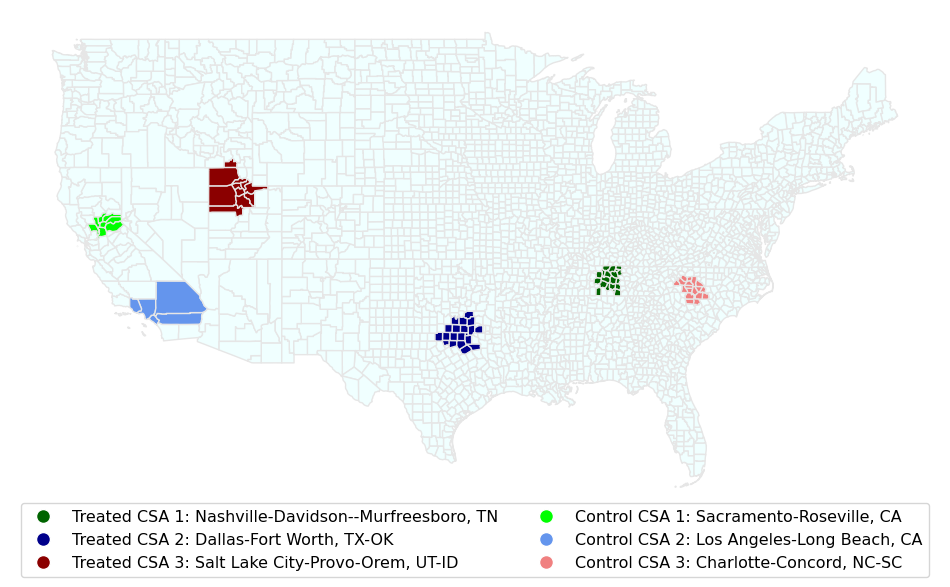

In [85]:
# %%script false --no-raise-error

# Plot how control-treated are assembled

episodes = CSA_episodes_impliedHHI_N

# Read the US states GeoJSON file
gdf = gpd.read_file('../RawData/MSA/US-counties.geojson')
gdf = gdf[gdf['STATE']!='02']
gdf = gdf[gdf['STATE']!='15']
gdf = gdf[gdf['STATE']!='72']
gdf = gdf.rename(columns={'STATE':'FIPS State Code','COUNTY':'FIPS County Code'})

# Sometimes treated and control are adjacent: Improved by requiring treated and control to be not in the same state. Note that further
# improvement can be made

counties = pd.DataFrame()

episode_ind = 30
CSA_treated = episodes['CSA Code'][episode_ind]
CSA_control = episodes['control'][episode_ind][0]
CSA_treated1, CSA_control1 = CSA_treated, CSA_control
counties_treated = CBSAData[(CBSAData['CSA Code']==CSA_treated)][['FIPS State Code','FIPS County Code']]
counties_treated['value'] = 1
counties_control = CBSAData[(CBSAData['CSA Code']==CSA_control)][['FIPS State Code','FIPS County Code']]
counties_control['value'] = 2
counties = pd.concat([counties,counties_treated,counties_control])

episode_ind = 20
CSA_treated = episodes['CSA Code'][episode_ind]
CSA_control = episodes['control'][episode_ind][0]
CSA_treated2, CSA_control2 = CSA_treated, CSA_control
counties_treated = CBSAData[(CBSAData['CSA Code']==CSA_treated)][['FIPS State Code','FIPS County Code']]
counties_treated['value'] = 3
counties_control = CBSAData[(CBSAData['CSA Code']==CSA_control)][['FIPS State Code','FIPS County Code']]
counties_control['value'] = 4
counties = pd.concat([counties,counties_treated,counties_control])

episode_ind = 110
CSA_treated = episodes['CSA Code'][episode_ind]
CSA_control = episodes['control'][episode_ind][0]
CSA_treated3, CSA_control3 = CSA_treated, CSA_control
counties_treated = CBSAData[(CBSAData['CSA Code']==CSA_treated)][['FIPS State Code','FIPS County Code']]
counties_treated['value'] = 5
counties_control = CBSAData[(CBSAData['CSA Code']==CSA_control)][['FIPS State Code','FIPS County Code']]
counties_control['value'] = 6
counties = pd.concat([counties,counties_treated,counties_control])

counties['FIPS State Code'] = counties['FIPS State Code'].astype(int)
counties['FIPS County Code'] = counties['FIPS County Code'].astype(int)
gdf['FIPS State Code'] = gdf['FIPS State Code'].astype(int)
gdf['FIPS County Code'] = gdf['FIPS County Code'].astype(int)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

color_dict = {0:'azure', 1:'darkgreen', 2:'lime', 3:'darkblue', 4:'cornflowerblue', 5:'darkred', 6:'lightcoral'}

# Merge the GeoDataFrame with data
merged = gdf.merge(counties,on=['FIPS State Code','FIPS County Code'],how='outer')
merged.loc[pd.isnull(merged['value']),'value'] = 0
merged.plot(ax=ax, column='value', cmap=colors.ListedColormap(list(color_dict.values())), edgecolor='0.9', legend=False)
legend_labels = [
    'Treated CSA 1: '+CSADict[CSA_treated1],
    'Treated CSA 2: '+CSADict[CSA_treated2],
    'Treated CSA 3: '+CSADict[CSA_treated3],
    'Control CSA 1: '+CSADict[CSA_control1],
    'Control CSA 2: '+CSADict[CSA_control2],
    'Control CSA 3: '+CSADict[CSA_control3],
    ]
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='darkgreen'),
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='darkblue'),
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='darkred'),
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='lime'),
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='cornflowerblue'),
    plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='lightcoral'),
    ]
ax.legend(legend_handles, legend_labels,loc='lower center',bbox_to_anchor=(0.5, -0.15),ncol=2,fontsize='11.5')
ax.axis("off")
warnings.filterwarnings("ignore", category=DeprecationWarning)
fig.savefig('../Slides/figs/TreatedControlSample.eps', format='eps', bbox_inches='tight')

## 3.2 By CBSA

### 3.1.1. Find CBSA X Year affected by merger

In [86]:
CBSA_affected = pd.read_parquet('../CleanData/MAEvent/CBSA_affected.parquet')

In [87]:
%%script false --no-raise-error

# %%time

# Go over each merger. Check the CBSAs affected by the merger (i.e., either side has business in the CBSA in the year prior 
# to the merger). Check if the merger affects just one underwriter or affects multiple underwriters in this CBSA.

# Note that for the column "market share of other targets", the optimal object to put there is the market share of the other target
# alone. Here I am instead putting in market share of the other target's parent. This should make a minimal difference.

def proc_list(MA_frag):
    
    name_GPF_colnames = ['name_GPF_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
    parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
    
    CBSA_affected = []
    MA_frag = MA_frag.reset_index(drop=True)
    
    for idx,row in MA_frag.iterrows():
        
        # Find CBSAs that this merger affects
        # Determine if an underwriter is active in an CBSA based on activity of PRIOR years
        GPF_prioryears = GPF[(GPF['sale_year']>=row['sale_year']-3)&(GPF['sale_year']<=row['sale_year']-1)]

        # Also check other targets of the acquiror in that year. This accounts for cases where post merger the new formed entity
        # is new and appear as a name that was not in the sample before. Note that here "MA_frag" cannot be used or the other firm
        # involved in the merger will be missed. Instead, use the whole sample "MA"
        other_targets = \
            list(MA[(MA['acquiror']==row['acquiror'])&
            (MA['sale_year']==row['sale_year'])&
            (MA['target']!=row['target'])]['target'])
        
        for CBSA in list(GPF_prioryears['CBSA Code'].unique()):

            GPF_prioryears_oneCBSA = GPF_prioryears[GPF_prioryears['CBSA Code']==CBSA]

            # Underwriters in this state
            underwriters_priorMA = list(chain.from_iterable(list(np.array(GPF_prioryears_oneCBSA[name_GPF_colnames]))))
            underwriters_priorMA = [item for item in underwriters_priorMA if item!=None]
            underwriters_priorMA = list(set(underwriters_priorMA))
            # Parents of underwriters in this state
            parents_priorMA = list(chain.from_iterable(list(np.array(GPF_prioryears_oneCBSA[parent_name_colnames]))))
            parents_priorMA = [item for item in parents_priorMA if item!=None]
            parents_priorMA = list(set(parents_priorMA))
            # Subsidiaries of parents in this state (using data of PRIOR year)
            subsidiaries_priorMA = list(GPF_names[
                (GPF_names['parent_name'].isin(parents_priorMA))&
                (GPF_names['sale_year']>=row['sale_year']-3)&
                (GPF_names['sale_year']<=row['sale_year']-1)]['name_GPF'])

            # Determine if merger affects the CBSA, and if both sides have business
            IF_acquiror_active = None
            IF_target_active = None
            IF_other_target_active = None
            if (row['acquiror'] in parents_priorMA) or (row['acquiror'] in underwriters_priorMA) or (row['acquiror'] in subsidiaries_priorMA):
                IF_acquiror_active = True
            if (row['target'] in parents_priorMA) or (row['target'] in underwriters_priorMA) or (row['target'] in subsidiaries_priorMA):
                IF_target_active = True
            for other_target in other_targets:
                if (other_target in parents_priorMA) or (other_target in underwriters_priorMA):
                    IF_other_target_active = True

            # Get market share of merged banks. Note that this is the market share in the years prior to M&A. Also note that market 
            # share "market_share_all_markets_byCBSA" is calculated at the parent level. There are many cases where market share of a
            # firm in an area is unavailable, which is because of no presence.



            #-------------------------#
            # Market share by N deals #
            #-------------------------#

            # (1) Market share of acquiror
            # Determine parent of target, as "market_share_all_markets_byCBSA" is at parent level
            try:
                # Situation where acquiror is a subsidiary or standalone firm whose parent is itself. Extract its parent
                acquiror_parent = GPF_names[(GPF_names['name_GPF']==row['acquiror'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                # Situation where acquiror is a parent
                acquiror_parent = row['acquiror']
            try:
                acquiror_market_share_N_m1 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m1 = 0
            try:
                acquiror_market_share_N_m2 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m2 = 0
            try:
                acquiror_market_share_N_m3 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m3 = 0

            # (2) Market share of target
            try:
                # Note that I must use "GPF_names" (the parent-subsidiary) mapping use the year(s) prior to the MA
                target_parent = GPF_names[(GPF_names['name_GPF']==row['target'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                target_parent = row['target']
            try:
                target_market_share_N_m1 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m1 = 0
            try:
                target_market_share_N_m2 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m2 = 0
            try:
                target_market_share_N_m3 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m3 = 0

            # (3) Market share of other targets in the same transaction
            # Account for possibility that other targets can be either a parent or a standalone firm
            other_targets_parents = \
                list(GPF_names[(GPF_names['name_GPF'].isin(other_targets))
                &(GPF_names['sale_year']==row['sale_year']-1)]['parent_name'])+\
                list(other_targets)
            other_targets_parents = list(set(other_targets_parents))

            other_targets_market_share_N = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m1 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m1 = 0

            other_targets_market_share_N = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m2 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m2 = 0

            other_targets_market_share_N = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m3 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m3 = 0



            #------------------------#
            # Market share by dollar #
            #------------------------#

            # (1) Market share of acquiror
            # Determine parent of target, as "market_share_all_markets_byCBSA" is at parent level
            try:
                # Situation where acquiror is a subsidiary or standalone firm whose parent is itself. Extract its parent
                acquiror_parent = GPF_names[(GPF_names['name_GPF']==row['acquiror'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                # Situation where acquiror is a parent
                acquiror_parent = row['acquiror']
            try:
                acquiror_market_share_Dollar_m1 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                acquiror_market_share_Dollar_m1 = 0
            try:
                acquiror_market_share_Dollar_m2 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                acquiror_market_share_Dollar_m2 = 0
            try:
                acquiror_market_share_Dollar_m3 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                acquiror_market_share_Dollar_m3 = 0

            # (2) Market share of target
            try:
                # Note that I must use "GPF_names" (the parent-subsidiary) mapping use the year(s) prior to the MA
                target_parent = GPF_names[(GPF_names['name_GPF']==row['target'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                target_parent = row['target']
            try:
                target_market_share_Dollar_m1 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                target_market_share_Dollar_m1 = 0
            try:
                target_market_share_Dollar_m2 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                target_market_share_Dollar_m2 = 0
            try:
                target_market_share_Dollar_m3 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_Dollar'][0]
            except:
                target_market_share_Dollar_m3 = 0

            # (3) Market share of other targets in the same transaction
            # Account for possibility that other targets can be either a parent or a standalone firm
            other_targets_parents = \
                list(GPF_names[(GPF_names['name_GPF'].isin(other_targets))
                &(GPF_names['sale_year']==row['sale_year']-1)]['parent_name'])+\
                list(other_targets)
            other_targets_parents = list(set(other_targets_parents))

            other_targets_market_share_Dollar = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]
            if len(other_targets_market_share_Dollar)>0:
                other_targets_market_share_Dollar_m1 = np.sum(other_targets_market_share_Dollar['market_share_Dollar'])
            else:
                other_targets_market_share_Dollar_m1 = 0

            other_targets_market_share_Dollar = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]
            if len(other_targets_market_share_Dollar)>0:
                other_targets_market_share_Dollar_m2 = np.sum(other_targets_market_share_Dollar['market_share_Dollar'])
            else:
                other_targets_market_share_Dollar_m2 = 0

            other_targets_market_share_Dollar = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]
            if len(other_targets_market_share_Dollar)>0:
                other_targets_market_share_Dollar_m3 = np.sum(other_targets_market_share_Dollar['market_share_Dollar'])
            else:
                other_targets_market_share_Dollar_m3 = 0



            # Record data
            if IF_acquiror_active or IF_target_active or IF_other_target_active:
                CBSA_affected = CBSA_affected+[{
                    'CBSA Code':CBSA,
                    'sale_year':row['sale_year'],
                    'acquiror':row['acquiror'],
                    'target':row['target'],
                    'other_targets':other_targets,
                    'acquiror_parent':acquiror_parent,
                    'target_parent':target_parent,
                    'acquiror_market_share_N_m1':acquiror_market_share_N_m1,
                    'acquiror_market_share_N_m2':acquiror_market_share_N_m2,
                    'acquiror_market_share_N_m3':acquiror_market_share_N_m3,
                    'target_market_share_N_m1':target_market_share_N_m1,
                    'target_market_share_N_m2':target_market_share_N_m2,
                    'target_market_share_N_m3':target_market_share_N_m3,
                    'other_targets_market_share_N_m1':other_targets_market_share_N_m1,
                    'other_targets_market_share_N_m2':other_targets_market_share_N_m2,
                    'other_targets_market_share_N_m3':other_targets_market_share_N_m3,
                    'acquiror_market_share_Dollar_m1':acquiror_market_share_Dollar_m1,
                    'acquiror_market_share_Dollar_m2':acquiror_market_share_Dollar_m2,
                    'acquiror_market_share_Dollar_m3':acquiror_market_share_Dollar_m3,
                    'target_market_share_Dollar_m1':target_market_share_Dollar_m1,
                    'target_market_share_Dollar_m2':target_market_share_Dollar_m2,
                    'target_market_share_Dollar_m3':target_market_share_Dollar_m3,
                    'other_targets_market_share_Dollar_m1':other_targets_market_share_Dollar_m1,
                    'other_targets_market_share_Dollar_m2':other_targets_market_share_Dollar_m2,
                    'other_targets_market_share_Dollar_m3':other_targets_market_share_Dollar_m3,
                }]
            acquiror_market_share_N_m1 = None
            acquiror_market_share_N_m2 = None
            acquiror_market_share_N_m3 = None
            target_market_share_N_m1 = None
            target_market_share_N_m2 = None
            target_market_share_N_m3 = None
            other_targets_market_share = None
            other_targets_market_share_N_m1 = None
            other_targets_market_share_N_m2 = None
            other_targets_market_share_N_m3 = None
            acquiror_market_share_Dollar_m1 = None
            acquiror_market_share_Dollar_m2 = None
            acquiror_market_share_Dollar_m3 = None
            target_market_share_Dollar_m1 = None
            target_market_share_Dollar_m2 = None
            target_market_share_Dollar_m3 = None
            other_targets_market_share = None
            other_targets_market_share_Dollar_m1 = None
            other_targets_market_share_Dollar_m2 = None
            other_targets_market_share_Dollar_m3 = None
    
    CBSA_affected = pd.DataFrame(CBSA_affected)
    return CBSA_affected

MA_dd = dd.from_pandas(MA, npartitions=40)
with dask.config.set(scheduler='processes',num_workers=40):
    CBSA_affected = MA_dd.map_partitions(proc_list, 
    meta=pd.DataFrame(columns=
    ['CBSA Code','sale_year','acquiror','target',
    'other_targets','acquiror_parent','target_parent',
    'acquiror_market_share_N_m1','acquiror_market_share_N_m2','acquiror_market_share_N_m3',
    'target_market_share_N_m1','target_market_share_N_m2','target_market_share_N_m3',
    'other_targets_market_share_N_m1','other_targets_market_share_N_m2','other_targets_market_share_N_m3',
    'acquiror_market_share_Dollar_m1','acquiror_market_share_Dollar_m2','acquiror_market_share_Dollar_m3',
    'target_market_share_Dollar_m1','target_market_share_Dollar_m2','target_market_share_Dollar_m3',
    'other_targets_market_share_Dollar_m1','other_targets_market_share_Dollar_m2','other_targets_market_share_Dollar_m3',
    ])).compute()

# Average market share over past three years
CBSA_affected['acquiror_market_share_N_avg'] = \
    (CBSA_affected['acquiror_market_share_N_m1']+\
    CBSA_affected['acquiror_market_share_N_m2']+\
    CBSA_affected['acquiror_market_share_N_m3'])/3
CBSA_affected['target_market_share_N_avg'] = \
    (CBSA_affected['target_market_share_N_m1']+\
    CBSA_affected['target_market_share_N_m2']+\
    CBSA_affected['target_market_share_N_m3'])/3
CBSA_affected['other_targets_market_share_N_avg'] = \
    (CBSA_affected['other_targets_market_share_N_m1']+\
    CBSA_affected['other_targets_market_share_N_m2']+\
    CBSA_affected['other_targets_market_share_N_m3'])/3

# As this step takes significant time, export output
CBSA_affected.to_parquet('../CleanData/MAEvent/CBSA_affected.parquet')

### 3.2.2. Identify merger episodes

**Method 1: By market share**

In [88]:
#----------------------------#
# Market share by N of deals #
#----------------------------#

# Identify episodes of mergers at the CBSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CBSA_affected"

parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]

CBSA_episodes_marketshare_N = []

for CBSA in list(CBSA_affected['CBSA Code'].unique()):

    CBSA_affected_part = CBSA_affected[CBSA_affected['CBSA Code']==CBSA]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    episode_start_year = 1900
    years = CBSA_affected_part['sale_year'].unique()
    years = sorted(years)
    for sale_year in years:
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CBSA_affected_episode = CBSA_affected_part[(CBSA_affected_part['sale_year']>=sale_year)&(CBSA_affected_part['sale_year']<=sale_year+3)]
        # When a firm acquires multiple firms, market share of other firms are in "other_targets_market_share_N_avg", so just keeping one record
        # is sufficient
        CBSA_affected_episode = CBSA_affected_episode.drop_duplicates(['acquiror','sale_year'])
        # Alternative aggregation methods might be more reasonable. Also, this does not account for that target tends to be smaller so threshold
        # for them should be smaller too. Even better, can compute the implied-HHI change (based on historical data) of this merger, and put threshold
        # on that, which is definitely more powerful.
        acquiror_market_share_N_avg = np.sum(CBSA_affected_episode['acquiror_market_share_N_avg'])
        target_market_share_N_avg = np.sum(CBSA_affected_episode['target_market_share_N_avg'])
        other_targets_market_share_N_avg = np.sum(CBSA_affected_episode['other_targets_market_share_N_avg'])

        # Out of all mergers in this episode, calculate
        # (1) the max of sum of market shares of merging entities
        max_sum_share = \
            np.max(CBSA_affected_episode['acquiror_market_share_N_avg']+CBSA_affected_episode['target_market_share_N_avg']
                +CBSA_affected_episode['other_targets_market_share_N_avg'])
        # (2) the max of min of market shares of merging entities
        max_min_share = \
            np.max(np.minimum(CBSA_affected_episode['acquiror_market_share_N_avg'],
                CBSA_affected_episode['target_market_share_N_avg']+CBSA_affected_episode['other_targets_market_share_N_avg']))
        # (3) the mean of sum of market shares of merging entities
        mean_sum_share = \
            np.mean(CBSA_affected_episode['acquiror_market_share_N_avg']+CBSA_affected_episode['target_market_share_N_avg']
                +CBSA_affected_episode['other_targets_market_share_N_avg'])

        # Check if market share in the episode is high enough
        if acquiror_market_share_N_avg>0.05 and target_market_share_N_avg+other_targets_market_share_N_avg>0.05:
            # An episode is identified
            CBSA_episodes_marketshare_N = CBSA_episodes_marketshare_N+[{
                'episode_start_year':sale_year,
                'CBSA Code':CBSA,
                'mergers':CBSA_affected_episode,
                'acquiror_market_share_N_avg':acquiror_market_share_N_avg,
                'target_market_share_N_avg':target_market_share_N_avg,
                'other_targets_market_share_N_avg':other_targets_market_share_N_avg,
                'max_sum_share':max_sum_share,
                'max_min_share':max_min_share,
                'mean_sum_share':mean_sum_share,
                }]
            episode_start_year = sale_year

CBSA_episodes_marketshare_N = pd.DataFrame(CBSA_episodes_marketshare_N)


**Method 2: By implied rise in HHI due to merger**

In [89]:
#-----------------------------#
# Change in HHI by N of deals #
#-----------------------------#

# Identify episodes of mergers at the CBSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CBSA_affected"

CBSA_episodes_impliedHHI_N = []

for CBSA in list(CBSA_affected['CBSA Code'].unique()):

    CBSA_affected_part = CBSA_affected[CBSA_affected['CBSA Code']==CBSA]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CBSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CBSA_affected_episode = CBSA_affected_part[(CBSA_affected_part['sale_year']>=sale_year)&(CBSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCBSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CBSA Code']==CBSA)]
        
        # Calculate (1) HHI (by parent firm) in the three years prior (2) Predicted HHI after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCBSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCBSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # HHI prior to merger
        hhi_piror = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)

        # Implied HHI post merger
        CBSA_affected_episode = CBSA_affected_episode.reset_index(drop=True)
        for idx,row in CBSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        hhi_predicted = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)
        n_deals_post = n_deals

        hhi_dif = hhi_predicted-hhi_piror

        # Check if market share in the episode is high enough
        if hhi_dif>0.01:
            # An episode is identified
            CBSA_episodes_impliedHHI_N = CBSA_episodes_impliedHHI_N+[{
                'episode_start_year':sale_year,
                'CBSA Code':CBSA,
                'mergers':CBSA_affected_episode,
                'hhi_dif':hhi_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                }]
            episode_start_year = sale_year

CBSA_episodes_impliedHHI_N = pd.DataFrame(CBSA_episodes_impliedHHI_N)


#### **Method 3: By implied rise in top 5 share due to merger**

In [90]:
#-------------------------------------#
# Change in top 5 share by N of deals #
#-------------------------------------#

# Identify episodes of mergers at the CBSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CBSA_affected"

CBSA_episodes_top5share_N = []

for CBSA in list(CBSA_affected['CBSA Code'].unique()):

    CBSA_affected_part = CBSA_affected[CBSA_affected['CBSA Code']==CBSA]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CBSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CBSA_affected_episode = CBSA_affected_part[(CBSA_affected_part['sale_year']>=sale_year)&(CBSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCBSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CBSA Code']==CBSA)]
        
        # Calculate (1) Top 5 share (by parent firm) in the three years prior (2) Predicted top 5 share after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCBSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCBSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # Top 5 share prior to merger
        n_deals['marketshare'] = n_deals['n_deals']/np.sum(n_deals['n_deals'])
        n_deals = n_deals.sort_values(by=['n_deals'],ascending=False).reset_index(drop=True)
        if len(n_deals)<=5:
            top5share_prior = 1
        else:
            top5share_prior = np.sum(n_deals['marketshare'][:5])

        # Implied top 5 share post merger
        CBSA_affected_episode = CBSA_affected_episode.reset_index(drop=True)
        for idx,row in CBSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        n_deals['marketshare'] = n_deals['n_deals']/np.sum(n_deals['n_deals'])
        n_deals = n_deals.sort_values(by=['n_deals'],ascending=False).reset_index(drop=True)
        if len(n_deals)<=5:
            top5share_post = 1
        else:
            top5share_post = np.sum(n_deals['marketshare'][:5])
        n_deals_post = n_deals

        top5share_dif = top5share_post-top5share_prior

        # Market shares used in summary statistics
        CBSA_affected_episode['min_share'] = np.minimum(CBSA_affected_episode['acquiror_market_share_N_avg'],
            CBSA_affected_episode['target_market_share_N_avg']+\
            CBSA_affected_episode['other_targets_market_share_N_avg'])
        CBSA_affected_episode = CBSA_affected_episode.sort_values('min_share')
        CBSA_affected_episode_topshare = CBSA_affected_episode[-1:]
        acquiror_market_share_N_max = np.max(CBSA_affected_episode_topshare['acquiror_market_share_N_avg'])
        target_market_share_N_max = np.max(CBSA_affected_episode_topshare['target_market_share_N_avg'])
        other_targets_market_share_N_max = np.max(CBSA_affected_episode_topshare['other_targets_market_share_N_avg'])

        # Check if market share in the episode is high enough
        if top5share_dif>0.05:
            # An episode is identified
            CBSA_episodes_top5share_N = CBSA_episodes_top5share_N+[{
                'episode_start_year':sale_year,
                'CBSA Code':CBSA,
                'mergers':CBSA_affected_episode,
                'top5share_dif':top5share_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CBSA_episodes_top5share_N = pd.DataFrame(CBSA_episodes_top5share_N)


In [91]:
len(CBSA_episodes_top5share_N)

391

#### **Placebo test: Find an area that is affected by withdrawn merger**

In [92]:
MA_withdrawn = pd.read_csv("../RawData/SDC/MA_withdrawn.csv")
MA_withdrawn = MA_withdrawn.rename(columns={'announce_year':'sale_year'})[['target','acquiror','sale_year']]

In [93]:
# Find CBSA X Year that could be affected by withdrawn merger

# Go over each merger. Check the CBSAs affected by the merger (i.e., either side has business in the CBSA in the year prior 
# to the merger). Check if the merger affects just one underwriter or affects multiple underwriters in this CBSA.

# Note that for the column "market share of other targets", the optimal object to put there is the market share of the other target
# alone. Here I am instead putting in market share of the other target's parent. This should make a minimal difference.

name_GPF_colnames = ['name_GPF_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]

def proc_list(MA_withdrawn_frag):

    CBSA_affected_withdrawn = []
    MA_withdrawn_frag = MA_withdrawn_frag.reset_index(drop=True)
    
    for idx,row in MA_withdrawn_frag.iterrows():
        
        # Find CBSAs that this merger affects
        # Determine if an underwriter is active in an CBSA based on activity of PRIOR years
        GPF_prioryears = GPF[(GPF['sale_year']>=row['sale_year']-3)&(GPF['sale_year']<=row['sale_year']-1)]
    
        # Also check other targets of the acquiror in that year. This accounts for cases where post merger the new formed entity
        # is new and appear as a name that was not in the sample before. Note that here "MA_frag" cannot be used or the other firm
        # involved in the merger will be missed. Instead, use the whole sample "MA"
        other_targets = \
            list(MA_withdrawn[(MA_withdrawn['acquiror']==row['acquiror'])&
            (MA_withdrawn['sale_year']==row['sale_year'])&
            (MA_withdrawn['target']!=row['target'])]['target'])
        
        for CBSA in list(GPF_prioryears['CBSA Code'].unique()):
    
            GPF_prioryears_oneCBSA = GPF_prioryears[GPF_prioryears['CBSA Code']==CBSA]
    
            # Underwriters in this state
            underwriters_priorMA = list(chain.from_iterable(list(np.array(GPF_prioryears_oneCBSA[name_GPF_colnames]))))
            underwriters_priorMA = [item for item in underwriters_priorMA if item!=None]
            underwriters_priorMA = list(set(underwriters_priorMA))
            # Parents of underwriters in this state
            parents_priorMA = list(chain.from_iterable(list(np.array(GPF_prioryears_oneCBSA[parent_name_colnames]))))
            parents_priorMA = [item for item in parents_priorMA if item!=None]
            parents_priorMA = list(set(parents_priorMA))
            # Subsidiaries of parents in this state (using data of PRIOR year)
            subsidiaries_priorMA = list(GPF_names[
                (GPF_names['parent_name'].isin(parents_priorMA))&
                (GPF_names['sale_year']>=row['sale_year']-3)&
                (GPF_names['sale_year']<=row['sale_year']-1)]['name_GPF'])
    
            # Determine if merger affects the CBSA, and if both sides have business
            IF_acquiror_active = None
            IF_target_active = None
            IF_other_target_active = None
            if (row['acquiror'] in parents_priorMA) or (row['acquiror'] in underwriters_priorMA) or (row['acquiror'] in subsidiaries_priorMA):
                IF_acquiror_active = True
            if (row['target'] in parents_priorMA) or (row['target'] in underwriters_priorMA) or (row['target'] in subsidiaries_priorMA):
                IF_target_active = True
            for other_target in other_targets:
                if (other_target in parents_priorMA) or (other_target in underwriters_priorMA):
                    IF_other_target_active = True
    
            # Get market share of merged banks. Note that this is the market share in the years prior to M&A. Also note that market 
            # share "market_share_all_markets_byCBSA" is calculated at the parent level. There are many cases where market share of a
            # firm in an area is unavailable, which is because of no presence.
    
    
    
            #-------------------------#
            # Market share by N deals #
            #-------------------------#
    
            # (1) Market share of acquiror
            # Determine parent of target, as "market_share_all_markets_byCBSA" is at parent level
            try:
                # Situation where acquiror is a subsidiary or standalone firm whose parent is itself. Extract its parent
                acquiror_parent = GPF_names[(GPF_names['name_GPF']==row['acquiror'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                # Situation where acquiror is a parent
                acquiror_parent = row['acquiror']
            try:
                acquiror_market_share_N_m1 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m1 = 0
            try:
                acquiror_market_share_N_m2 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m2 = 0
            try:
                acquiror_market_share_N_m3 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==acquiror_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_N'][0]
            except:
                acquiror_market_share_N_m3 = 0
    
            # (2) Market share of target
            try:
                # Note that I must use "GPF_names" (the parent-subsidiary) mapping use the year(s) prior to the MA
                target_parent = GPF_names[(GPF_names['name_GPF']==row['target'])&(GPF_names['sale_year']==row['sale_year']-1)]\
                    .reset_index()['parent_name'][0]
            except:
                target_parent = row['target']
            try:
                target_market_share_N_m1 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m1 = 0
            try:
                target_market_share_N_m2 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m2 = 0
            try:
                target_market_share_N_m3 = \
                    market_share_all_markets_byCBSA[
                    (market_share_all_markets_byCBSA['parent_name']==target_parent)
                    &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                    &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]\
                    .reset_index()['market_share_N'][0]
            except:
                target_market_share_N_m3 = 0
    
            # (3) Market share of other targets in the same transaction
            # Account for possibility that other targets can be either a parent or a standalone firm
            other_targets_parents = \
                list(GPF_names[(GPF_names['name_GPF'].isin(other_targets))
                &(GPF_names['sale_year']==row['sale_year']-1)]['parent_name'])+\
                list(other_targets)
            other_targets_parents = list(set(other_targets_parents))
    
            other_targets_market_share_N = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-1)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m1 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m1 = 0
    
            other_targets_market_share_N = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-2)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m2 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m2 = 0
    
            other_targets_market_share_N = \
                market_share_all_markets_byCBSA[
                (market_share_all_markets_byCBSA['parent_name'].isin(other_targets_parents))
                &(market_share_all_markets_byCBSA['CBSA Code']==CBSA)
                &(market_share_all_markets_byCBSA['calendar_year']==row['sale_year']-3)]
            if len(other_targets_market_share_N)>0:
                other_targets_market_share_N_m3 = np.sum(other_targets_market_share_N['market_share_N'])
            else:
                other_targets_market_share_N_m3 = 0
    
    
            # Record data
            if IF_acquiror_active or IF_target_active or IF_other_target_active:
                CBSA_affected_withdrawn = CBSA_affected_withdrawn+[{
                    'CBSA Code':CBSA,
                    'sale_year':row['sale_year'],
                    'acquiror':row['acquiror'],
                    'target':row['target'],
                    'other_targets':other_targets,
                    'acquiror_parent':acquiror_parent,
                    'target_parent':target_parent,
                    'acquiror_market_share_N_m1':acquiror_market_share_N_m1,
                    'acquiror_market_share_N_m2':acquiror_market_share_N_m2,
                    'acquiror_market_share_N_m3':acquiror_market_share_N_m3,
                    'target_market_share_N_m1':target_market_share_N_m1,
                    'target_market_share_N_m2':target_market_share_N_m2,
                    'target_market_share_N_m3':target_market_share_N_m3,
                    'other_targets_market_share_N_m1':other_targets_market_share_N_m1,
                    'other_targets_market_share_N_m2':other_targets_market_share_N_m2,
                    'other_targets_market_share_N_m3':other_targets_market_share_N_m3,
                }]
            acquiror_market_share_N_m1 = None
            acquiror_market_share_N_m2 = None
            acquiror_market_share_N_m3 = None
            target_market_share_N_m1 = None
            target_market_share_N_m2 = None
            target_market_share_N_m3 = None
            other_targets_market_share = None
            other_targets_market_share_N_m1 = None
            other_targets_market_share_N_m2 = None
            other_targets_market_share_N_m3 = None
    
    CBSA_affected_withdrawn = pd.DataFrame(CBSA_affected_withdrawn)
        
    return CBSA_affected_withdrawn

MA_withdrawn_dd = dd.from_pandas(MA_withdrawn, npartitions=40)
with dask.config.set(scheduler='processes',num_workers=40):
    CBSA_affected_withdrawn = MA_withdrawn_dd.map_partitions(proc_list, 
    meta=pd.DataFrame(columns=
    ['CBSA Code','sale_year','acquiror','target',
    'other_targets','acquiror_parent','target_parent',
    'acquiror_market_share_N_m1','acquiror_market_share_N_m2','acquiror_market_share_N_m3',
    'target_market_share_N_m1','target_market_share_N_m2','target_market_share_N_m3',
    'other_targets_market_share_N_m1','other_targets_market_share_N_m2','other_targets_market_share_N_m3',
    ])).compute()

# Average market share over past three years
CBSA_affected_withdrawn['acquiror_market_share_N_avg'] = \
    (CBSA_affected_withdrawn['acquiror_market_share_N_m1']+\
    CBSA_affected_withdrawn['acquiror_market_share_N_m2']+\
    CBSA_affected_withdrawn['acquiror_market_share_N_m3'])/3
CBSA_affected_withdrawn['target_market_share_N_avg'] = \
    (CBSA_affected_withdrawn['target_market_share_N_m1']+\
    CBSA_affected_withdrawn['target_market_share_N_m2']+\
    CBSA_affected_withdrawn['target_market_share_N_m3'])/3
CBSA_affected_withdrawn['other_targets_market_share_N_avg'] = \
    (CBSA_affected_withdrawn['other_targets_market_share_N_m1']+\
    CBSA_affected_withdrawn['other_targets_market_share_N_m2']+\
    CBSA_affected_withdrawn['other_targets_market_share_N_m3'])/3


In [94]:
#-----------------------------#
# Change in HHI by N of deals #
#-----------------------------#

# Identify episodes of mergers at the CBSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CBSA_affected"

CBSA_episodes_Withdrawn = []

for CBSA in list(CBSA_affected_withdrawn['CBSA Code'].unique()):

    CBSA_affected_part = CBSA_affected_withdrawn[CBSA_affected_withdrawn['CBSA Code']==CBSA]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CBSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CBSA_affected_episode = CBSA_affected_part[(CBSA_affected_part['sale_year']>=sale_year)&(CBSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCBSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CBSA Code']==CBSA)]
        
        # Calculate (1) HHI (by parent firm) in the three years prior (2) Predicted HHI after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCBSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCBSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # HHI prior to merger
        hhi_piror = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)

        # Implied HHI post merger
        CBSA_affected_episode = CBSA_affected_episode.reset_index(drop=True)
        for idx,row in CBSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        hhi_predicted = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)
        n_deals_post = n_deals

        hhi_dif = hhi_predicted-hhi_piror

        # Check if market share in the episode is high enough
        if hhi_dif>0.01:
            # An episode is identified
            CBSA_episodes_Withdrawn = CBSA_episodes_Withdrawn+[{
                'episode_start_year':sale_year,
                'CBSA Code':CBSA,
                'mergers':CBSA_affected_episode,
                'hhi_dif':hhi_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CBSA_episodes_Withdrawn = pd.DataFrame(CBSA_episodes_Withdrawn)


#----------------------------------------------#
# Check and rule out if affected by actual M&A #
#----------------------------------------------#

# Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
CBSA_episodes_Withdrawn['if_also_withinMA'] = False
for sub_idx,sub_row in CBSA_episodes_Withdrawn.iterrows():

    # M&As in a candidate placebo CBSA in [-4,+4]
    CBSA_affected_part = CBSA_affected[CBSA_affected['CBSA Code']==sub_row['CBSA Code']]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
        (CBSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
        ]
    CBSA_affected_episode = CBSA_affected_part.copy()
    CBSA_affected_episode = CBSA_affected_episode[(CBSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
        (CBSA_affected_episode['target_market_share_N_avg']+CBSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
    if len(CBSA_affected_episode)>0:
        CBSA_episodes_Withdrawn.at[sub_idx,'if_also_withinMA'] = True

CBSA_episodes_Withdrawn = CBSA_episodes_Withdrawn[~CBSA_episodes_Withdrawn['if_also_withinMA']]
CBSA_episodes_Withdrawn_DeltaHHI100 = CBSA_episodes_Withdrawn

In [95]:
#-----------------------------#
# Change in HHI by N of deals #
#-----------------------------#

# Identify episodes of mergers at the CBSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CBSA_affected"

CBSA_episodes_Withdrawn = []

for CBSA in list(CBSA_affected_withdrawn['CBSA Code'].unique()):

    CBSA_affected_part = CBSA_affected_withdrawn[CBSA_affected_withdrawn['CBSA Code']==CBSA]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CBSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CBSA_affected_episode = CBSA_affected_part[(CBSA_affected_part['sale_year']>=sale_year)&(CBSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCBSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CBSA Code']==CBSA)]
        
        # Calculate (1) HHI (by parent firm) in the three years prior (2) Predicted HHI after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCBSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCBSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # HHI prior to merger
        hhi_piror = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)

        # Implied HHI post merger
        CBSA_affected_episode = CBSA_affected_episode.reset_index(drop=True)
        for idx,row in CBSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        hhi_predicted = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)
        n_deals_post = n_deals

        hhi_dif = hhi_predicted-hhi_piror

        # Check if market share in the episode is high enough
        if hhi_dif>0.005:
            # An episode is identified
            CBSA_episodes_Withdrawn = CBSA_episodes_Withdrawn+[{
                'episode_start_year':sale_year,
                'CBSA Code':CBSA,
                'mergers':CBSA_affected_episode,
                'hhi_dif':hhi_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CBSA_episodes_Withdrawn = pd.DataFrame(CBSA_episodes_Withdrawn)


#----------------------------------------------#
# Check and rule out if affected by actual M&A #
#----------------------------------------------#

# Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
CBSA_episodes_Withdrawn['if_also_withinMA'] = False
for sub_idx,sub_row in CBSA_episodes_Withdrawn.iterrows():

    # M&As in a candidate placebo CBSA in [-4,+4]
    CBSA_affected_part = CBSA_affected[CBSA_affected['CBSA Code']==sub_row['CBSA Code']]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
        (CBSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
        ]
    CBSA_affected_episode = CBSA_affected_part.copy()
    CBSA_affected_episode = CBSA_affected_episode[(CBSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
        (CBSA_affected_episode['target_market_share_N_avg']+CBSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
    if len(CBSA_affected_episode)>0:
        CBSA_episodes_Withdrawn.at[sub_idx,'if_also_withinMA'] = True

CBSA_episodes_Withdrawn = CBSA_episodes_Withdrawn[~CBSA_episodes_Withdrawn['if_also_withinMA']]
CBSA_episodes_Withdrawn_DeltaHHI50 = CBSA_episodes_Withdrawn

In [96]:
#-----------------------------#
# Change in HHI by N of deals #
#-----------------------------#

# Identify episodes of mergers at the CBSA level

# Go over each year with merger event, and check the M&As on this year and three years afterwards. If enough consolidation, an episode is 
# identified. Whether there is enough consolidation can be judged by average market share in the past three years, or market share just in 
# the year minus one. For each identified merger episode, check if there is reasonable control in the sample. Note that there can be duplicates
# as in cases where two firms merge into a new one, both will get recorded in "CBSA_affected"

CBSA_episodes_Withdrawn = []

for CBSA in list(CBSA_affected_withdrawn['CBSA Code'].unique()):

    CBSA_affected_part = CBSA_affected_withdrawn[CBSA_affected_withdrawn['CBSA Code']==CBSA]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    
    episode_start_year = 1900
    for sale_year in CBSA_affected_part['sale_year'].unique():
    
        # If this year is still within the last merger episode
        if sale_year<=episode_start_year+4:
            continue
        
        # Check intensity of M&A activities in that year and three years following
        CBSA_affected_episode = CBSA_affected_part[(CBSA_affected_part['sale_year']>=sale_year)&(CBSA_affected_part['sale_year']<=sale_year+3)]
        GPF_oneCBSA_priorMA = GPF[(GPF['sale_year']>=sale_year-3)&(GPF['sale_year']<=sale_year)&(GPF['CBSA Code']==CBSA)]
        
        # Calculate (1) HHI (by parent firm) in the three years prior (2) Predicted HHI after the mergers complete
        
        # Underwriters in the market
        name_GPFs = list(chain.from_iterable(list(np.array(GPF_oneCBSA_priorMA[parent_name_colnames]))))
        name_GPFs = [item for item in name_GPFs if item!=None]
        name_GPFs = [item for item in name_GPFs if str(item)!='nan']
        name_GPFs = list(set(name_GPFs))
        n_deals = {}
        for item in name_GPFs:
            n_deals[item] = 0
        
        # Record market shares before merger episode
        parent_name_colnames = ['parent_name_'+str(i) for i in range(0,len(raw_name_GPF_colnames))]
        for idx,row in GPF_oneCBSA_priorMA.iterrows():
            underwriters_onedeal = [row[item] for item in parent_name_colnames if row[item]!=None and str(row[item])!='nan']
            n_underwriters = len(underwriters_onedeal)
            for item in underwriters_onedeal:
                n_deals[item] = n_deals[item]+1/n_underwriters
        n_deals = pd.DataFrame.from_dict(n_deals,orient='index').reset_index()
        n_deals = n_deals.rename(columns={'index':'underwriter',0:'n_deals'})
        n_deals_prior = n_deals
        
        # HHI prior to merger
        hhi_piror = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)

        # Implied HHI post merger
        CBSA_affected_episode = CBSA_affected_episode.reset_index(drop=True)
        for idx,row in CBSA_affected_episode.iterrows():
            n_deals.loc[n_deals['underwriter']==row['target'],'underwriter'] = row['acquiror_parent']
        n_deals = n_deals.groupby('underwriter').agg({'n_deals':sum}).reset_index()
        hhi_predicted = np.sum((n_deals['n_deals']/np.sum(n_deals['n_deals']))**2)
        n_deals_post = n_deals

        hhi_dif = hhi_predicted-hhi_piror

        # Check if market share in the episode is high enough
        if hhi_dif>0.002:
            # An episode is identified
            CBSA_episodes_Withdrawn = CBSA_episodes_Withdrawn+[{
                'episode_start_year':sale_year,
                'CBSA Code':CBSA,
                'mergers':CBSA_affected_episode,
                'hhi_dif':hhi_dif,
                'n_deals_prior':n_deals_prior,
                'n_deals_post':n_deals_post,
                'acquiror_market_share_N_max':acquiror_market_share_N_max,
                'target_market_share_N_max':target_market_share_N_max,
                'other_targets_market_share_N_max':other_targets_market_share_N_max,
                }]
            episode_start_year = sale_year

CBSA_episodes_Withdrawn = pd.DataFrame(CBSA_episodes_Withdrawn)


#----------------------------------------------#
# Check and rule out if affected by actual M&A #
#----------------------------------------------#

# Check if there is any M&A in between [-4,+4] that has both sides market share above 0.01
CBSA_episodes_Withdrawn['if_also_withinMA'] = False
for sub_idx,sub_row in CBSA_episodes_Withdrawn.iterrows():

    # M&As in a candidate placebo CBSA in [-4,+4]
    CBSA_affected_part = CBSA_affected[CBSA_affected['CBSA Code']==sub_row['CBSA Code']]
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['acquiror_market_share_N_avg']>0)&
        ((CBSA_affected_part['target_market_share_N_avg']>0)|
        (CBSA_affected_part['other_targets_market_share_N_avg']>0))].sort_values('sale_year')
    # Note that market share is on a rolling basis of every three years, so I only need to start from year -1
    CBSA_affected_part = CBSA_affected_part[
        (CBSA_affected_part['sale_year']>=repre_merger['sale_year'][0]-1)&
        (CBSA_affected_part['sale_year']<=repre_merger['sale_year'][0]+5)
        ]
    CBSA_affected_episode = CBSA_affected_part.copy()
    CBSA_affected_episode = CBSA_affected_episode[(CBSA_affected_episode['acquiror_market_share_N_avg']>0.01)&
        (CBSA_affected_episode['target_market_share_N_avg']+CBSA_affected_episode['other_targets_market_share_N_avg']>0.01)]
    if len(CBSA_affected_episode)>0:
        CBSA_episodes_Withdrawn.at[sub_idx,'if_also_withinMA'] = True

CBSA_episodes_Withdrawn = CBSA_episodes_Withdrawn[~CBSA_episodes_Withdrawn['if_also_withinMA']]
CBSA_episodes_Withdrawn_DeltaHHI20 = CBSA_episodes_Withdrawn

### 3.2.3. Find a control and assemble a treatment-control matched sample

In [97]:
# There are multiple versions of episodes definiton (by market share or HHI, cutoff on implied HHI increases, etc.). I go over each
# version here

episodes_files = [
    ["By Market Share in terms of N deals",CBSA_episodes_marketshare_N,1,
        '../CleanData/MAEvent/CBSA_episodes_marketshareByN.csv',
        '../CleanData/MAEvent/CBSA_episodes_marketshareByN_bondlevel.csv',
        '../CleanData/MAEvent/CBSA_episodes_marketshareByN_Quant.csv',
        '../CleanData/MAEvent/CBSA_episodes_marketshareByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CBSA_episodes_marketshareByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CBSA_episodes_marketshareByN_GovFin.csv',
    ],
    ["By Implied HHI Increase in terms of N deals, >= 0.01",CBSA_episodes_impliedHHI_N,1,
        '../CleanData/MAEvent/CBSA_episodes_impliedHHIByN.csv',
        '../CleanData/MAEvent/CBSA_episodes_impliedHHIByN_bondlevel.csv',
        '../CleanData/MAEvent/CBSA_episodes_impliedHHIByN_Quant.csv',
        '../CleanData/MAEvent/CBSA_episodes_impliedHHIByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CBSA_episodes_impliedHHIByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CBSA_episodes_impliedHHIByN_GovFin.csv',
    ],
    ["By Implied Top 5 Share Increase in terms of N deals, >= 0.01",CBSA_episodes_top5share_N,1,
        '../CleanData/MAEvent/CBSA_episodes_top5shareByN.csv',
        '../CleanData/MAEvent/CBSA_episodes_top5shareByN_bondlevel.csv',
        '../CleanData/MAEvent/CBSA_episodes_top5shareByN_Quant.csv',
        '../CleanData/MAEvent/CBSA_episodes_top5shareByN_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CBSA_episodes_top5shareByN_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CBSA_episodes_top5shareByN_GovFin.csv',
    ],
    ["Withdrawn M&A, >= 0.01",CBSA_episodes_Withdrawn_DeltaHHI100,1,
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI100.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI100_bondlevel.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI100_Quant.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI100_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI100_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI100_GovFin.csv',
    ],
    ["Withdrawn M&A, >= 0.005",CBSA_episodes_Withdrawn_DeltaHHI50,1,
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI50.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI50_bondlevel.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI50_Quant.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI50_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI50_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI50_GovFin.csv',
    ],
    ["Withdrawn M&A, >= 0.002",CBSA_episodes_Withdrawn_DeltaHHI20,1,
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI20.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI20_bondlevel.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI20_Quant.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI20_Quant_GeneralUse.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI20_Quant_IssuerType.csv',
        '../CleanData/MAEvent/CBSA_Withdrawn_DeltaHHI20_GovFin.csv',
    ],
    ]

for episodes_file in episodes_files:

    episodes = episodes_file[1].copy()
    N_matches = episodes_file[2]
    file_path = episodes_file[3]
    file_path_bondlevel = episodes_file[4]
    file_path_Quant = episodes_file[5]
    file_path_Quant_GeneralUse = episodes_file[6]
    file_path_Quant_IssuerType = episodes_file[7]
    file_path_GovFin = episodes_file[8]

    criteria = episodes_file[0]
    if \
        criteria=="By Market Share in terms of N deals" or \
        criteria=="By Implied HHI Increase in terms of N deals, >= 0.01" \
        :
        COL_acquiror_market_share_avg = 'acquiror_market_share_N_avg'
        COL_target_market_share_avg = 'target_market_share_N_avg'
        COL_other_targets_market_share_avg = 'other_targets_market_share_N_avg'
    elif \
        criteria=="By Market Share in terms of $ deals" or \
        criteria=="By Implied HHI Increase in terms of $ deals, >= 0.01" \
        :
        COL_acquiror_market_share_avg = 'acquiror_market_share_Dollar_avg'
        COL_target_market_share_avg = 'target_market_share_Dollar_avg'
        COL_other_targets_market_share_avg = 'other_targets_market_share_Dollar_avg'

    ########################################
    # Find control for each merger episode #
    ########################################
    
    # State demographics to be used in merger
    CBSA_POP = pd.read_csv("../RawData/MSA/POP/CBSA_POP.csv")
    CBSA_INC = pd.read_csv("../RawData/MSA/CAINC1/CBSA_INC.csv")
    CBSA_Data = CBSA_POP.merge(CBSA_INC,on=['CBSA Code','year'])
    CBSA_Data = CBSA_Data[['CBSA Code','year','inc','pop']]
    Same_State_CBSA_pairs = pd.read_csv("../RawData/MSA/CAINC1/Same_State_CBSA_pairs.csv")
    
    def calculate_distance(row,weightingmat):
        return sp.spatial.distance.mahalanobis((row['inc'],row['pop']),\
            (row['treated_inc'],row['treated_pop']),weightingmat)
    
    episodes['control'] = None
    for idx,row in episodes.iterrows():
    
        # Find population of this CBSA
        CBSA_Data_oneyear = CBSA_Data[CBSA_Data['year']==row['episode_start_year']].copy()
    
        # Demographic data of the treated CBSA
        CBSA_Data_oneyear_frag = CBSA_Data_oneyear[CBSA_Data_oneyear['CBSA Code']==row['CBSA Code']].copy()
        if len(CBSA_Data_oneyear_frag)==0:
            continue
        episode_pop = CBSA_Data_oneyear_frag.reset_index()['pop'][0]
        episode_inc = CBSA_Data_oneyear_frag.reset_index()['inc'][0]
        
        # Find a match
        CBSA_Data_oneyear['treated_pop'] = episode_pop
        CBSA_Data_oneyear['treated_inc'] = episode_inc
        # Get weighting matrix
        CBSA_Data_oneyear['inc'] = winsor2(CBSA_Data_oneyear['inc'],cutoffs=[0.05,0.05])
        CBSA_Data_oneyear['pop'] = winsor2(CBSA_Data_oneyear['pop'],cutoffs=[0.05,0.05])
        cov = CBSA_Data_oneyear[['inc','pop']].cov()
        invcov = np.linalg.inv(cov)
        CBSA_Data_oneyear['dist'] = CBSA_Data_oneyear.apply(calculate_distance, axis=1,weightingmat=invcov)
        CBSA_Data_oneyear = CBSA_Data_oneyear.sort_values('dist').reset_index(drop=True)
        # Remove oneself from potential matches
        CBSA_Data_oneyear = CBSA_Data_oneyear[CBSA_Data_oneyear['CBSA Code']!=row['CBSA Code']]
        # Remove other CBSAs in the same state from potential matches
        Same_State_CBSAs = list(Same_State_CBSA_pairs[Same_State_CBSA_pairs['CBSA_1']==row['CBSA Code']]['CBSA_2'])
        CBSA_Data_oneyear = CBSA_Data_oneyear[~CBSA_Data_oneyear['CBSA Code'].isin(Same_State_CBSAs)]
    
        match_counter = 0
        control = []
        for subidx,subrow in CBSA_Data_oneyear.iterrows():
            # Years for which potential control is treated itself
            CBSA_affected_frag = CBSA_affected[CBSA_affected['CBSA Code']==subrow['CBSA Code']]
            CBSA_affected_frag = CBSA_affected_frag[(CBSA_affected_frag[COL_acquiror_market_share_avg]>0.01)&
                (CBSA_affected_frag[COL_target_market_share_avg]+CBSA_affected_frag[COL_other_targets_market_share_avg]>0.01)]
            CBSA_affected_frag_affected_years = list(CBSA_affected_frag['sale_year'].unique())
            # 
            if len(set(list(range(row['episode_start_year']-4,row['episode_start_year']+5))).\
                intersection(set(CBSA_affected_frag_affected_years)))>0:
                # This potential control is treated
                continue
            else:
                # This potential control is not treated => Good control
                control = control+[subrow['CBSA Code']]
                match_counter = match_counter+1
                if match_counter==N_matches:
                    break
    
        episodes.at[idx,'control'] = control
    
    # Exclude cases where a match cannot be found
    print('A control cannot be found for '+str(np.sum(pd.isnull(episodes['control'])))+' episodes.')
    episodes = episodes[~pd.isnull(episodes['control'])]

    # Update the "episodes" files with match information
    if episodes_file[0]=="By Market Share in terms of N deals":
        episodes_marketshare_N = episodes
    if episodes_file[0]=="By Implied HHI Increase in terms of N deals, >= 0.01":
        episodes_impliedHHI_N = episodes
    if episodes_file[0]=="By Market Share in terms of $ deals":
        episodes_marketshare_Dollar = episodes
    if episodes_file[0]=="By Implied HHI Increase in terms of $ deals, >= 0.01":
        episodes_impliedHHI_Dollar = episodes

    
    #############################################
    # Expand to include an event time dimension #
    #############################################
    
    episodes_Exploded = episodes
    episodes_Exploded['year_to_merger'] = [list(range(-4,5))]*len(episodes_Exploded)
    episodes_Exploded = episodes_Exploded.explode('year_to_merger')
    episodes_Exploded['calendar_year'] = episodes_Exploded['episode_start_year']+episodes_Exploded['year_to_merger']    

    
    ################################
    # Assemble a regression sample #
    ################################

    #------------------------#
    # Issue level, using GPF #
    #------------------------#

    reg_sample = []
    for idx,row in episodes_Exploded.iterrows():

        # Event characteristics - strength
        if 'acquiror_market_share_Dollar_avg' in episodes_Exploded.columns:
            acquiror_market_share_avg = row['acquiror_market_share_Dollar_avg']
        elif 'acquiror_market_share_N_avg' in episodes_Exploded.columns:
            acquiror_market_share_avg = row['acquiror_market_share_N_avg']
        else:
            acquiror_market_share_avg = None
        if 'target_market_share_Dollar_avg' in episodes_Exploded.columns:
            target_market_share_avg = row['target_market_share_Dollar_avg']
        elif 'target_market_share_N_avg' in episodes_Exploded.columns:
            target_market_share_avg = row['target_market_share_N_avg']
        else:
            target_market_share_avg = None
        if 'other_targets_market_share_Dollar_avg' in episodes_Exploded.columns:
            other_targets_market_share_avg = row['other_targets_market_share_Dollar_avg']
        elif 'other_targets_market_share_N_avg' in episodes_Exploded.columns:
            other_targets_market_share_avg = row['other_targets_market_share_N_avg']
        else:
            other_targets_market_share_avg = None
        if 'hhi_dif' in episodes_Exploded.columns:
            hhi_dif = row['hhi_dif']
        else:
            hhi_dif = None
        if 'max_sum_share' in episodes_Exploded.columns:
            max_sum_share = row['max_sum_share']
        else:
            max_sum_share = None
        if 'max_min_share' in episodes_Exploded.columns:
            max_min_share = row['max_min_share']
        else:
            max_min_share = None
        if 'mean_sum_share' in episodes_Exploded.columns:
            mean_sum_share = row['mean_sum_share']
        else:
            mean_sum_share = None
    
        # Treated observations
        GPF_Seg = GPF[(GPF['sale_year']==row['calendar_year'])&(GPF['CBSA Code']==row['CBSA Code'])].copy()
        GPF_Seg = GPF_Seg[[
            'CBSA Code','sale_year','State',
            'gross_spread','avg_yield','avg_spread','avg_maturity','spread_by_maturity','amount',
            'yield_by_maturity','all_maturity','all_amount',
            'County','Bid','taxable_code','issuer_type','Issuer','security_type','if_advisor','if_dual_advisor',
            'use_of_proceeds_BB','use_of_proceeds_main','use_of_proceeds_general',
            'has_Moodys','has_Fitch','rating_Moodys','rating_Fitch','insured_amount',
            'AdvisorRatio_hat','CRRatio_hat','InsureRatio_hat',
            ]+name_GPF_colnames+parent_name_GPF_colnames]

        # Some cross-sectional heterogeneity

        # Whether the underwriter is the target bank in M&A. Note that I only use mergers where both sides have market share > 0
        # Also note that I define "bank_is_acquiror" and "bank_is_target" for control CBSAs too - For those areas, even though M&As
        # are not significant enough to make it treated, there might still be some within-market merger going on. To avoid such firms
        # having different trends, later I will include "bank_is_involved" times "post" interaction terms

        # Only using banks involved in M&A post "episode_start_year"
        if False:
            mergers = row['mergers']
            mergers = mergers[(mergers['acquiror_market_share_N_avg']>0)&(mergers['target_market_share_N_avg']+mergers['other_targets_market_share_N_avg']>0)]
            GPF_Seg['bank_is_target'] = False
            for column in name_GPF_colnames:
                GPF_Seg['bank_is_target'] = \
                (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
                |(GPF_Seg['bank_is_target'])
            for column in parent_name_GPF_colnames:
                GPF_Seg['bank_is_target'] = \
                (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
                |(GPF_Seg['bank_is_target'])
            # Whether the underwriter is the acquiror bank in M&A
            GPF_Seg['bank_is_acquiror'] = False
            for column in name_GPF_colnames:
                GPF_Seg['bank_is_acquiror'] = \
                (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
                |(GPF_Seg['bank_is_acquiror'])
            for column in parent_name_GPF_colnames:
                GPF_Seg['bank_is_acquiror'] = \
                (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
                |(GPF_Seg['bank_is_acquiror'])

        # Note that I am check if bank is involved in any mergers in [-4,+4], instead of if bank is involved in mergers (the above
        # code block)
        mergers = CBSA_affected[
            (CBSA_affected['CBSA Code']==row['CBSA Code'])&
            (CBSA_affected['sale_year']>=row['episode_start_year']-4)&
            (CBSA_affected['sale_year']<=row['episode_start_year']+4)
            ][['acquiror','target','acquiror_parent','target_parent',
            'acquiror_market_share_N_avg','target_market_share_N_avg','other_targets_market_share_N_avg']]
        mergers = mergers[(mergers['acquiror_market_share_N_avg']>0)&(mergers['target_market_share_N_avg']+mergers['other_targets_market_share_N_avg']>0)]
        # Whether the underwriter is the target bank in M&A
        GPF_Seg['bank_is_target'] = False
        for column in name_GPF_colnames:
            GPF_Seg['bank_is_target'] = \
            (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
            |(GPF_Seg['bank_is_target'])
        for column in parent_name_GPF_colnames:
            GPF_Seg['bank_is_target'] = \
            (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
            |(GPF_Seg['bank_is_target'])
        # Whether the underwriter is the acquiror bank in M&A
        GPF_Seg['bank_is_acquiror'] = False
        for column in name_GPF_colnames:
            GPF_Seg['bank_is_acquiror'] = \
            (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
            |(GPF_Seg['bank_is_acquiror'])
        for column in parent_name_GPF_colnames:
            GPF_Seg['bank_is_acquiror'] = \
            (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
            |(GPF_Seg['bank_is_acquiror'])

        GPF_Seg['treated'] = 1
        GPF_Seg['episode_start_year'] = row['episode_start_year']
        GPF_Seg['year_to_merger'] = row['year_to_merger']
        GPF_Seg['calendar_year'] = row['calendar_year']
        GPF_Seg['acquiror_market_share_avg'] = acquiror_market_share_avg
        GPF_Seg['target_market_share_avg'] = target_market_share_avg
        GPF_Seg['other_targets_market_share_avg'] = other_targets_market_share_avg
        GPF_Seg['hhi_dif'] = hhi_dif
        GPF_Seg['max_sum_share'] = max_sum_share
        GPF_Seg['max_min_share'] = max_min_share
        GPF_Seg['mean_sum_share'] = mean_sum_share
        GPF_Seg_Treated = GPF_Seg

        # Control observations
        if row['control']==None:
            continue
        GPF_Seg_Control = pd.DataFrame()
        for item in row['control']:
            GPF_Seg = GPF[(GPF['sale_year']==row['calendar_year'])&(GPF['CBSA Code']==item)]
            GPF_Seg = GPF_Seg[[
                'CBSA Code','sale_year','State',
                'gross_spread','avg_yield','avg_spread','avg_maturity','spread_by_maturity','amount',
                'yield_by_maturity','all_maturity','all_amount',
                'County','Bid','taxable_code','issuer_type','Issuer','security_type','if_advisor','if_dual_advisor',
                'use_of_proceeds_BB','use_of_proceeds_main','use_of_proceeds_general',
                'has_Moodys','has_Fitch','rating_Moodys','rating_Fitch','insured_amount',
                'AdvisorRatio_hat','CRRatio_hat','InsureRatio_hat',
                ]+name_GPF_colnames+parent_name_GPF_colnames]

            # Note that for control banks, "bank_is_target" and "bank_is_acquiror" use M&A in the specific areas
            mergers = CBSA_affected[
                (CBSA_affected['CBSA Code']==item)&
                (CBSA_affected['sale_year']>=row['episode_start_year']-4)&
                (CBSA_affected['sale_year']<=row['episode_start_year']+4)
                ][['acquiror','target','acquiror_parent','target_parent',
                'acquiror_market_share_N_avg','target_market_share_N_avg','other_targets_market_share_N_avg']]
            mergers = mergers[(mergers['acquiror_market_share_N_avg']>0)&(mergers['target_market_share_N_avg']+mergers['other_targets_market_share_N_avg']>0)]
            # Whether the underwriter is the target bank in M&A
            GPF_Seg['bank_is_target'] = False
            for column in name_GPF_colnames:
                GPF_Seg['bank_is_target'] = \
                (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
                |(GPF_Seg['bank_is_target'])
            for column in parent_name_GPF_colnames:
                GPF_Seg['bank_is_target'] = \
                (GPF_Seg[column].isin(list(mergers['target'])+list(mergers['target_parent']))) \
                |(GPF_Seg['bank_is_target'])
            # Whether the underwriter is the acquiror bank in M&A
            GPF_Seg['bank_is_acquiror'] = False
            for column in name_GPF_colnames:
                GPF_Seg['bank_is_acquiror'] = \
                (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
                |(GPF_Seg['bank_is_acquiror'])
            for column in parent_name_GPF_colnames:
                GPF_Seg['bank_is_acquiror'] = \
                (GPF_Seg[column].isin(list(mergers['acquiror'])+list(mergers['acquiror_parent'])))\
                |(GPF_Seg['bank_is_acquiror'])
            
            GPF_Seg['treated'] = 0
            GPF_Seg['episode_start_year'] = row['episode_start_year']
            GPF_Seg['year_to_merger'] = row['year_to_merger']
            GPF_Seg['calendar_year'] = row['calendar_year']
            GPF_Seg['hhi_dif'] = hhi_dif
            GPF_Seg_Control = pd.concat([GPF_Seg_Control,GPF_Seg])
    
        if len(GPF_Seg_Treated)>0 and len(GPF_Seg_Control)>0:
            reg_sample = reg_sample+[GPF_Seg_Treated,GPF_Seg_Control]
    
    reg_sample = pd.concat(reg_sample)
    reg_sample = reg_sample.merge(HHI_byCBSA,on=['CBSA Code','calendar_year'])
    reg_sample = reg_sample.merge(IssueFrequency,on=['Issuer'])
    black_pop = pd.read_csv("../RawData/MSA/POP/black_pop.csv")
    black_pop = black_pop[['year','State','County','black_ratio','pop']].rename(columns={'year':'calendar_year'})
    reg_sample = reg_sample.merge(black_pop,on=['State','County','calendar_year'],how='outer',indicator=True)
    reg_sample = reg_sample[reg_sample['_merge']!='right_only'].drop(columns=['_merge'])
    reg_sample.to_csv(file_path)

    #-----------------------#
    # Bond level, using GPF #
    #-----------------------#

    if 'mergers' in reg_sample.columns:
        reg_sample = reg_sample.drop(columns=['mergers'])
    if 'n_deals_prior' in reg_sample.columns:
        reg_sample = reg_sample.drop(columns=['n_deals_prior'])
    if 'n_deals_post' in reg_sample.columns:
        reg_sample = reg_sample.drop(columns=['n_deals_post'])
    
    def proc_list(reg_sample):
        reg_sample_bond_level = []
        for idx,row in reg_sample.iterrows():
            row_dict = reg_sample.loc[idx].to_dict()
            if str(row['yield_by_maturity'])!='nan':
                yield_by_maturity = eval(row['yield_by_maturity'])
                if str(row['spread_by_maturity'])!='nan':
                    spread_by_maturity = eval(row['spread_by_maturity'])
                else:
                    spread_by_maturity = [None for item in yield_by_maturity]
                all_maturity = eval(row['all_maturity'])
                all_amount = eval(row['all_amount'])
                for bond_idx in range(0,len(yield_by_maturity)):
                    row_dict['yield_one_bond'] = yield_by_maturity[bond_idx]
                    row_dict['spread_one_bond'] = spread_by_maturity[bond_idx]
                    row_dict['maturity_one_bond'] = all_maturity[bond_idx]
                    row_dict['amount_one_bond'] = all_amount[bond_idx]
                    reg_sample_bond_level = reg_sample_bond_level+[row_dict]
        reg_sample_bond_level = pd.DataFrame(reg_sample_bond_level)
        return reg_sample_bond_level

    meta_columns = list(proc_list(reg_sample.sample(10)).columns)
    reg_sample_dd = dd.from_pandas(reg_sample, npartitions=20)
    with dask.config.set(scheduler='processes',num_workers=20):
        reg_sample_bond_level = reg_sample_dd.map_partitions(proc_list,meta=pd.DataFrame(columns=meta_columns)).compute()
    dropped_columns =\
        [item for item in list(reg_sample_bond_level.columns) if item[:11]=='parent_name']+\
        [item for item in list(reg_sample_bond_level.columns) if item[:8]=='name_GPF']+\
        ['avg_yield','avg_spread','avg_maturity','spread_by_maturity','yield_by_maturity','all_maturity','all_amount']
    reg_sample_bond_level = reg_sample_bond_level.drop(columns=dropped_columns)
    reg_sample_bond_level.to_csv(file_path_bondlevel)
    
    #--------------------#
    # Sample of quantity #
    #--------------------#

    if 'mergers' in episodes_Exploded.columns:
        episodes_Exploded = episodes_Exploded.drop(columns=['mergers'])
    if 'n_deals_prior' in episodes_Exploded.columns:
        episodes_Exploded = episodes_Exploded.drop(columns=['n_deals_prior'])
    if 'n_deals_post' in episodes_Exploded.columns:
        episodes_Exploded = episodes_Exploded.drop(columns=['n_deals_post'])
    
    # Start from CBSA level sample
    episodes_Exploded_QSample = episodes_Exploded.reset_index(drop=True)
    for idx,row in episodes_Exploded_QSample.iterrows():
        if str(episodes_Exploded_QSample.at[idx,'control'])!='None' and str(episodes_Exploded_QSample.at[idx,'control'])!='nan':
            episodes_Exploded_QSample.at[idx,'num_control'] = len(row['control'])
    num_control = int(np.max(episodes_Exploded_QSample['num_control']))
    for ctrl_ind in range(0,num_control):
        episodes_Exploded_QSample['control_'+str(ctrl_ind)] = None
        for idx,row in episodes_Exploded_QSample.iterrows():
            if str(episodes_Exploded_QSample.at[idx,'control'])!='None' and \
                str(episodes_Exploded_QSample.at[idx,'control'])!='nan':
                episodes_Exploded_QSample.at[idx,'control_'+str(ctrl_ind)] = row['control'][ctrl_ind]
        episodes_Exploded_QSample['control_'+str(ctrl_ind)] = episodes_Exploded_QSample['control_'+str(ctrl_ind)].astype(int)
    
    COLs_control = [item for item in episodes_Exploded_QSample.columns if item[:8]=='control_']
    episodes_Exploded_QSample_Treated = episodes_Exploded_QSample.drop(columns=COLs_control+['num_control'])
    episodes_Exploded_QSample_Treated['Treated'] = 1
    
    episodes_Exploded_QSample_Control = pd.DataFrame()
    for ctrl_ind in range(0,num_control):
        episodes_Exploded_QSample_OneControl = episodes_Exploded_QSample.drop(columns={'CBSA Code'}).\
            rename(columns={'control_'+str(ctrl_ind):'CBSA Code'})
        COLs_control = [item for item in episodes_Exploded_QSample_OneControl.columns if item[:8]=='control_']
        episodes_Exploded_QSample_OneControl = episodes_Exploded_QSample_OneControl.drop(columns=COLs_control+['num_control'])
        episodes_Exploded_QSample_Control = pd.concat([episodes_Exploded_QSample_Control,episodes_Exploded_QSample_OneControl])
    episodes_Exploded_QSample_Control['Treated'] = 0
    
    episodes_Exploded_QSample = pd.concat([episodes_Exploded_QSample_Treated,episodes_Exploded_QSample_Control])
    
    # Overall quantity #
    
    # Add the county dimension into the data, along with amount of issue
    CountyQuant = StateXCounty.merge(CBSAData[['CBSA Code','State','County']],on=['State','County']).\
        rename(columns={'sale_year':'calendar_year'})
    episodes_Exploded_QSample_Overall = episodes_Exploded_QSample.merge(CountyQuant,on=['CBSA Code','calendar_year'])
    
    black_pop = pd.read_csv("../RawData/MSA/POP/black_pop.csv")
    black_pop = black_pop[['year','State','County','black_ratio','pop']].rename(columns={'year':'calendar_year'})
    episodes_Exploded_QSample_Overall['calendar_year'] = episodes_Exploded_QSample_Overall['calendar_year'].astype(int)
    episodes_Exploded_QSample_Overall = episodes_Exploded_QSample_Overall.merge(black_pop,on=['State','County','calendar_year'],how='outer',indicator=True)
    episodes_Exploded_QSample_Overall = episodes_Exploded_QSample_Overall[episodes_Exploded_QSample_Overall['_merge']!='right_only']
    episodes_Exploded_QSample_Overall = episodes_Exploded_QSample_Overall.merge(HHI_byCBSA,on=['CBSA Code','calendar_year'])
    
    episodes_Exploded_QSample_Overall.to_csv(file_path_Quant)
    
    # By main use quantity #
    
    # Add the county dimension into the data, along with amount of issue
    CountyQuant = StateXCountyXUsageGeneral.merge(CBSAData[['CBSA Code','State','County']],on=['State','County']).\
        rename(columns={'sale_year':'calendar_year'})
    episodes_Exploded_QSample_UsageGeneral = episodes_Exploded_QSample.merge(CountyQuant,on=['CBSA Code','calendar_year'])
    
    black_pop = pd.read_csv("../RawData/MSA/POP/black_pop.csv")
    black_pop = black_pop[['year','State','County','black_ratio','pop']].rename(columns={'year':'calendar_year'})
    episodes_Exploded_QSample_UsageGeneral['calendar_year'] = episodes_Exploded_QSample_UsageGeneral['calendar_year'].astype(int)
    episodes_Exploded_QSample_UsageGeneral = episodes_Exploded_QSample_UsageGeneral.merge(black_pop,on=['State','County','calendar_year'],how='outer',indicator=True)
    episodes_Exploded_QSample_UsageGeneral = episodes_Exploded_QSample_UsageGeneral[episodes_Exploded_QSample_UsageGeneral['_merge']!='right_only']
    episodes_Exploded_QSample_UsageGeneral = episodes_Exploded_QSample_UsageGeneral.merge(HHI_byCBSA,on=['CBSA Code','calendar_year'])
    
    episodes_Exploded_QSample_UsageGeneral.to_csv(file_path_Quant_GeneralUse)
    
    # By issuer type quantity #
    
    # Add the county dimension into the data, along with amount of issue
    CountyQuant = StateXCountyXIssuerType.merge(CBSAData[['CBSA Code','State','County']],on=['State','County']).\
        rename(columns={'sale_year':'calendar_year'})
    episodes_Exploded_QSample_IssuerType = episodes_Exploded_QSample.merge(CountyQuant,on=['CBSA Code','calendar_year'])
    
    black_pop = pd.read_csv("../RawData/MSA/POP/black_pop.csv")
    black_pop = black_pop[['year','State','County','black_ratio','pop']].rename(columns={'year':'calendar_year'})
    episodes_Exploded_QSample_IssuerType['calendar_year'] = episodes_Exploded_QSample_IssuerType['calendar_year'].astype(int)
    episodes_Exploded_QSample_IssuerType = episodes_Exploded_QSample_IssuerType.merge(black_pop,on=['State','County','calendar_year'],how='outer',indicator=True)
    episodes_Exploded_QSample_IssuerType = episodes_Exploded_QSample_IssuerType[episodes_Exploded_QSample_IssuerType['_merge']!='right_only']
    episodes_Exploded_QSample_IssuerType = episodes_Exploded_QSample_IssuerType.merge(HHI_byCBSA,on=['CBSA Code','calendar_year'])
    
    episodes_Exploded_QSample_IssuerType.to_csv(file_path_Quant_IssuerType)

    #-------------------------------#
    # Sample of government finances #
    #-------------------------------#
    
    GovFinData = pd.read_csv('../RawData/GovFinSurvey/GovFinData.csv',low_memory=False)
    GovFinData = GovFinData.rename(columns={'Year4':'calendar_year'})
    episodes_Exploded_GovFinSample = episodes_Exploded_QSample.merge(GovFinData,on=['CBSA Code','calendar_year'])
    episodes_Exploded_GovFinSample = episodes_Exploded_GovFinSample.merge(HHI_byCBSA,on=['CBSA Code','calendar_year'])
    episodes_Exploded_GovFinSample.to_csv(file_path_GovFin)
    
    print('Exported regression sample for '+episodes_file[0])



A control cannot be found for 3 episodes.
Exported regression sample for By Market Share in terms of N deals
A control cannot be found for 2 episodes.
Exported regression sample for By Implied HHI Increase in terms of N deals, >= 0.01
A control cannot be found for 1 episodes.
Exported regression sample for By Implied Top 5 Share Increase in terms of N deals, >= 0.01
A control cannot be found for 0 episodes.
Exported regression sample for Withdrawn M&A, >= 0.01
A control cannot be found for 0 episodes.
Exported regression sample for Withdrawn M&A, >= 0.005
A control cannot be found for 0 episodes.
Exported regression sample for Withdrawn M&A, >= 0.002
